# Artificial Neural Networks, another atempt

Here I will try to make a neural network using numpy, that is capable of achieving a satisfying accuracy on the mnist dataset of handwritten digits. The model will be supervised and later I will give a potential unsupervised model for solving the same task which (hopefully) yields results similar to the supervised model


## Import necessary utility libraries


In [1]:
import pandas as pd
import numpy as np
import os
import gzip
import matplotlib.pyplot as plt
import math
%matplotlib inline

from matplotlib.pyplot import figure

## Define utility functions

In [2]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def one_hot_encode(x, size):
    arr = np.zeros((size,1))
    arr[x] = 1
    return arr

# Activation functions
def identity(x, d = False):
    if d == False:
        return x
    else:
        ones = np.ones(x.shape)
        return np.fill(ones)
    
def sgn(x, d = False):
    if d == False:
        return np.where(x < 0, -1, 1)
    else:
        return np.where(x != 0, 0, 0)
    
def l_relu(x, d = False):
    if not d:
        return np.where(x > 0, x, x/20)
    else:
        return np.where(x > 0, 1, -1.0/20)

def relu(x, d = False):
    if not d:
        return np.where(x > 0, x, x/20)
    else:
        return np.where(x > 0, 1, 0)
    
def sigmoid(x, d = False):
    s = 1. / (1. + np.exp(-x))
    if not d:
        return s
    else:
        return np.multiply(s, (1 - s))
    

## Import the MNIST dataset (handwritten digits)

In [3]:

import tensorflow as tf
mnist = tf.keras.datasets.mnist
(training_examples, training_labels),(test_examples, test_labels) = mnist.load_data()

lab_examples = training_examples

training_examples = normalize(training_examples)
test_examples = normalize(test_examples)


c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(60000, 784, 1)
Number of training examples and test examples:  60000 ,  10000
data dimensions:  (28, 28)
example dimension:  (784, 1)
Display some training examples:


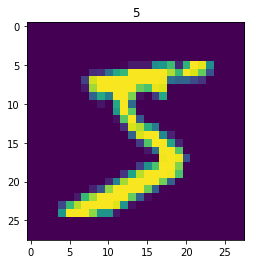

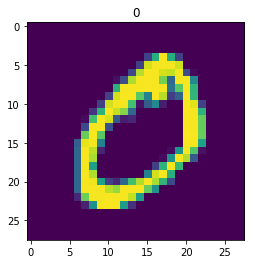

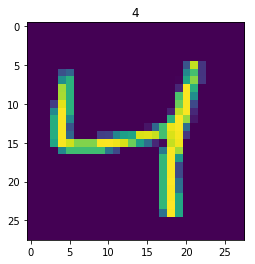

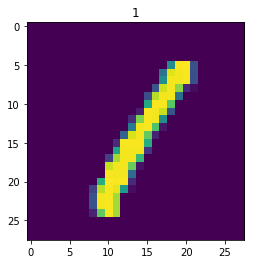

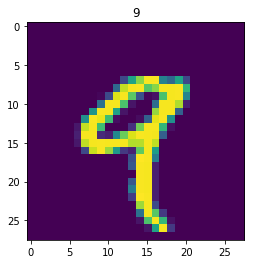

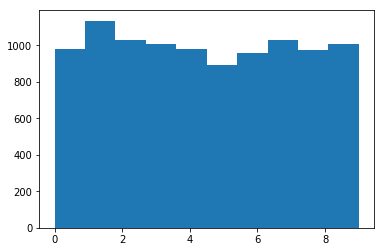

In [4]:
"""
###
Split data into train and test sets
###
"""

#training_examples, training_labels = ([], [])
#test_examples, test_labels = ([], [])

num_train = len(training_examples)  # amount of training examples/labels

num_test = len(test_examples)   # amount of test examples/labels

img_len = np.prod((training_examples[0].shape))      # Number of pixels in image

img_dim = (int(math.sqrt(img_len)), int(math.sqrt(img_len))) # Image dimension



training_examples = np.reshape(training_examples, (num_train, img_len, 1))
lab_examples = np.reshape(lab_examples, (num_train, img_len, 1))
test_examples = np.reshape(test_examples, (num_test, img_len, 1))
print(training_examples.shape)


print("Number of training examples and test examples: ", num_train, ", ", num_test)
print("data dimensions: ", img_dim)
print("example dimension: ", training_examples[0].shape)
print("Display some training examples:")


for i in range(0, 5):
    
    plt.title(training_labels[i])
    plt.imshow(training_examples[i].reshape(img_dim))
    plt.show()
    
plt.hist(test_labels)
plt.show()




# The neural network class

The network takes as input a list of sizes that determines the size of each layer(respective to each int) and a list of functions that work as activation functions for each layer relative to their order.



In [64]:
def error_function(output, expected, d = False, d_out = None):
    if not d:
        error = np.sum(np.matrix( (1/2) * np.sum(np.power(expected - output, 2))))
        #print("Error : ",error.shape)
        return np.nan_to_num(error)
    else:
        error = np.multiply(np.subtract(output, expected), (np.matrix(d_out)))
        #print("Error d: ",error.shape)
        return np.nan_to_num(error)
            
class neural_net:
    def __init__(self, sizes, activation_functions, lamb):
        if len(sizes) < 2:
            print("Invalid size parameters, requires 2(input and output) or more integers(input, hidden and output)")
            return 0
        
        if len(activation_functions) != len(sizes) - 1:
            print("The number of activation functions defined for each layer must be equal to the number of layers(excluding the input layer)!")
            return 0
        
        self.weights = []
        self.activation_functions = activation_functions
        self.sizes = sizes
        self.lamb = lamb
        
        
        for i, j in zip(self.sizes[:-1], self.sizes[1:]):
            self.weights.append(np.random.random_sample((j, i)) * math.sqrt(2/ (j*i)))
            
            #if allow_negative_weights:
            #    self.weights.append( w_range*2 + np.random.random_sample((j, i)) - w_range)
            #else:
            #    self.weights.append( w_range*2 + np.random.random_sample((j, i)))
        
        # variables for batch learning
        self.curr_batch = 0
        self.mean_error = []
        for i, j in zip(self.sizes[:-1], self.sizes[1:]):
            self.mean_error.append(np.zeros((j, i)))

        
    def train_feed_forward(self, input_vector, label):
        signals = []
        derived_signals = []
        signals.append(input_vector)
        derived_signals.append(input_vector)
        for w, f in zip(self.weights, self.activation_functions):
            
            derived_signals.append(f(np.dot(w, signals[-1]), d = True)) # Save derivative of signal
            signals.append(f(np.dot(w, signals[-1]), d = False)) # Save the signal itself
            
        
        return signals, derived_signals, error_function(signals[-1], label, d = True, d_out = derived_signals[-1])
    
    
    def backpropagate(self, signals, d_signals, out_error):

        error_vectors = list() # Error in each layer
        error_vectors.append(np.multiply(out_error, d_signals[-1])) # error in output layer

        for w in reversed(range(len(self.weights))):

            
            error = np.sum(np.multiply(self.weights[w], error_vectors[-1])) * (np.matrix(d_signals[w]))
            #error = np.multiply(np.sum(np.multiply(net.weights[w].T, error_vectors[-1]), axis = 1), np.matrix(d_signals[w]).T).T
            
            #first_step = self.weights[w] *  error_vectors[-1]
            #second_step = np.multiply(first_step * d_signals[w])
            error_vectors.append(error)
            
            # Deltas for updating weights
        deltas = list()
        for error, layer in zip(error_vectors, reversed(d_signals)):
            deltas.append(np.multiply(error, layer))
            
        return error_vectors, deltas
    
    def calc_mean_error(self, errors, deltas, signals, alpha, batch_size = 1):
        for w in range(len(self.weights)):
            alp = alpha * errors[-(w + 2)].dot(signals[w].T)
            self.mean_error[w] = self.mean_error[w] + (alp / batch_size)
            
    def quick_update_weights(self, batch_size):
        for w in range(len(self.weights)):
            self.weights[w] = (self.weights[w] - self.mean_error[w]) - (alpha * (self.lamb/2*batch_size) * self.weights[w])
            
        self.curr_batch = 0
        self.mean_error = []
        for i, j in zip(self.sizes[:-1], self.sizes[1:]):
            self.mean_error.append(np.zeros((j, i)))
    
    def update_weights(self, errors, deltas, signals, alpha):
        
            #weight = weight + learning_rate * error * input
        for w in range(len(self.weights)):
            alp = alpha * errors[-(w + 2)].dot(signals[w].T)
            self.weights[w] = self.weights[w] - alp
            
            #print(np.max(alpha * errors[-(w + 1)].T * signals[w + 1]), np.min(alpha * errors[-(w + 1)].T * signals[w + 1]))
    
    def train(self, input_vector, label, alpha, batch_size = 1):
        
        
            # Error in output layer, use train method to get error as well
        signals, d_signals, output_error = self.train_feed_forward(input_vector, label)
        
            # Perform backpropagation
        errors, deltas = self.backpropagate(signals, d_signals, output_error)
        
        self.curr_batch += 1
        
        self.calc_mean_error(errors, deltas, signals, alpha, batch_size)
        
        
        if self.curr_batch == batch_size:
                # Update weights with backpropagated data
            #self.update_weights(errors, deltas, signals, alpha)
            self.quick_update_weights(batch_size)

        return error_function(signals[-1], label)
    
    
    def batch_training(self, input_vectors, labels, alpha, epochs, batch):
        for e in range(epochs):
            for v, l in zip(input_vectors, labels):
                self.train(v, l, alpha, batch_size = batch)
            
    

# Method for learning process

display signals will show an image of the activations to display the networks accuracy. Does not work if the number of neurons in a givn layer is not a perfect square

In [31]:

def display_signals(signals, title, sizes):
    figure(num=None, figsize=(15, 15), dpi=120, facecolor='w', edgecolor='k')
    f, axis_y = plt.subplots(1, len(signals), sharey= True)
        
    for s in range(len(signals)):
        if sizes[s] != 10:
            dim_int = int(math.sqrt(sizes[s]))
            dim = (dim_int, dim_int)
            axis_y[s].imshow(signals[s].reshape(dim))
        else:
            print(signals[s])
    plt.title("error: " + str(title))
    plt.show()

# Using the model 

0.622592557761509 0.5456893581670248


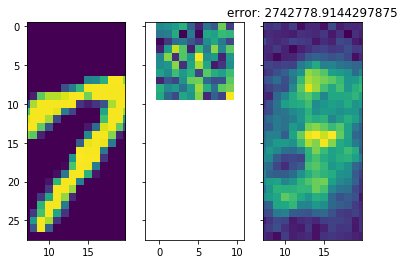

0.7234946465077239 0.5506356224606966


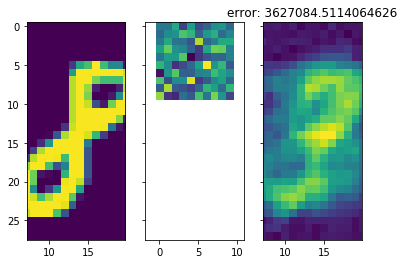

0.7710603682202001 0.5490486494047004


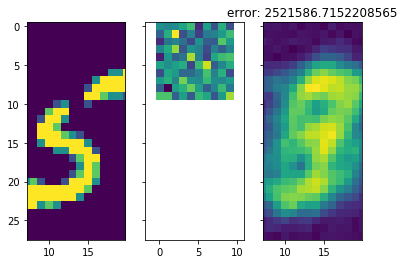

0.8159923417493491 0.550324593570816


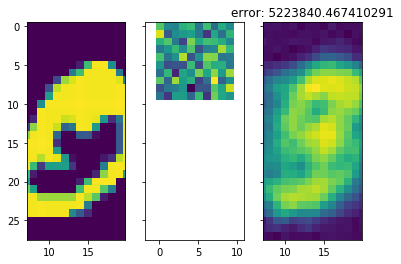

0.8337731420760714 0.5491380388318219


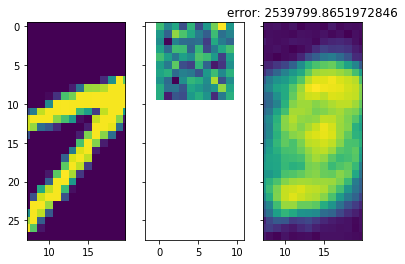

0.8526511329510439 0.5491554636628954


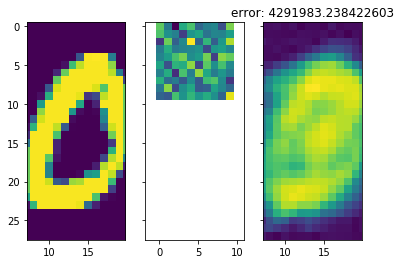

0.8646222875608292 0.5485800614136931


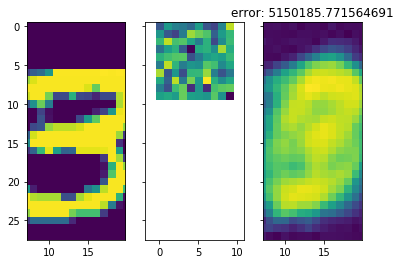

0.8714467646525194 0.5472944532865539


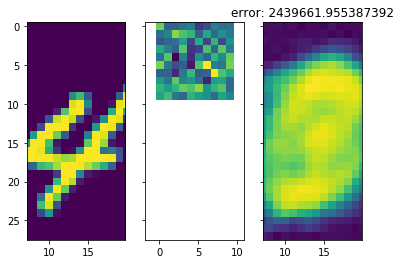

0.8799963490383924 0.5469611088010361


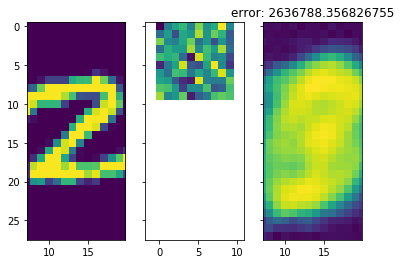

0.8892672405473288 0.5466702354994251


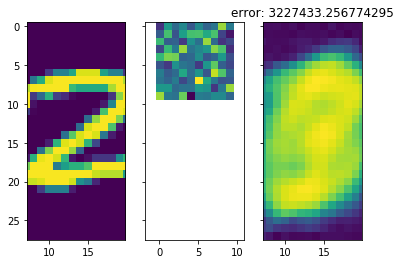

0.89417267026597 0.5458144014142966


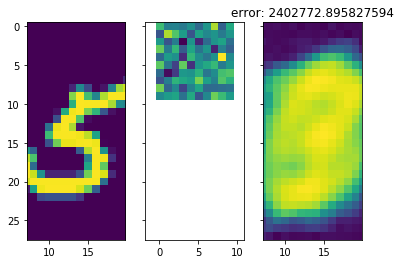

0.8933960827583477 0.5440385308795446


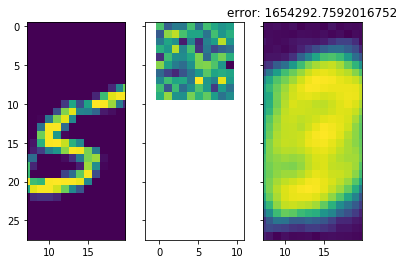

0.9045714860431281 0.5448980911127139


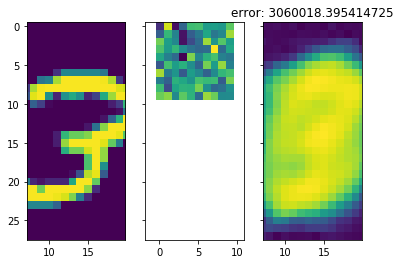

0.9079932503743174 0.5442641267271501


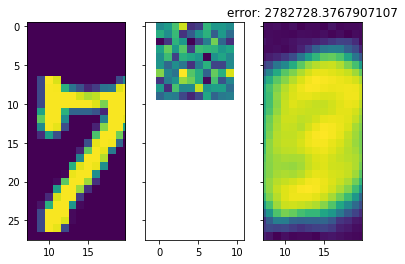

0.9110331687099773 0.5436402009043606


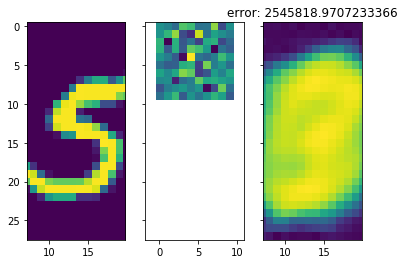

0.9151830409269285 0.5432224669316824


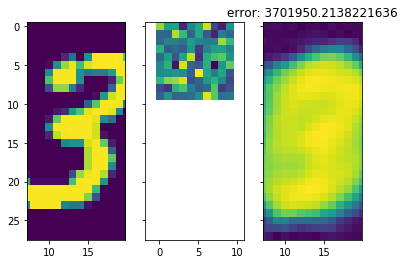

0.9155141239171992 0.5422749228978687


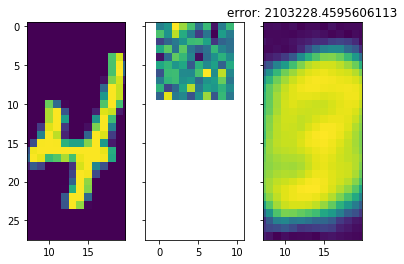

0.9171396185235124 0.5414354320757211


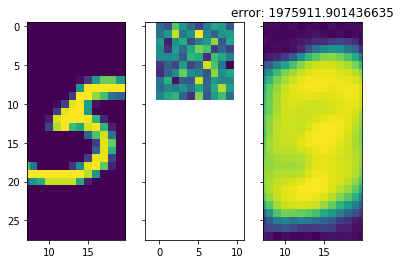

0.9227338652034328 0.5415183295451667


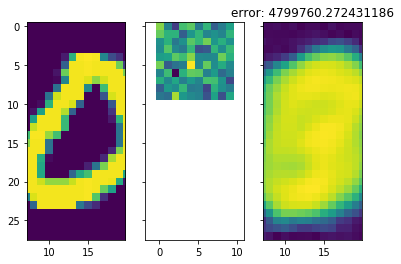

0.9236190379937348 0.5408523008037287


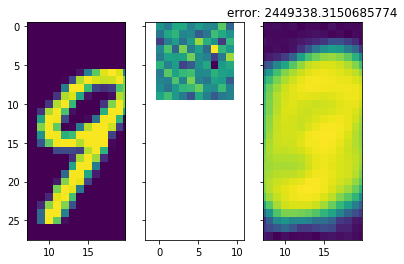

0.922404878343617 0.5397186136060492


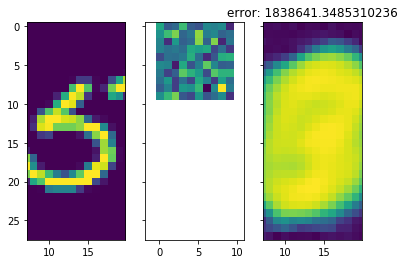

0.9249682669233931 0.5395406398297673


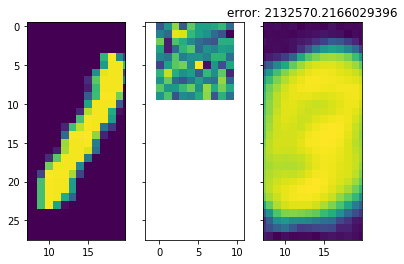

0.9274575720068747 0.539142511244954


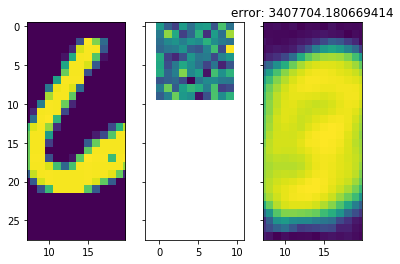

0.9293003823572278 0.5385997941076796


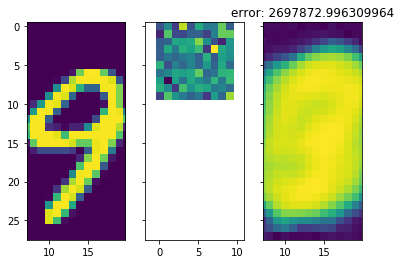

0.9309981908829902 0.5381057821220688


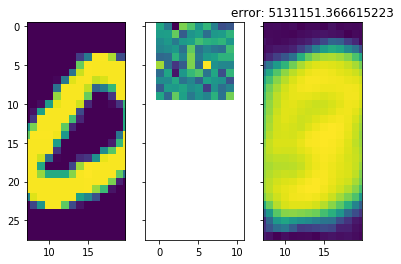

0.9324982931514691 0.5375166457869508


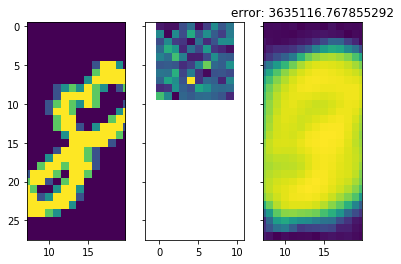

0.9340117179762538 0.5369199748613093


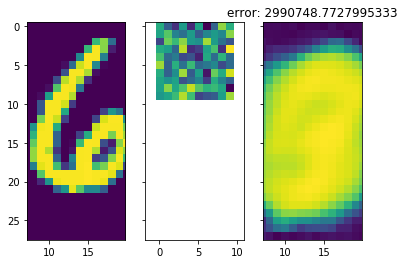

0.9329482472221281 0.5359033228582507


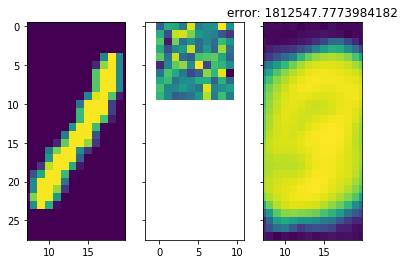

0.9313462866255092 0.534968718457902


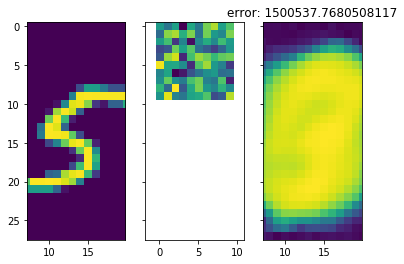

0.9361751549665155 0.535301318953319


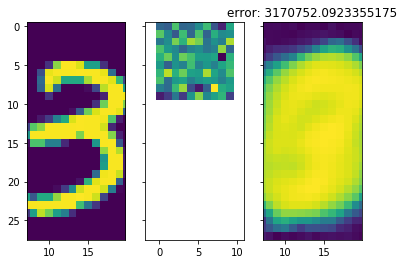

0.9370252551620294 0.5347774420890851


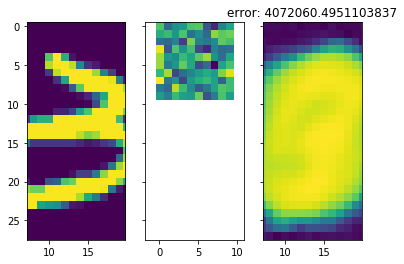

0.9371189962440479 0.5340359700474443


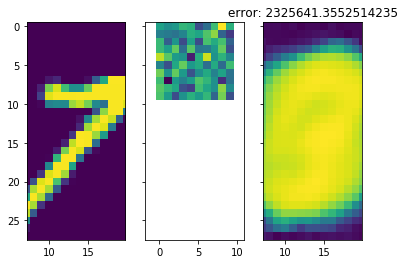

0.9378680266267169 0.53356943626821


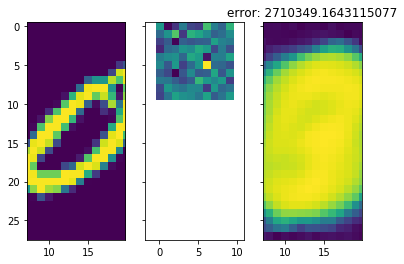

0.937524083883551 0.5327981803548216


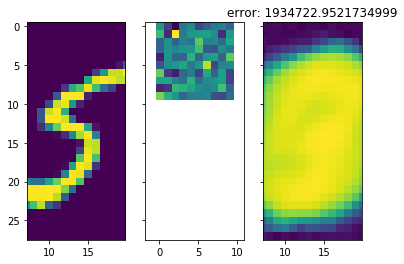

0.9403173412056061 0.5325772524941488


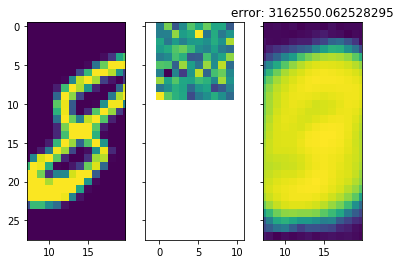

0.9403588665306295 0.5319186435112703


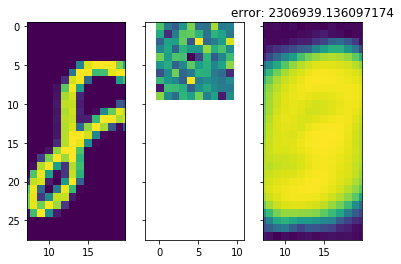

0.941098050150315 0.5315196925039073


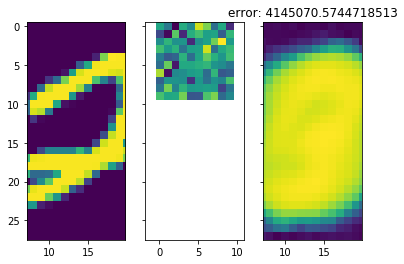

0.9419633255486503 0.5309774506794188


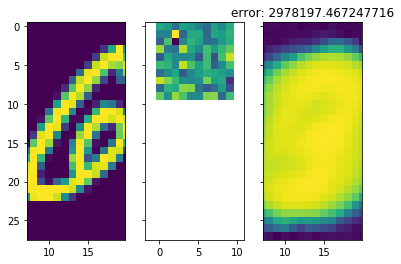

0.9425572742511176 0.5304744085922585


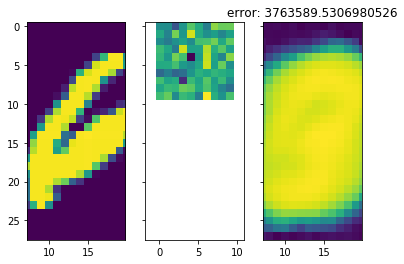

0.9427237046440163 0.529941897983348


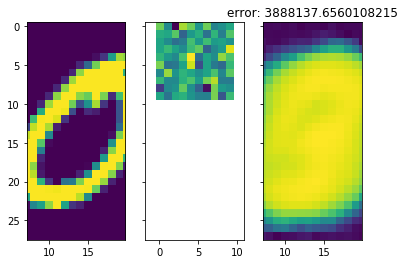

0.9430468917765096 0.5293299197656254


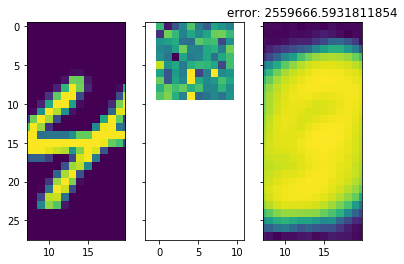

0.9432852740636025 0.528819315809686


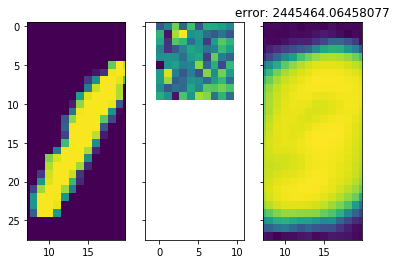

0.9437926113405111 0.5283639930392272


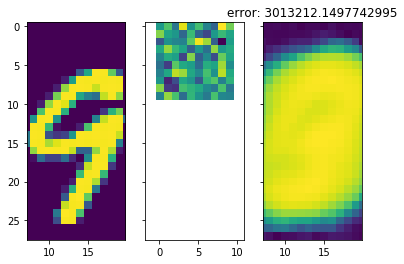

0.9440060224368128 0.5278113661283733


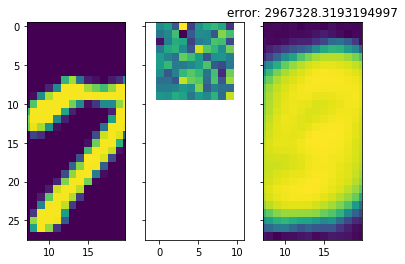

0.9447373820367818 0.5273427049943277


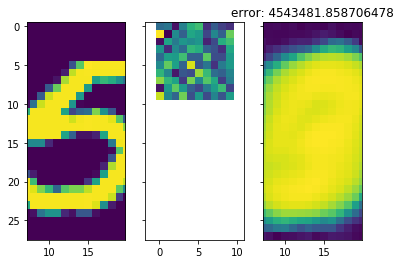

0.9447978447001774 0.526799627148843


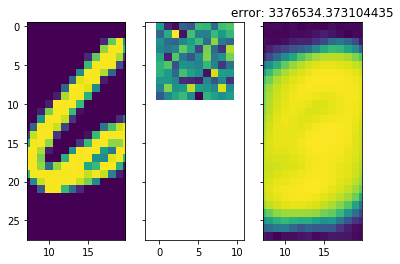

0.9453929327076516 0.5263086156490588


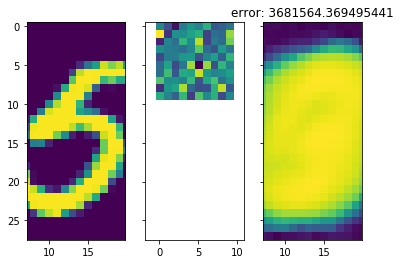

0.9460565899377191 0.5257761361818356


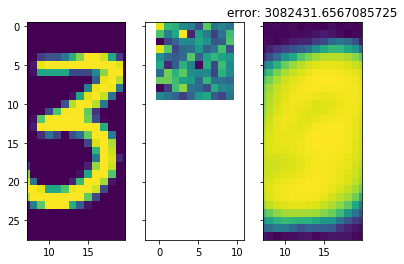

0.9451504233669359 0.525069790921315


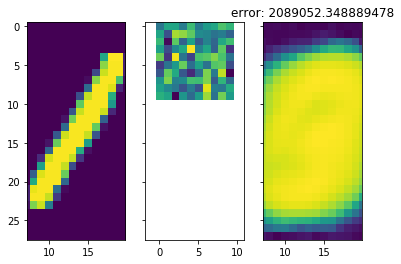

0.9463373027031792 0.5247723648827636


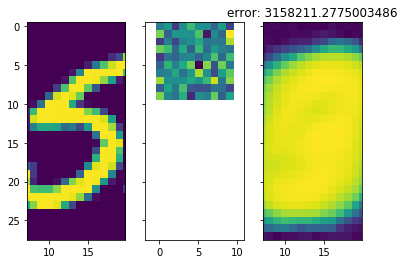

0.9471027550096902 0.5242756041043691


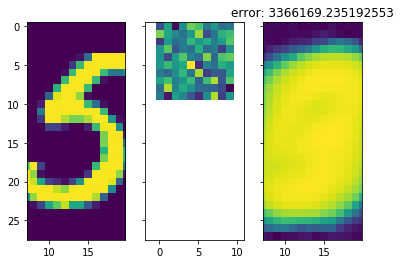

0.9475581521017522 0.5237979595853304


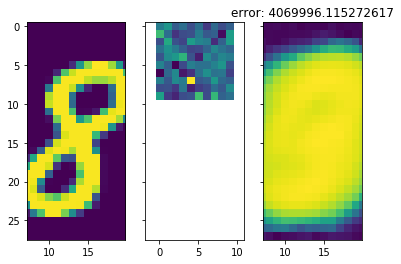

0.9472479940998303 0.5232356096707622


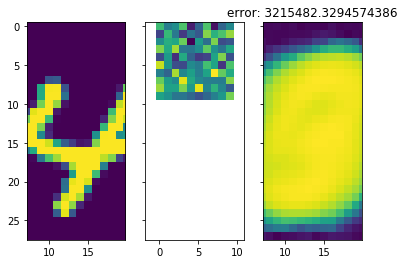

0.9457519966294216 0.5225200464091512


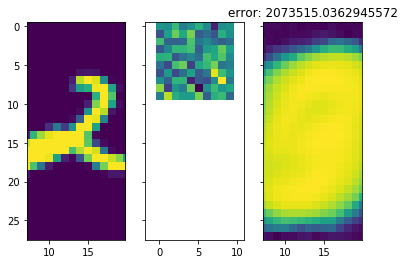

0.9453982178762936 0.5219264735779151


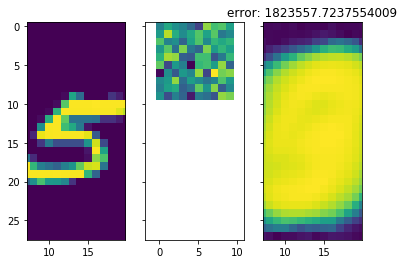

0.9485282541568233 0.5218186545595493


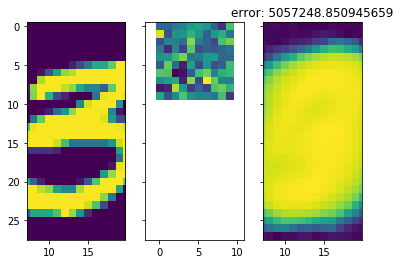

0.9484374737777362 0.5212980627812406


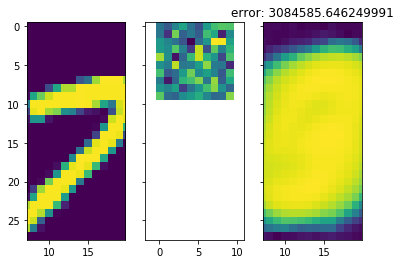

0.9492240833471757 0.5208296299717022


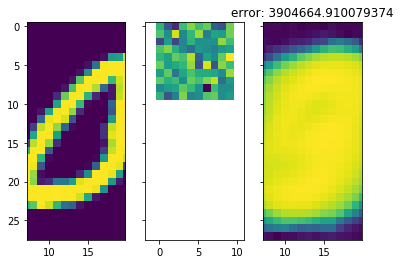

0.9489018241296783 0.520298838449609


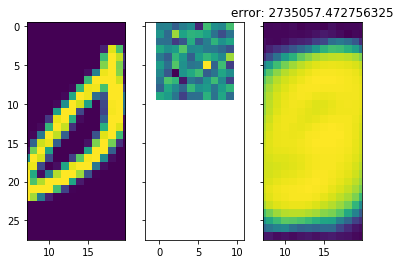

0.9492964454146349 0.5204608836894851


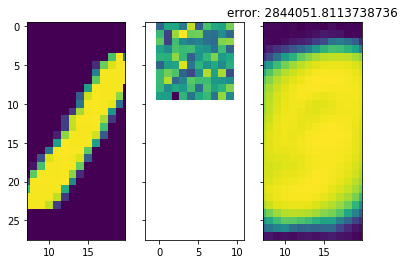

0.9496497105198601 0.5200095606514488


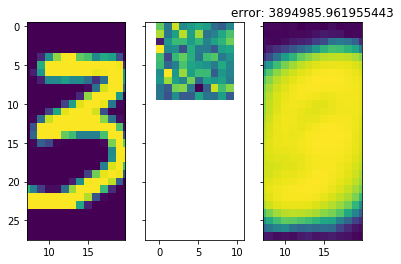

0.9498286901335702 0.5195044641410946


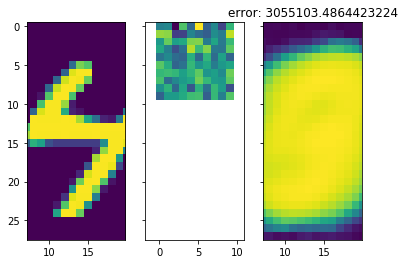

0.9499182646752288 0.5190472127323466


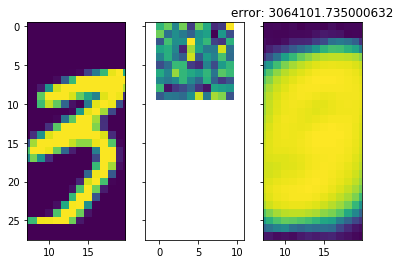

0.9430367842917549 0.5177213137763402


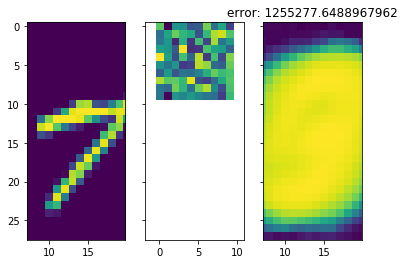

0.9494349129409174 0.5180286295847315


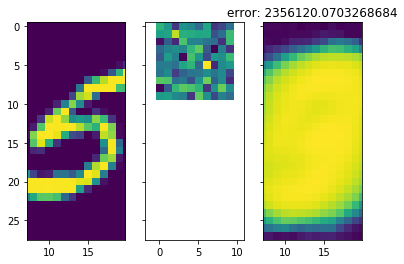

0.9496925565134515 0.5175891163174917


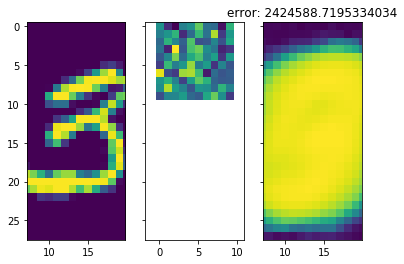

0.9500875836698904 0.5171065208723364


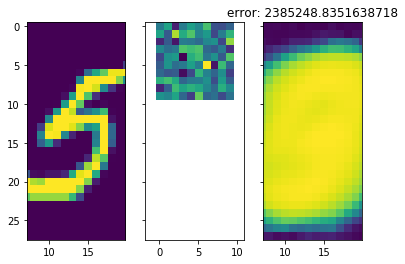

0.9506297963146046 0.5166873214482891


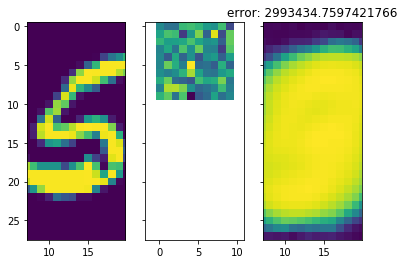

0.9511020885679935 0.516248593521885


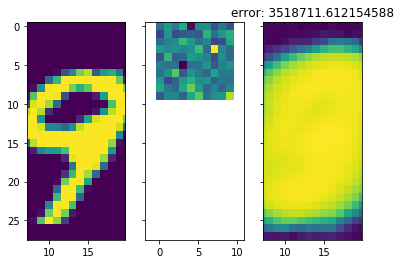

0.9508239177669104 0.5157411186249767


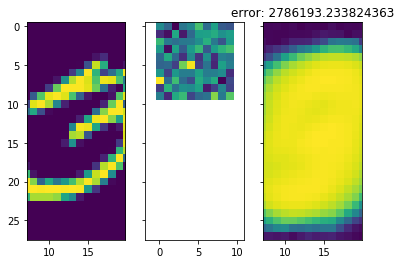

0.9480439330131377 0.5149667172639317


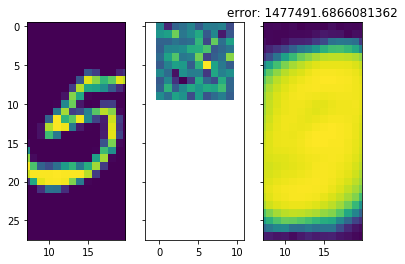

0.9515401060163996 0.5148490249538903


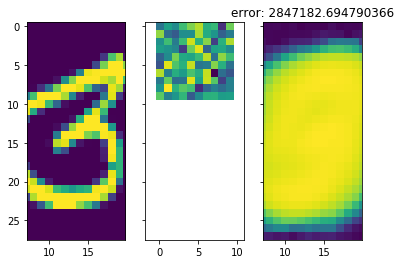

0.9515874306095984 0.5143939043168286


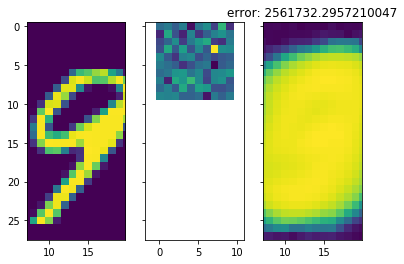

0.9521487196375186 0.5139658566559167


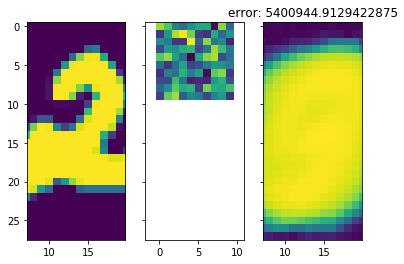

0.9524477231831 0.5135131168938386


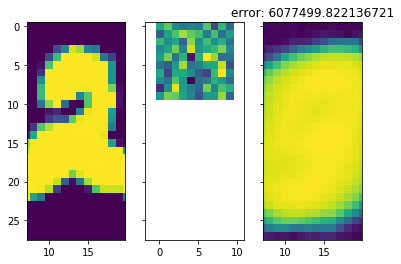

0.9527751475284426 0.5130585257521666


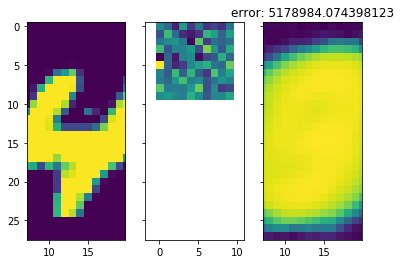

0.9530629074493382 0.5126068763251747


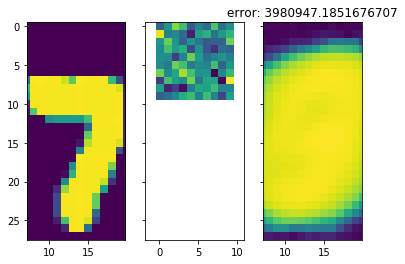

0.9535510785622077 0.5121635853964808


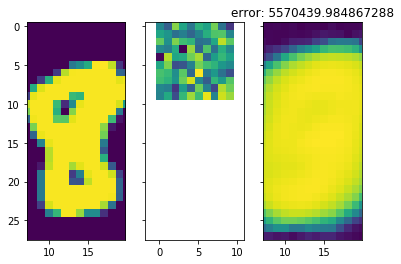

0.9536955853049556 0.5117167815556308


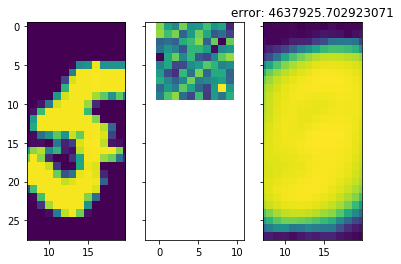

0.9538338186611511 0.5112717278147113


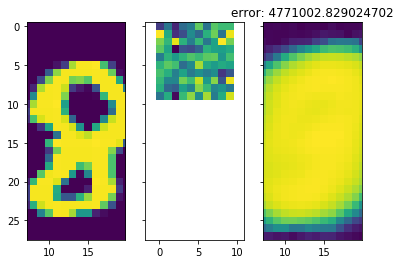

0.9542322376809899 0.510828343564823


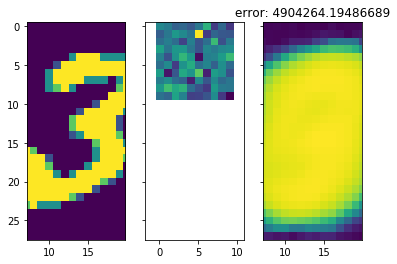

0.9541099811042277 0.510372228639727


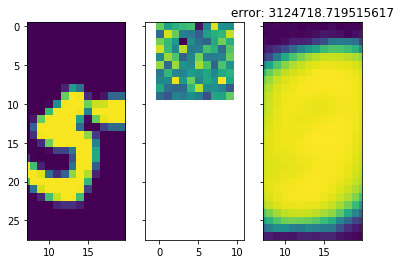

0.9545950281446657 0.5099503197731542


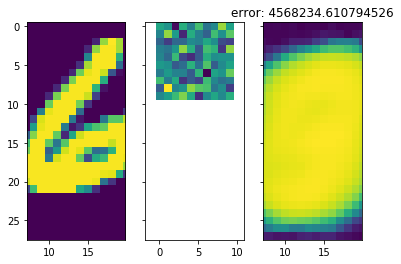

0.9547573210717352 0.5095109512716841


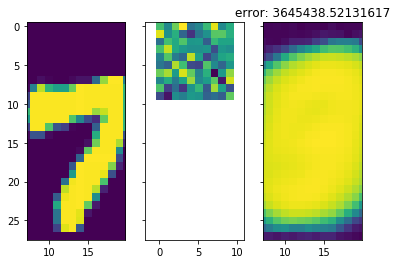

0.9549327711642579 0.5090810004315746


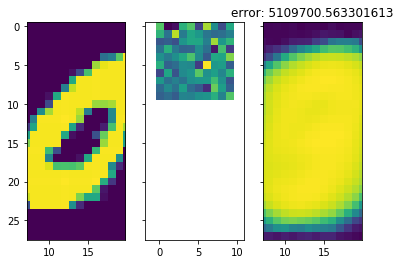

0.954887975334095 0.5086466124507323


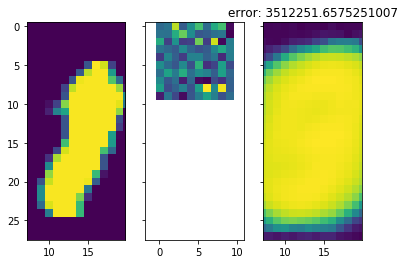

0.9550836592648444 0.5082187851194296


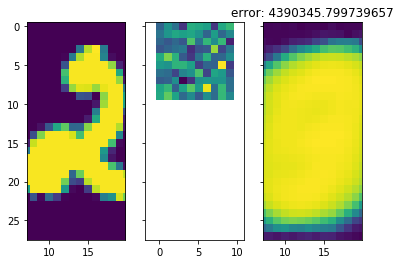

0.9551648548165235 0.507783362119362


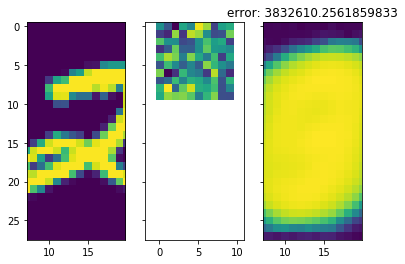

0.9551539070864008 0.5073574058313479


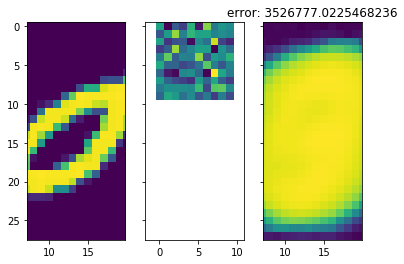

0.9551002983948405 0.5069295750662401


KeyboardInterrupt: 

In [43]:

sizes = [784, 100, 784]
input_shape = (sizes[0], 1)
a_functions = []
[a_functions.append(sigmoid) for i in range(len(sizes) - 1)]


alpha = 0.0005
epochs = 10
mini_batch_size = 16
lamb = 1


net = neural_net(sizes, a_functions, lamb)

#errors = train_network(net, training_examples, lab, epochs = epochs, alpha = alpha, batch_size=mini_batch_size, force_overfit = False)
errors = list()
counter = 0
for i in range(epochs):
    for e in range(len(training_examples)):
        net.train(training_examples[e], lab_examples[e], alpha, batch_size= mini_batch_size)
        counter +=1
        if counter == mini_batch_size:
                signals = net.train_feed_forward(training_examples[e], lab_examples[e])[0]
                print(np.max(signals[-1]), np.min(signals[-1]))
                title = str(error_function(signals[-1], lab_examples[e], d= False))
                display_signals(signals, title, net.sizes)
                counter = 0
"""
for e in range(50000):
    net.train(training_examples[0], lab_examples[0], alpha, batch_size= mini_batch_size)
    counter +=1
    if counter == mini_batch_size:
            signals = net.train_feed_forward(training_examples[0], lab_examples[0])[0]
            print(np.max(signals[-1]), np.min(signals[-1]))
            title = str(error_function(signals[-1], lab_examples[0], d= False))
            display_signals(signals, title, net.sizes)
            counter = 0
"""            
figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')
# Becomes hard to read if first error is considerably larger than 0 (e.g. 2 000 000)
#plt.ylim((0, np.max(errors)))

plt.plot(errors)
plt.show()

#net.batch_training(training_examples, training_labels, alpha, epochs, mini_batch_size)




In [ ]:
import random
weights = []
biases = []
[biases.append(random.randrange(-5.0, 5.0)) for i in range(len(sizes) - 1)]
[weights.append(np.random.random_sample((j, i))) for i, j in zip(sizes[:-1], sizes[1:])]

signals = []
signals.append(training_examples[0])
for w, b in zip(weights, biases):
    signals.append(l_relu(w.dot(signals[-1]) + b))

    

    


# Test if the network can learn basic operations like adition and subtraction


In [60]:
# Generate dummy data
t_e = [ -10000 * np.random.random_sample((2, 1)) + 5000 for i in range(10000)]
l_e = [np.sum(e) for e in t_e]

print(t_e[0])
print(l_e[0])

[[ 3711.52285963]
 [-1918.04098822]]
1793.4818714124913


In [81]:
s = [2, 1]
a_f = [l_relu]

alpha = 0.01
epochs = 2
mini_batch_size = 13

n = neural_net(s, a_f, lamb = 5)
for e in range(epochs):
    for t, l in zip(t_e, l_e):
        
        print("try to predict: ")
        print("    ", t[0], " + ", t[1], " = ", l)
        sig, d_dig, err = n.train_feed_forward(t, l)
        
        print("got: ")
        print("    ", sig[0][0], " + ", sig[0][1], " = ", sig[1][0])
        
        print("Weights")
        print(n.weights)
        
        print()
        n.train(t, l, alpha, mini_batch_size)

try to predict: 
     [3711.52285963]  +  [-1918.04098822]  =  1793.4818714124913
got: 
     [3711.52285963]  +  [-1918.04098822]  =  [1629.08189194]
Weights
[array([[0.7398327 , 0.58227331]])]

try to predict: 
     [-1933.79554007]  +  [-2903.88246153]  =  -4837.678001597483
got: 
     [-1933.79554007]  +  [-2903.88246153]  =  [-156.07692166]
Weights
[array([[0.7398327 , 0.58227331]])]

try to predict: 
     [-3165.74778548]  +  [3996.52402666]  =  830.7762411789158
got: 
     [-3165.74778548]  +  [3996.52402666]  =  [-0.75272209]
Weights
[array([[0.7398327 , 0.58227331]])]

try to predict: 
     [-1677.84724378]  +  [-2882.14162094]  =  -4559.9888647216
got: 
     [-1677.84724378]  +  [-2882.14162094]  =  [-145.97602016]
Weights
[array([[0.7398327 , 0.58227331]])]

try to predict: 
     [2148.99601956]  +  [243.94327892]  =  2392.9392984797432
got: 
     [2148.99601956]  +  [243.94327892]  =  [1731.93918498]
Weights
[array([[0.7398327 , 0.58227331]])]

try to predict: 
     [-2288.2

     [2847.83303378]  +  [1184.27358325]  =  4032.1066170322515
got: 
     [2847.83303378]  +  [1184.27358325]  =  [-3.62804414e+20]
Weights
[matrix([[-2.28766296e+18, -6.25874074e+17]])]

try to predict: 
     [-3426.85489787]  +  [4467.9296945]  =  1041.0747966342606
got: 
     [-3426.85489787]  +  [4467.9296945]  =  [5.04312766e+21]
Weights
[matrix([[-2.28766296e+18, -6.25874074e+17]])]

try to predict: 
     [-3843.97162182]  +  [-2879.26561519]  =  -6723.237237012431
got: 
     [-3843.97162182]  +  [-2879.26561519]  =  [1.05957692e+22]
Weights
[matrix([[-2.28766296e+18, -6.25874074e+17]])]

try to predict: 
     [2179.55482412]  +  [-735.16089993]  =  1444.3939241965159
got: 
     [2179.55482412]  +  [-735.16089993]  =  [-2.26298435e+20]
Weights
[matrix([[-2.28766296e+18, -6.25874074e+17]])]

try to predict: 
     [3941.80903864]  +  [4946.38134456]  =  8888.190383204717
got: 
     [3941.80903864]  +  [4946.38134456]  =  [-6.05667119e+20]
Weights
[matrix([[-2.28766296e+18, -6.2587

try to predict: 
     [-2133.54785738]  +  [-2837.12691116]  =  -4970.674768536789
got: 
     [-2133.54785738]  +  [-2837.12691116]  =  [-5.39744666e+42]
Weights
[matrix([[1.61299947e+40, 2.59187622e+40]])]

try to predict: 
     [-759.45169313]  +  [2979.01003213]  =  2219.558339004284
got: 
     [-759.45169313]  +  [2979.01003213]  =  [-1.71673801e+47]
Weights
[matrix([[-3.36805146e+44, -1.23841921e+45]])]

try to predict: 
     [4974.96387539]  +  [-3363.83748626]  =  1611.1263891342005
got: 
     [4974.96387539]  +  [-3363.83748626]  =  [2.49024753e+48]
Weights
[matrix([[-3.36805146e+44, -1.23841921e+45]])]

try to predict: 
     [-4782.07067564]  +  [1282.85532402]  =  -3499.215351621264
got: 
     [-4782.07067564]  +  [1282.85532402]  =  [2.19133326e+46]
Weights
[matrix([[-3.36805146e+44, -1.23841921e+45]])]

try to predict: 
     [-3331.72703824]  +  [-4375.03856218]  =  -7706.765600417362
got: 
     [-3331.72703824]  +  [-4375.03856218]  =  [6.54027461e+48]
Weights
[matrix([[-3

     [-3398.03581625]  +  [1576.10738205]  =  -1821.928434197484
got: 
     [-3398.03581625]  +  [1576.10738205]  =  [3.34520284e+69]
Weights
[matrix([[3.28541729e+66, 9.20569792e+66]])]

try to predict: 
     [3241.97774448]  +  [1288.4622668]  =  4530.44001127877
got: 
     [3241.97774448]  +  [1288.4622668]  =  [2.25124441e+70]
Weights
[matrix([[3.28541729e+66, 9.20569792e+66]])]

try to predict: 
     [-2392.89969476]  +  [2367.32784334]  =  -25.57185142121807
got: 
     [-2392.89969476]  +  [2367.32784334]  =  [1.3931231e+70]
Weights
[matrix([[3.28541729e+66, 9.20569792e+66]])]

try to predict: 
     [-4926.96919592]  +  [-2804.13642611]  =  -7731.1056220310775
got: 
     [-4926.96919592]  +  [-2804.13642611]  =  [-2.10005913e+69]
Weights
[matrix([[3.28541729e+66, 9.20569792e+66]])]

try to predict: 
     [-4577.1571179]  +  [-1684.70210996]  =  -6261.859227860851
got: 
     [-4577.1571179]  +  [-1684.70210996]  =  [9.55529815e+74]
Weights
[matrix([[-1.01748666e+71, -2.90739937e+7

     [4585.0076161]  +  [-4744.82692246]  =  [-2.72638079e+91]
Weights
[matrix([[-5.25353244e+89, -3.92737712e+89]])]

try to predict: 
     [-1782.25832486]  +  [-2138.59251753]  =  -3920.850842385016
got: 
     [-1782.25832486]  +  [-2138.59251753]  =  [1.77622112e+93]
Weights
[matrix([[-5.25353244e+89, -3.92737712e+89]])]

try to predict: 
     [500.14885423]  +  [-4538.32446608]  =  -4038.1756118581343
got: 
     [500.14885423]  +  [-4538.32446608]  =  [1.51961634e+93]
Weights
[matrix([[-5.25353244e+89, -3.92737712e+89]])]

try to predict: 
     [-739.94909702]  +  [-1283.95331183]  =  -2023.9024088560063
got: 
     [-739.94909702]  +  [-1283.95331183]  =  [-2.33965955e+96]
Weights
[matrix([[3.31964759e+94, 1.73133154e+94]])]

try to predict: 
     [-255.3592779]  +  [-3024.2333568]  =  -3279.5926346986
got: 
     [-255.3592779]  +  [-3024.2333568]  =  [-3.04182671e+96]
Weights
[matrix([[3.31964759e+94, 1.73133154e+94]])]

try to predict: 
     [-397.16080544]  +  [-1120.23331444] 

     [-1429.16951589]  +  [-4680.68864761]  =  [-8.04200054e+114]
Weights
[matrix([[2.71453394e+112, 2.60740948e+112]])]

try to predict: 
     [-3958.28054828]  +  [4107.19848834]  =  148.91794006016153
got: 
     [-3958.28054828]  +  [4107.19848834]  =  [-1.78693142e+112]
Weights
[matrix([[2.71453394e+112, 2.60740948e+112]])]

try to predict: 
     [-1383.23545659]  +  [4286.94578832]  =  2903.7103317305655
got: 
     [-1383.23545659]  +  [4286.94578832]  =  [7.42298348e+115]
Weights
[matrix([[2.71453394e+112, 2.60740948e+112]])]

try to predict: 
     [-4063.70187525]  +  [-1212.39995526]  =  -5276.101830511178
got: 
     [-4063.70187525]  +  [-1212.39995526]  =  [-7.09613989e+114]
Weights
[matrix([[2.71453394e+112, 2.60740948e+112]])]

try to predict: 
     [631.76621321]  +  [2453.9206782]  =  3085.68689141258
got: 
     [631.76621321]  +  [2453.9206782]  =  [8.11332685e+115]
Weights
[matrix([[2.71453394e+112, 2.60740948e+112]])]

try to predict: 
     [2333.0025299]  +  [-4356.75

[matrix([[-6.36043014e+135, -1.15016960e+136]])]

try to predict: 
     [-2713.91889456]  +  [903.03207438]  =  -1810.88682018086
got: 
     [-2713.91889456]  +  [903.03207438]  =  [6.87529114e+138]
Weights
[matrix([[-6.36043014e+135, -1.15016960e+136]])]

try to predict: 
     [1269.11837449]  +  [-1603.51101654]  =  -334.39264205582595
got: 
     [1269.11837449]  +  [-1603.51101654]  =  [1.03709575e+139]
Weights
[matrix([[-6.36043014e+135, -1.15016960e+136]])]

try to predict: 
     [732.38441124]  +  [-4844.45295351]  =  -4112.068542273912
got: 
     [732.38441124]  +  [-4844.45295351]  =  [5.10611452e+139]
Weights
[matrix([[-6.36043014e+135, -1.15016960e+136]])]

try to predict: 
     [-686.8433474]  +  [4493.6859628]  =  3806.84261539461
got: 
     [-686.8433474]  +  [4493.6859628]  =  [-2.36581953e+138]
Weights
[matrix([[-6.36043014e+135, -1.15016960e+136]])]

try to predict: 
     [-1413.81395028]  +  [-3434.70281349]  =  -4848.516763770657
got: 
     [-1413.81395028]  +  [-3434

c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: overflow encountered in multiply
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: overflow encountered in multiply
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until




try to predict: 
     [-3773.1888994]  +  [3559.07583869]  =  -214.11306071311947
got: 
     [-3773.1888994]  +  [3559.07583869]  =  [5.26876843e+162]
Weights
[matrix([[1.23183878e+159, 2.78632131e+159]])]

try to predict: 
     [28.46169117]  +  [4788.84856599]  =  4817.310257166729
got: 
     [28.46169117]  +  [4788.84856599]  =  [1.3378331e+163]
Weights
[matrix([[1.23183878e+159, 2.78632131e+159]])]

try to predict: 
     [-675.37748063]  +  [159.41378873]  =  -515.9636918991428
got: 
     [-675.37748063]  +  [159.41378873]  =  [-1.93889068e+160]
Weights
[matrix([[1.23183878e+159, 2.78632131e+159]])]

try to predict: 
     [2149.33442445]  +  [3981.91904588]  =  6131.2534703235615
got: 
     [2149.33442445]  +  [3981.91904588]  =  [1.37425394e+163]
Weights
[matrix([[1.23183878e+159, 2.78632131e+159]])]

try to predict: 
     [4704.69892579]  +  [3103.63017033]  =  7808.32909612095
got: 
     [4704.69892579]  +  [3103.63017033]  =  [1.44431415e+163]
Weights
[matrix([[1.23183878e+15

try to predict: 
     [-433.62999898]  +  [-982.84696458]  =  -1416.476963565654
got: 
     [-433.62999898]  +  [-982.84696458]  =  [3.00573769e+185]
Weights
[matrix([[-1.90221198e+182, -2.21894312e+182]])]

try to predict: 
     [-2412.96424221]  +  [-4401.16091158]  =  -6814.125153788566
got: 
     [-2412.96424221]  +  [-4401.16091158]  =  [1.43558952e+186]
Weights
[matrix([[-1.90221198e+182, -2.21894312e+182]])]

try to predict: 
     [-1958.29689929]  +  [-1893.67085428]  =  -3851.9677535726078
got: 
     [-1958.29689929]  +  [-1893.67085428]  =  [7.92704374e+185]
Weights
[matrix([[-1.90221198e+182, -2.21894312e+182]])]

try to predict: 
     [-399.84098957]  +  [1952.65621745]  =  1552.8152278764355
got: 
     [-399.84098957]  +  [1952.65621745]  =  [-1.78612538e+184]
Weights
[matrix([[-1.90221198e+182, -2.21894312e+182]])]

try to predict: 
     [486.82851668]  +  [4988.58658237]  =  5475.4150990465405
got: 
     [486.82851668]  +  [4988.58658237]  =  [-5.99772046e+184]
Weights
[

[matrix([[4.15956378e+205, 3.14283893e+205]])]

try to predict: 
     [1271.11079444]  +  [3796.43485926]  =  5067.545653700615
got: 
     [1271.11079444]  +  [3796.43485926]  =  [1.72188497e+209]
Weights
[matrix([[4.15956378e+205, 3.14283893e+205]])]

try to predict: 
     [4115.70723491]  +  [1206.21928422]  =  5321.9265191275545
got: 
     [4115.70723491]  +  [1206.21928422]  =  [2.09104997e+209]
Weights
[matrix([[4.15956378e+205, 3.14283893e+205]])]

try to predict: 
     [3508.65885596]  +  [361.475113]  =  3870.13396895106
got: 
     [3508.65885596]  +  [361.475113]  =  [1.57305483e+209]
Weights
[matrix([[4.15956378e+205, 3.14283893e+205]])]

try to predict: 
     [682.81926127]  +  [-3294.62838349]  =  -2611.8091222155535
got: 
     [682.81926127]  +  [-3294.62838349]  =  [-3.75712804e+207]
Weights
[matrix([[4.15956378e+205, 3.14283893e+205]])]

try to predict: 
     [1690.62903463]  +  [-3634.75293579]  =  -1944.1239011657099
got: 
     [1690.62903463]  +  [-3634.75293579]  =  

c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


 [-299.89790982]  +  [-539.76284591]  =  [-4.79287453e+223]
Weights
[matrix([[ 2.95959689e+223, -1.46679127e+223]])]

try to predict: 
     [1558.22423049]  +  [-1051.94458705]  =  506.279643437525
got: 
     [1558.22423049]  +  [-1051.94458705]  =  [6.15469872e+226]
Weights
[matrix([[ 2.95959689e+223, -1.46679127e+223]])]

try to predict: 
     [-4410.51216401]  +  [-1859.93962218]  =  -6270.451786187649
got: 
     [-4410.51216401]  +  [-1859.93962218]  =  [-5.16259744e+225]
Weights
[matrix([[ 2.95959689e+223, -1.46679127e+223]])]

try to predict: 
     [-3794.80405287]  +  [439.92108018]  =  -3354.8829726932836
got: 
     [-3794.80405287]  +  [439.92108018]  =  [-5.93818134e+225]
Weights
[matrix([[ 2.95959689e+223, -1.46679127e+223]])]

try to predict: 
     [-1189.50759014]  +  [-682.79824604]  =  -1872.305836183802
got: 
     [-1189.50759014]  +  [-682.79824604]  =  [-1.25947023e+225]
Weights
[matrix([[ 2.95959689e+223, -1.46679127e+223]])]

try to predict: 
     [-4265.44802488]  

     [4774.64863682]  +  [1120.48579416]  =  5895.134430979435
got: 
     [4774.64863682]  +  [1120.48579416]  =  [-3.39078889e+248]
Weights
[matrix([[-1.74581182e+246,  1.38695223e+246]])]

try to predict: 
     [4728.88161656]  +  [-249.98787534]  =  4478.893741215073
got: 
     [4728.88161656]  +  [-249.98787534]  =  [-4.30122934e+248]
Weights
[matrix([[-1.74581182e+246,  1.38695223e+246]])]

try to predict: 
     [-3850.31742816]  +  [470.26625131]  =  -3380.051176850009
got: 
     [-3850.31742816]  +  [470.26625131]  =  [7.37416652e+249]
Weights
[matrix([[-1.74581182e+246,  1.38695223e+246]])]

try to predict: 
     [3978.20551468]  +  [-4100.35243272]  =  -122.14691804577342
got: 
     [3978.20551468]  +  [-4100.35243272]  =  [-6.31609559e+248]
Weights
[matrix([[-1.74581182e+246,  1.38695223e+246]])]

try to predict: 
     [-2926.51209303]  +  [-640.66371846]  =  -3567.175811486987
got: 
     [-2926.51209303]  +  [-640.66371846]  =  [4.22056944e+249]
Weights
[matrix([[-1.74581182

     [4103.80041214]  +  [2477.59927931]  =  [-3.5011494e+266]
Weights
[matrix([[-9.39686584e+264,  1.27383647e+265]])]

try to predict: 
     [-1510.94815057]  +  [3950.53405312]  =  2439.585902550315
got: 
     [-1510.94815057]  +  [3950.53405312]  =  [6.45215204e+268]
Weights
[matrix([[-9.39686584e+264,  1.27383647e+265]])]

try to predict: 
     [-1201.86781176]  +  [3688.07326862]  =  2486.2054568599033
got: 
     [-1201.86781176]  +  [3688.07326862]  =  [5.82738128e+268]
Weights
[matrix([[-9.39686584e+264,  1.27383647e+265]])]

try to predict: 
     [3177.42332832]  +  [-2169.00747822]  =  1008.4158501044067
got: 
     [3177.42332832]  +  [-2169.00747822]  =  [4.49278024e+273]
Weights
[matrix([[ 7.38191181e+269, -9.89961716e+269]])]

try to predict: 
     [1497.34307424]  +  [-442.03398163]  =  1055.3090926093455
got: 
     [1497.34307424]  +  [-442.03398163]  =  [1.54292217e+273]
Weights
[matrix([[ 7.38191181e+269, -9.89961716e+269]])]

try to predict: 
     [3724.95476779]  +  

     [3989.15374032]  +  [-2630.04051569]  =  1359.1132246318389
got: 
     [3989.15374032]  +  [-2630.04051569]  =  [3.73411925e+292]
Weights
[matrix([[ 6.53689443e+288, -4.28301983e+288]])]

try to predict: 
     [-372.22845513]  +  [-1947.72842366]  =  -2319.9568787896733
got: 
     [-372.22845513]  +  [-1947.72842366]  =  [5.90894135e+291]
Weights
[matrix([[ 6.53689443e+288, -4.28301983e+288]])]

try to predict: 
     [-598.64648604]  +  [-4429.51258042]  =  -5028.15906645243
got: 
     [-598.64648604]  +  [-4429.51258042]  =  [1.50584013e+292]
Weights
[matrix([[ 6.53689443e+288, -4.28301983e+288]])]

try to predict: 
     [-1288.14723448]  +  [2751.45621978]  =  1463.3089853025126
got: 
     [-1288.14723448]  +  [2751.45621978]  =  [-1.0102512e+291]
Weights
[matrix([[ 6.53689443e+288, -4.28301983e+288]])]

try to predict: 
     [-4978.01717477]  +  [539.24450252]  =  -4438.772672248225
got: 
     [-4978.01717477]  +  [539.24450252]  =  [-1.74251838e+291]
Weights
[matrix([[ 6.53689

c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in add
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in multiply
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in subtract


 [3637.67936782]  +  [-3827.3134279]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [230.22547698]  +  [-4285.32482648]  =  -4055.099349491574
got: 
     [230.22547698]  +  [-4285.32482648]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3408.65751889]  +  [2478.12289878]  =  5886.780417672761
got: 
     [3408.65751889]  +  [2478.12289878]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2104.07202144]  +  [268.95219002]  =  2373.024211462124
got: 
     [2104.07202144]  +  [268.95219002]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2391.48332431]  +  [2056.80813394]  =  4448.291458245163
got: 
     [2391.48332431]  +  [2056.80813394]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4864.39353965]  +  [510.06482947]  =  -4354.3287101842525
got: 
     [-4864.39353965]  +  [510.06482947]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2078.47435368]  +  [-4757.92127786]  =  -2679.446924

     [4378.95606971]  +  [-32.82763352]  =  4346.128436189158
got: 
     [4378.95606971]  +  [-32.82763352]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1971.74445149]  +  [-2651.54698608]  =  -4623.2914375707205
got: 
     [-1971.74445149]  +  [-2651.54698608]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4067.77040888]  +  [3240.23498889]  =  -827.5354199813119
got: 
     [-4067.77040888]  +  [3240.23498889]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1167.52037841]  +  [-3665.80902634]  =  -2498.2886479348185
got: 
     [1167.52037841]  +  [-3665.80902634]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4075.13968134]  +  [4173.0002728]  =  97.8605914534819
got: 
     [-4075.13968134]  +  [4173.0002728]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4012.15416434]  +  [753.42234123]  =  -3258.7318231094296
got: 
     [-4012.15416434]  +  [753.42234123]  =  [nan]
Weights
[matrix([[nan, 

     [949.1527538]  +  [-2000.46590764]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [210.8033448]  +  [-4421.40200186]  =  -4210.598657066916
got: 
     [210.8033448]  +  [-4421.40200186]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [6.90145102]  +  [312.1019252]  =  319.00337621896597
got: 
     [6.90145102]  +  [312.1019252]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4952.30425202]  +  [3010.01468826]  =  -1942.2895637520114
got: 
     [-4952.30425202]  +  [3010.01468826]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2101.83189857]  +  [1596.77230103]  =  -505.0595975449969
got: 
     [-2101.83189857]  +  [1596.77230103]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3920.31047704]  +  [3892.42151193]  =  -27.888965105206807
got: 
     [-3920.31047704]  +  [3892.42151193]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3156.9561174]  +  [-1278.81868199]  =  1878.13743

try to predict: 
     [336.30592567]  +  [1721.7595098]  =  2058.0654354683757
got: 
     [336.30592567]  +  [1721.7595098]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3966.75191901]  +  [-2911.38544718]  =  -6878.137366195015
got: 
     [-3966.75191901]  +  [-2911.38544718]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3684.82697553]  +  [-4847.53785848]  =  -8532.36483401631
got: 
     [-3684.82697553]  +  [-4847.53785848]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2474.50869941]  +  [2262.1898003]  =  -212.31889911313328
got: 
     [-2474.50869941]  +  [2262.1898003]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1886.8252541]  +  [-832.17965107]  =  1054.64560302678
got: 
     [1886.8252541]  +  [-832.17965107]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4166.40409475]  +  [3954.40254071]  =  8120.8066354651255
got: 
     [4166.40409475]  +  [3954.40254071]  =  [nan]
Weights
[mat

     [1869.76833502]  +  [-4499.52107337]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1211.89587057]  +  [2575.31570937]  =  1363.419838796718
got: 
     [-1211.89587057]  +  [2575.31570937]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3594.8741574]  +  [-3419.20212752]  =  175.6720298810542
got: 
     [3594.8741574]  +  [-3419.20212752]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-613.51500052]  +  [1712.38379181]  =  1098.8687912956243
got: 
     [-613.51500052]  +  [1712.38379181]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1677.94597587]  +  [4497.55080587]  =  6175.496781737405
got: 
     [1677.94597587]  +  [4497.55080587]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4623.96674158]  +  [-597.06423552]  =  -5221.030977102728
got: 
     [-4623.96674158]  +  [-597.06423552]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4036.10914303]  +  [4033.38391012]  =  806

[matrix([[nan, nan]])]

try to predict: 
     [3887.57117088]  +  [4070.52886875]  =  7958.100039628798
got: 
     [3887.57117088]  +  [4070.52886875]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3933.82700315]  +  [2350.23762714]  =  -1583.5893760084423
got: 
     [-3933.82700315]  +  [2350.23762714]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-11.19004449]  +  [-747.46672787]  =  -758.6567723600965
got: 
     [-11.19004449]  +  [-747.46672787]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-0.78567029]  +  [2872.46682418]  =  2871.6811538886145
got: 
     [-0.78567029]  +  [2872.46682418]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1708.47385457]  +  [4329.24736182]  =  6037.721216392071
got: 
     [1708.47385457]  +  [4329.24736182]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [653.38526184]  +  [1051.35815101]  =  1704.743412851365
got: 
     [653.38526184]  +  [1051.35815101]  =  [n

     [-2087.55453006]  +  [-1393.1778441]  =  -3480.7323741588707
got: 
     [-2087.55453006]  +  [-1393.1778441]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3832.05144293]  +  [-4675.24282306]  =  -8507.29426598296
got: 
     [-3832.05144293]  +  [-4675.24282306]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4937.44224088]  +  [-2411.52240114]  =  2525.9198397368837
got: 
     [4937.44224088]  +  [-2411.52240114]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2960.1788018]  +  [-1148.43531034]  =  -4108.614112144158
got: 
     [-2960.1788018]  +  [-1148.43531034]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1291.77116363]  +  [-2444.4073473]  =  -3736.178510924129
got: 
     [-1291.77116363]  +  [-2444.4073473]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3568.17453987]  +  [3489.3299371]  =  -78.84460277577
got: 
     [-3568.17453987]  +  [3489.3299371]  =  [nan]
Weights
[matrix([[na

[matrix([[nan, nan]])]

try to predict: 
     [-2134.66150172]  +  [-923.26427935]  =  -3057.925781068312
got: 
     [-2134.66150172]  +  [-923.26427935]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1603.01839049]  +  [-1799.88374125]  =  -196.86535076464588
got: 
     [1603.01839049]  +  [-1799.88374125]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2273.24141128]  +  [4785.73466995]  =  7058.976081233848
got: 
     [2273.24141128]  +  [4785.73466995]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2963.79909875]  +  [-415.12804812]  =  2548.671050622627
got: 
     [2963.79909875]  +  [-415.12804812]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1479.87143851]  +  [4104.6792017]  =  5584.550640212054
got: 
     [1479.87143851]  +  [4104.6792017]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [185.18373996]  +  [-2387.82401611]  =  -2202.640276146022
got: 
     [185.18373996]  +  [-2387.82401611

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3227.58134735]  +  [3721.42483971]  =  493.8434923636055
got: 
     [-3227.58134735]  +  [3721.42483971]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [621.10887654]  +  [-959.93980333]  =  -338.83092678733374
got: 
     [621.10887654]  +  [-959.93980333]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2140.36983974]  +  [-4201.20525104]  =  -6341.575090776386
got: 
     [-2140.36983974]  +  [-4201.20525104]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [75.37529238]  +  [4063.37400274]  =  4138.749295120068
got: 
     [75.37529238]  +  [4063.37400274]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1442.89590976]  +  [-625.77834603]  =  817.1175637349729
got: 
     [1442.89590976]  +  [-625.77834603]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3003.77581924]  +  [-2219.94024448]  =  -5223.716063713661
got: 
     [-3003.77581924]  +  [-221

     [325.6006317]  +  [1947.43141057]  =  2273.0320422712366
got: 
     [325.6006317]  +  [1947.43141057]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3741.93856319]  +  [1938.23985328]  =  -1803.698709913228
got: 
     [-3741.93856319]  +  [1938.23985328]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2291.52342714]  +  [1365.73519691]  =  -925.7882302271296
got: 
     [-2291.52342714]  +  [1365.73519691]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-298.61459086]  +  [4100.32929215]  =  3801.7147012851583
got: 
     [-298.61459086]  +  [4100.32929215]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1341.66549314]  +  [-842.51909354]  =  -2184.184586676747
got: 
     [-1341.66549314]  +  [-842.51909354]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1440.44283326]  +  [-3950.69542897]  =  -2510.252595709525
got: 
     [1440.44283326]  +  [-3950.69542897]  =  [nan]
Weights
[matrix([[nan, na

     [-2395.73258908]  +  [-2123.61047681]  =  -4519.343065887168
got: 
     [-2395.73258908]  +  [-2123.61047681]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2940.49489451]  +  [-2702.20151914]  =  -5642.69641364529
got: 
     [-2940.49489451]  +  [-2702.20151914]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2254.80150735]  +  [-2207.88847322]  =  46.91303413078094
got: 
     [2254.80150735]  +  [-2207.88847322]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3701.18763599]  +  [3045.08858615]  =  -656.0990498437477
got: 
     [-3701.18763599]  +  [3045.08858615]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-568.02761855]  +  [-1978.8625653]  =  -2546.8901838519423
got: 
     [-568.02761855]  +  [-1978.8625653]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3484.84822933]  +  [-3106.64895132]  =  378.19927800715686
got: 
     [3484.84822933]  +  [-3106.64895132]  =  [nan]
Weights
[matrix(

     [1310.19596028]  +  [2483.31692269]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1613.6924772]  +  [-3217.80196384]  =  -1604.1094866407966
got: 
     [1613.6924772]  +  [-3217.80196384]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4814.82943153]  +  [3341.57017586]  =  -1473.2592556706395
got: 
     [-4814.82943153]  +  [3341.57017586]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3733.23948346]  +  [4134.89906829]  =  7868.138551750588
got: 
     [3733.23948346]  +  [4134.89906829]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2315.01917317]  +  [3731.79690646]  =  1416.777733292478
got: 
     [-2315.01917317]  +  [3731.79690646]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4739.69265912]  +  [3285.47838582]  =  8025.171044942897
got: 
     [4739.69265912]  +  [3285.47838582]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3514.0414496]  +  [2413.58289912]  =  592

got: 
     [1663.27683435]  +  [953.88441566]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4903.16712644]  +  [-4591.99809009]  =  -9495.16521653101
got: 
     [-4903.16712644]  +  [-4591.99809009]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3840.56959943]  +  [-1845.03955173]  =  -5685.609151164415
got: 
     [-3840.56959943]  +  [-1845.03955173]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [497.66726957]  +  [2352.18529525]  =  2849.8525648183845
got: 
     [497.66726957]  +  [2352.18529525]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4253.66989685]  +  [-941.71512909]  =  3311.954767760133
got: 
     [4253.66989685]  +  [-941.71512909]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2512.18500438]  +  [-370.64252442]  =  -2882.827528803362
got: 
     [-2512.18500438]  +  [-370.64252442]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4871.2113662]  +  [3577.92490743]

     [3982.98445212]  +  [-3403.2833207]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [313.75037096]  +  [-3820.24636439]  =  -3506.495993432445
got: 
     [313.75037096]  +  [-3820.24636439]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3364.13170846]  +  [1886.04228242]  =  -1478.0894260400232
got: 
     [-3364.13170846]  +  [1886.04228242]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3860.84683186]  +  [3057.15561538]  =  6918.002447240375
got: 
     [3860.84683186]  +  [3057.15561538]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-986.37550736]  +  [-2830.67559181]  =  -3817.0510991616175
got: 
     [-986.37550736]  +  [-2830.67559181]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-26.44972136]  +  [582.24507771]  =  555.7953563501287
got: 
     [-26.44972136]  +  [582.24507771]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2835.95323235]  +  [-932.15838678]  =  1903.

     [4048.35003784]  +  [3123.95457464]  =  7172.304612481677
got: 
     [4048.35003784]  +  [3123.95457464]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1837.67320129]  +  [-1369.1972464]  =  -3206.8704476913736
got: 
     [-1837.67320129]  +  [-1369.1972464]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [539.93304219]  +  [-50.79221234]  =  489.1408298448114
got: 
     [539.93304219]  +  [-50.79221234]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4004.59664875]  +  [452.46970393]  =  -3552.1269448221346
got: 
     [-4004.59664875]  +  [452.46970393]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3655.50195973]  +  [3091.45916484]  =  6746.961124573269
got: 
     [3655.50195973]  +  [3091.45916484]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [669.5868397]  +  [4716.94828241]  =  5386.535122114909
got: 
     [669.5868397]  +  [4716.94828241]  =  [nan]
Weights
[matrix([[nan, nan]])]

try t

[matrix([[nan, nan]])]

try to predict: 
     [-3302.1590911]  +  [-4637.38610009]  =  -7939.545191188967
got: 
     [-3302.1590911]  +  [-4637.38610009]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [15.37594833]  +  [1766.6495073]  =  1782.025455630796
got: 
     [15.37594833]  +  [1766.6495073]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1301.01523543]  +  [2544.13042586]  =  1243.1151904233438
got: 
     [-1301.01523543]  +  [2544.13042586]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1349.05866495]  +  [-3941.81852628]  =  -2592.7598613259865
got: 
     [1349.05866495]  +  [-3941.81852628]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2961.64812049]  +  [2793.95023688]  =  -167.69788360923894
got: 
     [-2961.64812049]  +  [2793.95023688]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [355.31173452]  +  [2090.09646574]  =  2445.4082002582995
got: 
     [355.31173452]  +  [2090.0964657

got: 
     [-4285.61796924]  +  [-843.82398598]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4009.45624136]  +  [-3063.57217046]  =  945.8840709041756
got: 
     [4009.45624136]  +  [-3063.57217046]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2737.39974203]  +  [-4215.40388375]  =  -1478.0041417194648
got: 
     [2737.39974203]  +  [-4215.40388375]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2117.99449018]  +  [1293.80144217]  =  3411.7959323529553
got: 
     [2117.99449018]  +  [1293.80144217]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-19.08028369]  +  [-3015.22931677]  =  -3034.3096004666195
got: 
     [-19.08028369]  +  [-3015.22931677]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3046.62390329]  +  [-2095.49737473]  =  951.1265285606132
got: 
     [3046.62390329]  +  [-2095.49737473]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2187.04695927]  +  [-1179.56315

[matrix([[nan, nan]])]

try to predict: 
     [1532.80799384]  +  [-2434.0704927]  =  -901.2624988656057
got: 
     [1532.80799384]  +  [-2434.0704927]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2784.0461239]  +  [4530.10697588]  =  1746.0608519775387
got: 
     [-2784.0461239]  +  [4530.10697588]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2098.24967702]  +  [4373.06882591]  =  6471.318502931377
got: 
     [2098.24967702]  +  [4373.06882591]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-678.01431991]  +  [-3581.81184865]  =  -4259.826168564357
got: 
     [-678.01431991]  +  [-3581.81184865]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3939.09226311]  +  [3001.80276254]  =  6940.895025647929
got: 
     [3939.09226311]  +  [3001.80276254]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3961.56692853]  +  [-4366.99473496]  =  -8328.561663489278
got: 
     [-3961.56692853]  +  [-4366.9947

try to predict: 
     [3415.4401325]  +  [-4329.40004233]  =  -913.9599098297176
got: 
     [3415.4401325]  +  [-4329.40004233]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [558.31637827]  +  [2602.71504262]  =  3161.031420889344
got: 
     [558.31637827]  +  [2602.71504262]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1041.0979503]  +  [315.51686833]  =  1356.6148186241903
got: 
     [1041.0979503]  +  [315.51686833]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [490.36691329]  +  [-312.1916801]  =  178.1752331938951
got: 
     [490.36691329]  +  [-312.1916801]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1009.49671544]  +  [3538.53005885]  =  2529.0333434184413
got: 
     [-1009.49671544]  +  [3538.53005885]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2278.0140456]  +  [4191.24832336]  =  6469.262368963837
got: 
     [2278.0140456]  +  [4191.24832336]  =  [nan]
Weights
[matrix([[nan, na

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1907.53538867]  +  [3619.76315514]  =  1712.227766467322
got: 
     [-1907.53538867]  +  [3619.76315514]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [97.74407655]  +  [4726.00746843]  =  4823.751544975481
got: 
     [97.74407655]  +  [4726.00746843]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [851.86250682]  +  [-1962.20808497]  =  -1110.3455781459797
got: 
     [851.86250682]  +  [-1962.20808497]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3007.57935411]  +  [3140.00536193]  =  6147.584716037769
got: 
     [3007.57935411]  +  [3140.00536193]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1854.05103201]  +  [4336.75209891]  =  2482.7010668981093
got: 
     [-1854.05103201]  +  [4336.75209891]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4537.18172868]  +  [-2114.58020613]  =  2422.6015225576593
got: 
     [4537.18172868]  +  [-2114.

try to predict: 
     [30.2339618]  +  [3165.47077425]  =  3195.7047360499155
got: 
     [30.2339618]  +  [3165.47077425]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4172.72181483]  +  [-2315.10163184]  =  -6487.823446667741
got: 
     [-4172.72181483]  +  [-2315.10163184]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-716.02241595]  +  [-4322.44655046]  =  -5038.468966411444
got: 
     [-716.02241595]  +  [-4322.44655046]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1468.55046257]  +  [3269.71337814]  =  1801.162915577861
got: 
     [-1468.55046257]  +  [3269.71337814]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4409.89218582]  +  [-2605.85173529]  =  -7015.743921113261
got: 
     [-4409.89218582]  +  [-2605.85173529]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4269.29249713]  +  [-2067.47060602]  =  -6336.763103149579
got: 
     [-4269.29249713]  +  [-2067.47060602]  =  [nan]
Wei

     [-4979.62284544]  +  [2768.47703135]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2397.21979619]  +  [-422.00773396]  =  1975.2120622299149
got: 
     [2397.21979619]  +  [-422.00773396]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2733.33086615]  +  [-2473.6249443]  =  259.7059218490913
got: 
     [2733.33086615]  +  [-2473.6249443]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2644.08470908]  +  [-1792.0039672]  =  852.0807418732411
got: 
     [2644.08470908]  +  [-1792.0039672]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4084.43184707]  +  [-4967.07543644]  =  -9051.507283510407
got: 
     [-4084.43184707]  +  [-4967.07543644]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [451.78625669]  +  [-3960.37210491]  =  -3508.585848216995
got: 
     [451.78625669]  +  [-3960.37210491]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1938.13608334]  +  [-3108.33482]  =  -50

     [-3462.01642767]  +  [1087.20454966]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3368.41955643]  +  [2066.9344704]  =  5435.35402682295
got: 
     [3368.41955643]  +  [2066.9344704]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-524.47300946]  +  [4820.07705875]  =  4295.604049294664
got: 
     [-524.47300946]  +  [4820.07705875]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [851.2813527]  +  [3574.09667825]  =  4425.37803095267
got: 
     [851.2813527]  +  [3574.09667825]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1779.92790328]  +  [-4241.2124765]  =  -2461.284573219469
got: 
     [1779.92790328]  +  [-4241.2124765]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3009.31901693]  +  [337.01695954]  =  3346.335976462228
got: 
     [3009.31901693]  +  [337.01695954]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1112.74619531]  +  [-4662.78325657]  =  -5775.5294518831

got: 
     [-4777.4764699]  +  [-3782.34058683]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3611.79672595]  +  [2533.12356]  =  6144.92028595665
got: 
     [3611.79672595]  +  [2533.12356]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4850.61413207]  +  [1588.3399831]  =  6438.954115170341
got: 
     [4850.61413207]  +  [1588.3399831]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4907.22409149]  +  [816.67257556]  =  -4090.551515933181
got: 
     [-4907.22409149]  +  [816.67257556]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4952.41210008]  +  [836.40089215]  =  -4116.01120793155
got: 
     [-4952.41210008]  +  [836.40089215]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [895.11704273]  +  [-4742.36631283]  =  -3847.249270106381
got: 
     [895.11704273]  +  [-4742.36631283]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1820.78812035]  +  [-2144.44014104]  =  -323.6520

     [-1088.82752488]  +  [-4658.63538852]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [677.59053533]  +  [-4955.30892201]  =  -4277.71838668475
got: 
     [677.59053533]  +  [-4955.30892201]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4605.075996]  +  [-1439.11119455]  =  -6044.187190553146
got: 
     [-4605.075996]  +  [-1439.11119455]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4807.77144243]  +  [4388.72266605]  =  9196.49410847877
got: 
     [4807.77144243]  +  [4388.72266605]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [872.35082079]  +  [-3507.98189641]  =  -2635.631075615828
got: 
     [872.35082079]  +  [-3507.98189641]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3278.98803428]  +  [-2550.96459632]  =  728.0234379560688
got: 
     [3278.98803428]  +  [-2550.96459632]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1181.6952553]  +  [2301.01448971]  =  1119.

try to predict: 
     [-4650.41173384]  +  [-3818.45449911]  =  -8468.86623295542
got: 
     [-4650.41173384]  +  [-3818.45449911]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1094.26120767]  +  [-73.68339377]  =  -1167.944601438513
got: 
     [-1094.26120767]  +  [-73.68339377]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1946.30005151]  +  [-927.333785]  =  1018.9662665083033
got: 
     [1946.30005151]  +  [-927.333785]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3791.66187809]  +  [4895.46159144]  =  1103.7997133447907
got: 
     [-3791.66187809]  +  [4895.46159144]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2786.26792282]  +  [827.48816355]  =  3613.756086368669
got: 
     [2786.26792282]  +  [827.48816355]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1030.92317664]  +  [4115.54628309]  =  3084.6231064440462
got: 
     [-1030.92317664]  +  [4115.54628309]  =  [nan]
Weights
[mat

     [2620.97175395]  +  [2532.43769921]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4084.95444285]  +  [1238.50267575]  =  5323.4571186024805
got: 
     [4084.95444285]  +  [1238.50267575]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3821.78463235]  +  [-491.1392681]  =  3330.6453642488805
got: 
     [3821.78463235]  +  [-491.1392681]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [782.98958281]  +  [430.34368723]  =  1213.3332700398405
got: 
     [782.98958281]  +  [430.34368723]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1183.81451821]  +  [1105.48443729]  =  -78.33008091388683
got: 
     [-1183.81451821]  +  [1105.48443729]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4838.72637425]  +  [-1964.52911391]  =  2874.19726034248
got: 
     [4838.72637425]  +  [-1964.52911391]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4872.79099724]  +  [918.36199449]  =  5791.15299

     [-619.76314827]  +  [969.70027999]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1238.8541174]  +  [4751.16143132]  =  3512.3073139151347
got: 
     [-1238.8541174]  +  [4751.16143132]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [485.79915057]  +  [-520.53363108]  =  -34.734480504394014
got: 
     [485.79915057]  +  [-520.53363108]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3387.52166871]  +  [-700.54301576]  =  2686.9786529498224
got: 
     [3387.52166871]  +  [-700.54301576]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1995.56913332]  +  [-4341.162809]  =  -2345.593675679905
got: 
     [1995.56913332]  +  [-4341.162809]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1689.120038]  +  [-302.43768339]  =  1386.6823546189357
got: 
     [1689.120038]  +  [-302.43768339]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3005.27208503]  +  [-1418.53414749]  =  1586.7379375

     [-4009.49997837]  +  [2733.37159493]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2311.36441102]  +  [2256.05156746]  =  4567.415978476711
got: 
     [2311.36441102]  +  [2256.05156746]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1412.19399846]  +  [-4453.26865879]  =  -5865.462657250253
got: 
     [-1412.19399846]  +  [-4453.26865879]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1429.47786736]  +  [1498.60203564]  =  69.12416828614414
got: 
     [-1429.47786736]  +  [1498.60203564]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1033.25829901]  +  [-3044.22321763]  =  -2010.964918622245
got: 
     [1033.25829901]  +  [-3044.22321763]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [163.86447939]  +  [3824.57455562]  =  3988.4390350116764
got: 
     [163.86447939]  +  [3824.57455562]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1025.75697408]  +  [-1034.96493741]  =

     [935.40731429]  +  [-2923.25732633]  =  -1987.8500120408248
got: 
     [935.40731429]  +  [-2923.25732633]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1963.68276712]  +  [4357.55637785]  =  6321.239144974874
got: 
     [1963.68276712]  +  [4357.55637785]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2196.6482968]  +  [-3518.66436687]  =  -1322.0160700645215
got: 
     [2196.6482968]  +  [-3518.66436687]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4251.71218087]  +  [-4957.56126443]  =  -705.8490835602306
got: 
     [4251.71218087]  +  [-4957.56126443]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4644.4794292]  +  [-1941.98335078]  =  2702.4960784264513
got: 
     [4644.4794292]  +  [-1941.98335078]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3095.13109808]  +  [3219.65905003]  =  124.52795194575401
got: 
     [-3095.13109808]  +  [3219.65905003]  =  [nan]
Weights
[matrix([[nan, n

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-354.23160573]  +  [2991.46718729]  =  2637.2355815635783
got: 
     [-354.23160573]  +  [2991.46718729]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [442.15370767]  +  [-370.32812755]  =  71.82558012277877
got: 
     [442.15370767]  +  [-370.32812755]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2476.23248057]  +  [-3561.32234217]  =  -1085.0898616022387
got: 
     [2476.23248057]  +  [-3561.32234217]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3162.16685723]  +  [-3458.81757742]  =  -296.6507201886584
got: 
     [3162.16685723]  +  [-3458.81757742]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1701.93956409]  +  [1520.36521911]  =  3222.304783199943
got: 
     [1701.93956409]  +  [1520.36521911]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [692.07075572]  +  [-2330.93080525]  =  -1638.8600495283072
got: 
     [692.07075572]  +  [-233

got: 
     [3372.86038714]  +  [-4759.60494271]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [540.92351203]  +  [4381.64218273]  =  4922.565694764068
got: 
     [540.92351203]  +  [4381.64218273]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4638.47895749]  +  [1374.74838267]  =  6013.227340163615
got: 
     [4638.47895749]  +  [1374.74838267]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1658.71103562]  +  [-209.1423275]  =  -1867.8533631152695
got: 
     [-1658.71103562]  +  [-209.1423275]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-928.30814177]  +  [4992.36774283]  =  4064.059601061035
got: 
     [-928.30814177]  +  [4992.36774283]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2853.16729703]  +  [1523.19823831]  =  4376.365535338749
got: 
     [2853.16729703]  +  [1523.19823831]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3941.37283394]  +  [-361.38252764]  =  -4


try to predict: 
     [-3766.71920147]  +  [2747.29912545]  =  -1019.4200760114768
got: 
     [-3766.71920147]  +  [2747.29912545]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1550.48946527]  +  [-36.29708203]  =  -1586.7865473027741
got: 
     [-1550.48946527]  +  [-36.29708203]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4552.95905797]  +  [-1590.52534463]  =  2962.4337133441413
got: 
     [4552.95905797]  +  [-1590.52534463]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1926.9368721]  +  [-2448.32235123]  =  -4375.259223329185
got: 
     [-1926.9368721]  +  [-2448.32235123]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4774.4071621]  +  [-2888.15718485]  =  -7662.564346952791
got: 
     [-4774.4071621]  +  [-2888.15718485]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [725.94540604]  +  [4204.52869301]  =  4930.474099043369
got: 
     [725.94540604]  +  [4204.52869301]  =  [nan]
Weig

     [4081.05669745]  +  [407.95126789]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1685.33383357]  +  [-4341.77716874]  =  -2656.4433351651737
got: 
     [1685.33383357]  +  [-4341.77716874]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2208.66887952]  +  [-4630.70028395]  =  -6839.369163472689
got: 
     [-2208.66887952]  +  [-4630.70028395]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [185.45500985]  +  [-606.45810466]  =  -421.003094806254
got: 
     [185.45500985]  +  [-606.45810466]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3802.65466568]  +  [3972.34928811]  =  7775.003953782902
got: 
     [3802.65466568]  +  [3972.34928811]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1420.59849167]  +  [1704.17552956]  =  3124.7740212325384
got: 
     [1420.59849167]  +  [1704.17552956]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [303.13417212]  +  [982.82669627]  =  1285.

     [2534.0581663]  +  [4008.82598095]  =  6542.884147252884
got: 
     [2534.0581663]  +  [4008.82598095]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4065.93655127]  +  [-4632.57492185]  =  -8698.511473119077
got: 
     [-4065.93655127]  +  [-4632.57492185]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [874.8351833]  +  [-871.55076565]  =  3.2844176539674663
got: 
     [874.8351833]  +  [-871.55076565]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4616.84812917]  +  [1061.62759754]  =  -3555.2205316295244
got: 
     [-4616.84812917]  +  [1061.62759754]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4384.16152684]  +  [-1127.81134667]  =  -5511.972873517348
got: 
     [-4384.16152684]  +  [-1127.81134667]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3678.18784569]  +  [4762.35183074]  =  8440.539676438842
got: 
     [3678.18784569]  +  [4762.35183074]  =  [nan]
Weights
[matrix([[nan, nan

     [3445.66743467]  +  [-1990.79361145]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4491.69503408]  +  [4054.32358698]  =  8546.01862105965
got: 
     [4491.69503408]  +  [4054.32358698]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2226.20434492]  +  [-1995.966712]  =  230.23763291841806
got: 
     [2226.20434492]  +  [-1995.966712]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1787.5352539]  +  [3344.3586098]  =  5131.893863693129
got: 
     [1787.5352539]  +  [3344.3586098]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3906.72161739]  +  [2294.3515728]  =  6201.073190191154
got: 
     [3906.72161739]  +  [2294.3515728]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [461.05277762]  +  [-1658.00297324]  =  -1196.9501956221984
got: 
     [461.05277762]  +  [-1658.00297324]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1112.58276076]  +  [4157.18866147]  =  3044.605900711

try to predict: 
     [1725.80312471]  +  [-3184.3233506]  =  -1458.5202258948325
got: 
     [1725.80312471]  +  [-3184.3233506]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4363.75218342]  +  [-4303.34357179]  =  -8667.09575521225
got: 
     [-4363.75218342]  +  [-4303.34357179]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2783.26606687]  +  [2661.83425524]  =  -121.43181163285135
got: 
     [-2783.26606687]  +  [2661.83425524]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-69.91920268]  +  [-2443.36970788]  =  -2513.2889105584836
got: 
     [-69.91920268]  +  [-2443.36970788]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1313.27310827]  +  [4974.95136554]  =  3661.678257264195
got: 
     [-1313.27310827]  +  [4974.95136554]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4111.67002587]  +  [-2891.61776315]  =  1220.0522627207256
got: 
     [4111.67002587]  +  [-2891.61776315]  =  [nan]
W

     [510.82326955]  +  [2703.76744038]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4032.37405597]  +  [3950.88782503]  =  -81.48623094034156
got: 
     [-4032.37405597]  +  [3950.88782503]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4689.9212124]  +  [-4033.44232832]  =  656.4788840756728
got: 
     [4689.9212124]  +  [-4033.44232832]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4808.19403688]  +  [1057.03058987]  =  -3751.1634470074964
got: 
     [-4808.19403688]  +  [1057.03058987]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4791.2111765]  +  [-3539.92253652]  =  -8331.133713012849
got: 
     [-4791.2111765]  +  [-3539.92253652]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3768.22010064]  +  [-1793.24136297]  =  1974.978737675427
got: 
     [3768.22010064]  +  [-1793.24136297]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3248.97597325]  +  [-1040.7656564]  =

     [-364.64354748]  +  [-3025.85000387]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4356.66867412]  +  [-1522.57126204]  =  -5879.2399361581865
got: 
     [-4356.66867412]  +  [-1522.57126204]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4778.38280383]  +  [4016.89913271]  =  8795.281936548801
got: 
     [4778.38280383]  +  [4016.89913271]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1488.77684767]  +  [870.17626508]  =  -618.6005825949105
got: 
     [-1488.77684767]  +  [870.17626508]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2541.62270065]  +  [1896.72351626]  =  -644.8991843888925
got: 
     [-2541.62270065]  +  [1896.72351626]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1295.19527576]  +  [-4742.73269388]  =  -3447.53741812049
got: 
     [1295.19527576]  +  [-4742.73269388]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2340.85320576]  +  [-2163.19071159]

try to predict: 
     [-3905.29211906]  +  [-3728.52466262]  =  -7633.816781680896
got: 
     [-3905.29211906]  +  [-3728.52466262]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-975.76702028]  +  [4581.18495855]  =  3605.4179382700795
got: 
     [-975.76702028]  +  [4581.18495855]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1654.19410406]  +  [-3121.84321619]  =  -1467.6491121266372
got: 
     [1654.19410406]  +  [-3121.84321619]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3624.44928869]  +  [62.45283713]  =  3686.902125827706
got: 
     [3624.44928869]  +  [62.45283713]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4216.18905261]  +  [-2587.06624946]  =  1629.1228031471364
got: 
     [4216.18905261]  +  [-2587.06624946]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1288.15118952]  +  [1081.27187348]  =  -206.8793160354753
got: 
     [-1288.15118952]  +  [1081.27187348]  =  [nan]
Weight

try to predict: 
     [2975.21926335]  +  [4607.41083599]  =  7582.630099339053
got: 
     [2975.21926335]  +  [4607.41083599]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1602.78744222]  +  [4266.16766972]  =  5868.955111944866
got: 
     [1602.78744222]  +  [4266.16766972]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1687.89212816]  +  [1589.63462617]  =  3277.526754326615
got: 
     [1687.89212816]  +  [1589.63462617]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3110.05118917]  +  [2678.76005294]  =  -431.2911362301743
got: 
     [-3110.05118917]  +  [2678.76005294]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2385.16737346]  +  [61.70098075]  =  -2323.4663927042557
got: 
     [-2385.16737346]  +  [61.70098075]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4976.21054051]  +  [3790.21618182]  =  8766.426722321543
got: 
     [4976.21054051]  +  [3790.21618182]  =  [nan]
Weights
[matrix

got: 
     [-2033.3231691]  +  [1000.39953448]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3263.54642644]  +  [-2112.56588283]  =  1150.9805436120337
got: 
     [3263.54642644]  +  [-2112.56588283]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4551.87742498]  +  [-355.63173563]  =  -4907.509160611629
got: 
     [-4551.87742498]  +  [-355.63173563]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2931.70842353]  +  [-4873.98210396]  =  -7805.690527494136
got: 
     [-2931.70842353]  +  [-4873.98210396]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-110.80057995]  +  [555.50341869]  =  444.70283873632525
got: 
     [-110.80057995]  +  [555.50341869]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2246.54518134]  +  [417.81691784]  =  2664.362099184494
got: 
     [2246.54518134]  +  [417.81691784]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [637.13927869]  +  [1009.49825307]  

try to predict: 
     [3056.56569566]  +  [-4451.01606347]  =  -1394.450367810497
got: 
     [3056.56569566]  +  [-4451.01606347]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1072.26298086]  +  [-2948.83996171]  =  -4021.1029425642773
got: 
     [-1072.26298086]  +  [-2948.83996171]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1643.59346753]  +  [-3003.975547]  =  -4647.569014530065
got: 
     [-1643.59346753]  +  [-3003.975547]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4873.87225606]  +  [4252.34542802]  =  9126.21768408539
got: 
     [4873.87225606]  +  [4252.34542802]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1540.80577871]  +  [-727.51786824]  =  -2268.3236469516096
got: 
     [-1540.80577871]  +  [-727.51786824]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2628.26183837]  +  [-2523.016677]  =  105.2451613678245
got: 
     [2628.26183837]  +  [-2523.016677]  =  [nan]
Weights


try to predict: 
     [3994.38002081]  +  [175.17760383]  =  4169.557624640063
got: 
     [3994.38002081]  +  [175.17760383]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-953.81302824]  +  [4538.92072151]  =  3585.1076932660408
got: 
     [-953.81302824]  +  [4538.92072151]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2449.83565676]  +  [3910.1194009]  =  6359.955057661809
got: 
     [2449.83565676]  +  [3910.1194009]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4476.11639738]  +  [4270.77518492]  =  8746.891582298342
got: 
     [4476.11639738]  +  [4270.77518492]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-376.73525642]  +  [-1234.45328105]  =  -1611.188537467885
got: 
     [-376.73525642]  +  [-1234.45328105]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-390.38398417]  +  [3717.37842426]  =  3326.994440089641
got: 
     [-390.38398417]  +  [3717.37842426]  =  [nan]
Weights
[matrix([

     [3724.94365136]  +  [-1343.80460544]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2363.71939271]  +  [231.96844027]  =  2595.687832983528
got: 
     [2363.71939271]  +  [231.96844027]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [760.3091987]  +  [2656.65694705]  =  3416.966145751817
got: 
     [760.3091987]  +  [2656.65694705]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1589.92258437]  +  [-3108.94633536]  =  -1519.0237509894414
got: 
     [1589.92258437]  +  [-3108.94633536]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [868.80306665]  +  [4083.74307547]  =  4952.546142117447
got: 
     [868.80306665]  +  [4083.74307547]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [963.06181307]  +  [1184.29672519]  =  2147.358538257128
got: 
     [963.06181307]  +  [1184.29672519]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4161.85048481]  +  [1098.69823044]  =  -3063.15225436

     [-605.4486666]  +  [4844.06776291]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-632.89477848]  +  [-1522.24754095]  =  -2155.1423194260487
got: 
     [-632.89477848]  +  [-1522.24754095]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1501.89318419]  +  [1159.09928165]  =  -342.79390254432155
got: 
     [-1501.89318419]  +  [1159.09928165]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1513.45437712]  +  [2050.93787417]  =  537.4834970584279
got: 
     [-1513.45437712]  +  [2050.93787417]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1099.46827538]  +  [4491.90195349]  =  5591.370228875401
got: 
     [1099.46827538]  +  [4491.90195349]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2169.84680801]  +  [710.77308209]  =  -1459.0737259226162
got: 
     [-2169.84680801]  +  [710.77308209]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1411.77554135]  +  [690.45330904]  =  

     [963.63933354]  +  [-4109.70990359]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [673.36350467]  +  [2176.50841959]  =  2849.8719242602688
got: 
     [673.36350467]  +  [2176.50841959]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1014.72910817]  +  [4083.85292646]  =  3069.1238182868874
got: 
     [-1014.72910817]  +  [4083.85292646]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3695.37047309]  +  [1007.63812894]  =  -2687.7323441535545
got: 
     [-3695.37047309]  +  [1007.63812894]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4595.66181099]  +  [3676.90247064]  =  -918.7593403495302
got: 
     [-4595.66181099]  +  [3676.90247064]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [744.63820323]  +  [3011.16527926]  =  3755.803482487868
got: 
     [744.63820323]  +  [3011.16527926]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3958.85024823]  +  [4541.59919387]  =  58

     [-1463.23492999]  +  [3000.77785473]  =  1537.5429247403863
got: 
     [-1463.23492999]  +  [3000.77785473]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [292.14494804]  +  [-1287.46975009]  =  -995.3248020499714
got: 
     [292.14494804]  +  [-1287.46975009]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1538.28386011]  +  [4016.09960017]  =  2477.8157400579976
got: 
     [-1538.28386011]  +  [4016.09960017]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3205.37478821]  +  [-173.40289841]  =  3031.9718897983093
got: 
     [3205.37478821]  +  [-173.40289841]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1856.24902593]  +  [2873.45182796]  =  4729.700853888458
got: 
     [1856.24902593]  +  [2873.45182796]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4829.16882458]  +  [-727.37659455]  =  4101.792230033981
got: 
     [4829.16882458]  +  [-727.37659455]  =  [nan]
Weights
[matrix([[nan, nan]

got: 
     [-2062.6956919]  +  [-1930.8127724]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4.49332531]  +  [-3074.25537032]  =  -3078.748695639073
got: 
     [-4.49332531]  +  [-3074.25537032]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2018.99952756]  +  [3912.43983762]  =  5931.439365171778
got: 
     [2018.99952756]  +  [3912.43983762]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-445.28531163]  +  [3999.18196423]  =  3553.8966525966407
got: 
     [-445.28531163]  +  [3999.18196423]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-333.14138021]  +  [2589.49335389]  =  2256.3519736757316
got: 
     [-333.14138021]  +  [2589.49335389]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1681.14729612]  +  [-1775.7406719]  =  -3456.887968021021
got: 
     [-1681.14729612]  +  [-1775.7406719]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1462.26631415]  +  [3307.98708003]  =  

     [360.47589252]  +  [-4167.49945601]  =  -3807.0235634896653
got: 
     [360.47589252]  +  [-4167.49945601]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2485.56225591]  +  [-1648.46217576]  =  837.1000801451969
got: 
     [2485.56225591]  +  [-1648.46217576]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3976.45224488]  +  [4889.45478861]  =  913.0025437293316
got: 
     [-3976.45224488]  +  [4889.45478861]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [177.38067891]  +  [-2919.34011039]  =  -2741.9594314741244
got: 
     [177.38067891]  +  [-2919.34011039]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3615.75732579]  +  [2522.54245886]  =  -1093.214866932513
got: 
     [-3615.75732579]  +  [2522.54245886]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-735.95147999]  +  [3192.12888415]  =  2456.1774041525996
got: 
     [-735.95147999]  +  [3192.12888415]  =  [nan]
Weights
[matrix([[nan, 

     [1850.69402838]  +  [980.2792866]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1018.75388692]  +  [-2875.22892429]  =  -3893.982811204578
got: 
     [-1018.75388692]  +  [-2875.22892429]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1677.10297744]  +  [-3255.87434296]  =  -1578.77136552603
got: 
     [1677.10297744]  +  [-3255.87434296]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2773.53502084]  +  [4684.88884104]  =  1911.3538201999845
got: 
     [-2773.53502084]  +  [4684.88884104]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1890.70268638]  +  [960.2109002]  =  2850.9135865801227
got: 
     [1890.70268638]  +  [960.2109002]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3329.82951474]  +  [4404.22483472]  =  7734.054349463882
got: 
     [3329.82951474]  +  [4404.22483472]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1935.38058422]  +  [4861.21751799]  =  2925

     [3817.85293249]  +  [53.0217545]  =  3870.874686983046
got: 
     [3817.85293249]  +  [53.0217545]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1336.23342016]  +  [4591.65126137]  =  5927.884681530635
got: 
     [1336.23342016]  +  [4591.65126137]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2058.60782462]  +  [-919.05706328]  =  1139.5507613356822
got: 
     [2058.60782462]  +  [-919.05706328]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2039.25781913]  +  [3051.84569009]  =  1012.5878709618428
got: 
     [-2039.25781913]  +  [3051.84569009]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4523.30361804]  +  [2743.88793559]  =  7267.191553636643
got: 
     [4523.30361804]  +  [2743.88793559]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2973.88466395]  +  [3795.16505683]  =  6769.049720783261
got: 
     [2973.88466395]  +  [3795.16505683]  =  [nan]
Weights
[matrix([[nan, nan]])]

try t

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-179.75655477]  +  [3890.98135024]  =  3711.2247954720615
got: 
     [-179.75655477]  +  [3890.98135024]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3698.10031664]  +  [-3489.6948083]  =  208.40550834386704
got: 
     [3698.10031664]  +  [-3489.6948083]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3073.04906086]  +  [473.83205223]  =  -2599.2170086310107
got: 
     [-3073.04906086]  +  [473.83205223]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [188.79379223]  +  [-2894.78317884]  =  -2705.989386606283
got: 
     [188.79379223]  +  [-2894.78317884]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-14.61818785]  +  [3655.80427962]  =  3641.1860917697436
got: 
     [-14.61818785]  +  [3655.80427962]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2555.05775422]  +  [2126.96993967]  =  4682.027693893007
got: 
     [2555.05775422]  +  [2126.96

try to predict: 
     [-3263.7948565]  +  [1306.57995134]  =  -1957.214905150809
got: 
     [-3263.7948565]  +  [1306.57995134]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2821.42616457]  +  [466.94413727]  =  3288.370301832836
got: 
     [2821.42616457]  +  [466.94413727]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [998.23785514]  +  [4856.71854629]  =  5854.956401429212
got: 
     [998.23785514]  +  [4856.71854629]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4566.27277962]  +  [-2693.29124951]  =  -7259.564029124937
got: 
     [-4566.27277962]  +  [-2693.29124951]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3487.26950454]  +  [106.54587149]  =  -3380.723633055115
got: 
     [-3487.26950454]  +  [106.54587149]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1631.09546126]  +  [-1587.19080929]  =  -3218.2862705466796
got: 
     [-1631.09546126]  +  [-1587.19080929]  =  [nan]
Weights
[


try to predict: 
     [-4376.08683786]  +  [-262.59756121]  =  -4638.684399077453
got: 
     [-4376.08683786]  +  [-262.59756121]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1422.16131719]  +  [-565.52776832]  =  -1987.689085517759
got: 
     [-1422.16131719]  +  [-565.52776832]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3598.00910055]  +  [-3651.42892616]  =  -53.41982561315763
got: 
     [3598.00910055]  +  [-3651.42892616]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2799.7103635]  +  [1472.99543406]  =  4272.705797563742
got: 
     [2799.7103635]  +  [1472.99543406]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4761.8549067]  +  [4393.89578554]  =  -367.95912115802275
got: 
     [-4761.8549067]  +  [4393.89578554]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2339.16077278]  +  [-3641.59985652]  =  -5980.760629304373
got: 
     [-2339.16077278]  +  [-3641.59985652]  =  [nan]
Wei

     [3883.33830633]  +  [-3235.84118856]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4136.49548206]  +  [-322.18058814]  =  -4458.676070207901
got: 
     [-4136.49548206]  +  [-322.18058814]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3923.47661706]  +  [-161.35085111]  =  3762.1257659407447
got: 
     [3923.47661706]  +  [-161.35085111]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1917.23641603]  +  [4130.6067767]  =  2213.37036066527
got: 
     [-1917.23641603]  +  [4130.6067767]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3310.43480543]  +  [861.50753281]  =  4171.942338240327
got: 
     [3310.43480543]  +  [861.50753281]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4516.05493246]  +  [-4594.92380262]  =  -9110.978735079598
got: 
     [-4516.05493246]  +  [-4594.92380262]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4885.1502088]  +  [-825.26836777]  =  -57

     [1945.9002856]  +  [1444.78035484]  =  3390.68064043912
got: 
     [1945.9002856]  +  [1444.78035484]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3745.26857804]  +  [4120.43313519]  =  7865.701713226561
got: 
     [3745.26857804]  +  [4120.43313519]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2724.02731145]  +  [-1823.41205645]  =  900.6152549943022
got: 
     [2724.02731145]  +  [-1823.41205645]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1526.58975194]  +  [3871.79057682]  =  2345.2008248854063
got: 
     [-1526.58975194]  +  [3871.79057682]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1729.4985162]  +  [-4715.97413703]  =  -2986.475620835776
got: 
     [1729.4985162]  +  [-4715.97413703]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4291.29920205]  +  [-1976.548355]  =  -6267.847557055693
got: 
     [-4291.29920205]  +  [-1976.548355]  =  [nan]
Weights
[matrix([[nan, nan]])]


     [1833.48900131]  +  [2632.52933547]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1891.86926481]  +  [-1195.76926883]  =  -3087.6385336401636
got: 
     [-1891.86926481]  +  [-1195.76926883]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2592.71866174]  +  [2941.47212433]  =  348.75346259063826
got: 
     [-2592.71866174]  +  [2941.47212433]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-992.73267486]  +  [1362.29639376]  =  369.5637189018548
got: 
     [-992.73267486]  +  [1362.29639376]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [21.00429817]  +  [-4212.903194]  =  -4191.898895829774
got: 
     [21.00429817]  +  [-4212.903194]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4984.42828577]  +  [379.41086799]  =  -4605.017417782933
got: 
     [-4984.42828577]  +  [379.41086799]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2488.7430824]  +  [590.59555819]  =  3079.33

     [-3803.76042197]  +  [3718.56261427]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1900.86330988]  +  [41.42061246]  =  -1859.4426974110274
got: 
     [-1900.86330988]  +  [41.42061246]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4206.41416416]  +  [2515.64776617]  =  -1690.7663979874578
got: 
     [-4206.41416416]  +  [2515.64776617]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4251.00489878]  +  [-4012.79123123]  =  238.21366755446434
got: 
     [4251.00489878]  +  [-4012.79123123]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2514.43669851]  +  [-1121.05849788]  =  1393.3782006286779
got: 
     [2514.43669851]  +  [-1121.05849788]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4473.61250817]  +  [-2716.92854523]  =  1756.6839629487413
got: 
     [4473.61250817]  +  [-2716.92854523]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1542.94473895]  +  [-4841.43391705]

     [-4164.36981023]  +  [-1541.11967711]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1022.63846872]  +  [-972.3604985]  =  -1994.998967223315
got: 
     [-1022.63846872]  +  [-972.3604985]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [792.53644917]  +  [-579.51137899]  =  213.02507017426524
got: 
     [792.53644917]  +  [-579.51137899]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1471.01690815]  +  [1793.26523607]  =  322.24832792356983
got: 
     [-1471.01690815]  +  [1793.26523607]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1257.64689194]  +  [-1845.15260119]  =  -587.5057092447169
got: 
     [1257.64689194]  +  [-1845.15260119]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4552.56380158]  +  [-2323.2662624]  =  2229.297539180963
got: 
     [4552.56380158]  +  [-2323.2662624]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4710.69517288]  +  [-1430.62543825]  =  

     [3181.52290562]  +  [1036.61112392]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3397.20472815]  +  [-2772.38430775]  =  624.8204203950327
got: 
     [3397.20472815]  +  [-2772.38430775]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4442.68028715]  +  [3886.0971041]  =  8328.777391242322
got: 
     [4442.68028715]  +  [3886.0971041]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [779.4297375]  +  [131.99454934]  =  911.4242868349065
got: 
     [779.4297375]  +  [131.99454934]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1297.91383568]  +  [2253.49653527]  =  955.582699596363
got: 
     [-1297.91383568]  +  [2253.49653527]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [728.58255747]  +  [-4809.501941]  =  -4080.9193835333754
got: 
     [728.58255747]  +  [-4809.501941]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4189.85153471]  +  [-1072.01214347]  =  3117.83939124112

     [3043.81024951]  +  [-3647.63546405]  =  -603.8252145315782
got: 
     [3043.81024951]  +  [-3647.63546405]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4776.14181163]  +  [1586.93766197]  =  -3189.2041496589422
got: 
     [-4776.14181163]  +  [1586.93766197]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [728.32891505]  +  [-4085.3739152]  =  -3357.045000145712
got: 
     [728.32891505]  +  [-4085.3739152]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1483.18095925]  +  [-1438.84075464]  =  44.34020460972215
got: 
     [1483.18095925]  +  [-1438.84075464]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4708.39012206]  +  [3380.67520821]  =  8089.065330268601
got: 
     [4708.39012206]  +  [3380.67520821]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2514.90931225]  +  [173.41070379]  =  2688.3200160453925
got: 
     [2514.90931225]  +  [173.41070379]  =  [nan]
Weights
[matrix([[nan, nan]]

got: 
     [-2089.27475308]  +  [-516.64839989]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-807.64407362]  +  [3849.81321949]  =  3042.1691458689847
got: 
     [-807.64407362]  +  [3849.81321949]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3574.21414987]  +  [-1663.06826054]  =  -5237.2824104003585
got: 
     [-3574.21414987]  +  [-1663.06826054]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1822.30149702]  +  [648.68519617]  =  2470.9866931957044
got: 
     [1822.30149702]  +  [648.68519617]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2575.48489821]  +  [4950.21722569]  =  2374.7323274882583
got: 
     [-2575.48489821]  +  [4950.21722569]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2564.3888122]  +  [4784.56250085]  =  2220.173688656506
got: 
     [-2564.3888122]  +  [4784.56250085]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4347.14993871]  +  [-2691.6443603

try to predict: 
     [1030.55239957]  +  [2196.82747484]  =  3227.379874416322
got: 
     [1030.55239957]  +  [2196.82747484]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-707.31606907]  +  [-3631.39839256]  =  -4338.714461624346
got: 
     [-707.31606907]  +  [-3631.39839256]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1045.69418343]  +  [-2594.04919736]  =  -3639.7433807851403
got: 
     [-1045.69418343]  +  [-2594.04919736]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-421.91072244]  +  [3610.34701976]  =  3188.4362973232646
got: 
     [-421.91072244]  +  [3610.34701976]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4021.01220703]  +  [-4337.76103514]  =  -316.74882810412737
got: 
     [4021.01220703]  +  [-4337.76103514]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3798.56890474]  +  [-302.33203756]  =  3496.236867181793
got: 
     [3798.56890474]  +  [-302.33203756]  =  [nan]
Weig

got: 
     [-4021.52100707]  +  [-4891.90180011]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4673.66360443]  +  [-1096.42544367]  =  -5770.089048093402
got: 
     [-4673.66360443]  +  [-1096.42544367]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [561.70460663]  +  [-3869.72861242]  =  -3308.0240057957562
got: 
     [561.70460663]  +  [-3869.72861242]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2425.25477369]  +  [-1162.4421015]  =  1262.8126721930153
got: 
     [2425.25477369]  +  [-1162.4421015]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4165.29439029]  +  [4192.34805967]  =  8357.642449961128
got: 
     [4165.29439029]  +  [4192.34805967]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4159.06515756]  +  [1990.59148367]  =  -2168.473673895317
got: 
     [-4159.06515756]  +  [1990.59148367]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1137.62953023]  +  [3889.89889

     [-4944.61724926]  +  [-3054.34701034]  =  -7998.964259597912
got: 
     [-4944.61724926]  +  [-3054.34701034]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4670.48368452]  +  [-4221.41311203]  =  -8891.896796550045
got: 
     [-4670.48368452]  +  [-4221.41311203]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [437.14379203]  +  [-3598.24743098]  =  -3161.103638953735
got: 
     [437.14379203]  +  [-3598.24743098]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-853.33875232]  +  [-2676.81652707]  =  -3530.155279387918
got: 
     [-853.33875232]  +  [-2676.81652707]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1289.66480014]  +  [-1056.92562623]  =  -2346.590426366557
got: 
     [-1289.66480014]  +  [-1056.92562623]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1655.80269795]  +  [-3428.18673459]  =  -1772.3840366453524
got: 
     [1655.80269795]  +  [-3428.18673459]  =  [nan]
Weights
[mat

got: 
     [-4149.27082831]  +  [1478.00273065]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2261.28519419]  +  [-2424.87960572]  =  -163.59441153149555
got: 
     [2261.28519419]  +  [-2424.87960572]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2626.25429951]  +  [1290.02200178]  =  -1336.232297727311
got: 
     [-2626.25429951]  +  [1290.02200178]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1099.96261947]  +  [1954.81389556]  =  3054.776515031683
got: 
     [1099.96261947]  +  [1954.81389556]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2329.8301284]  +  [3620.12443209]  =  5949.954560486932
got: 
     [2329.8301284]  +  [3620.12443209]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1343.14813688]  +  [4092.03211374]  =  5435.180250623967
got: 
     [1343.14813688]  +  [4092.03211374]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2110.1062623]  +  [-3994.77313239]  =

     [-4411.10543555]  +  [-2687.90079012]  =  -7099.006225669183
got: 
     [-4411.10543555]  +  [-2687.90079012]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2295.21621426]  +  [17.84880546]  =  -2277.3674088064045
got: 
     [-2295.21621426]  +  [17.84880546]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1421.30384401]  +  [-4805.48529084]  =  -6226.7891348487
got: 
     [-1421.30384401]  +  [-4805.48529084]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1280.11345773]  +  [2989.08928641]  =  1708.9758286833835
got: 
     [-1280.11345773]  +  [2989.08928641]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4991.46733548]  +  [-3534.19448447]  =  -8525.661819944447
got: 
     [-4991.46733548]  +  [-3534.19448447]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3051.75934891]  +  [-2324.28395536]  =  727.4753935525669
got: 
     [3051.75934891]  +  [-2324.28395536]  =  [nan]
Weights
[matrix([

     [100.97294414]  +  [1712.29586777]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2703.88211515]  +  [-1692.59005211]  =  -4396.472167260484
got: 
     [-2703.88211515]  +  [-1692.59005211]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4172.48083363]  +  [2095.14265455]  =  -2077.338179078836
got: 
     [-4172.48083363]  +  [2095.14265455]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-751.08243146]  +  [1367.2912146]  =  616.2087831368831
got: 
     [-751.08243146]  +  [1367.2912146]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-882.12780246]  +  [4071.86988561]  =  3189.742083155419
got: 
     [-882.12780246]  +  [4071.86988561]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1893.90424559]  +  [-2287.10321677]  =  -4181.007462357297
got: 
     [-1893.90424559]  +  [-2287.10321677]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1490.75443247]  +  [2454.81499621]  =  

     [-957.41825203]  +  [-2953.0078544]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3592.0901611]  +  [-2569.46414353]  =  1022.6260175712896
got: 
     [3592.0901611]  +  [-2569.46414353]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4120.57619655]  +  [1570.95827124]  =  -2549.617925306128
got: 
     [-4120.57619655]  +  [1570.95827124]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [524.24358577]  +  [3665.62126909]  =  4189.864854854426
got: 
     [524.24358577]  +  [3665.62126909]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1355.41945897]  +  [4435.07243028]  =  3079.6529713104774
got: 
     [-1355.41945897]  +  [4435.07243028]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-636.76910654]  +  [2540.25140408]  =  1903.4822975354964
got: 
     [-636.76910654]  +  [2540.25140408]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4926.954002]  +  [1985.10830962]  =  6912.0

     [1423.48576084]  +  [-2641.9219135]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1479.81004109]  +  [-3321.11857299]  =  -1841.308531897224
got: 
     [1479.81004109]  +  [-3321.11857299]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1778.68088905]  +  [3018.41973776]  =  1239.7388487190474
got: 
     [-1778.68088905]  +  [3018.41973776]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1924.4928054]  +  [-4978.45523399]  =  -6902.948039392214
got: 
     [-1924.4928054]  +  [-4978.45523399]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4138.32574051]  +  [-2344.58539107]  =  1793.740349440699
got: 
     [4138.32574051]  +  [-2344.58539107]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1706.69055589]  +  [-2287.58409534]  =  -3994.2746512288204
got: 
     [-1706.69055589]  +  [-2287.58409534]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [978.14639532]  +  [65.99574477] 

try to predict: 
     [-2801.54565348]  +  [-2052.21511239]  =  -4853.760765873105
got: 
     [-2801.54565348]  +  [-2052.21511239]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-657.98805566]  +  [-1053.36579976]  =  -1711.3538554197548
got: 
     [-657.98805566]  +  [-1053.36579976]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3041.47060321]  +  [-3320.46469745]  =  -278.9940942433818
got: 
     [3041.47060321]  +  [-3320.46469745]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1574.53660237]  +  [4027.34491045]  =  5601.881512814991
got: 
     [1574.53660237]  +  [4027.34491045]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [876.95399007]  +  [4623.70630765]  =  5500.660297727277
got: 
     [876.95399007]  +  [4623.70630765]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4024.66768645]  +  [-3021.44004112]  =  -7046.107727575629
got: 
     [-4024.66768645]  +  [-3021.44004112]  =  [nan]
Wei

try to predict: 
     [-3697.84267263]  +  [-3158.88835327]  =  -6856.731025899755
got: 
     [-3697.84267263]  +  [-3158.88835327]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3686.75275128]  +  [2413.93778261]  =  6100.690533890893
got: 
     [3686.75275128]  +  [2413.93778261]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4857.80659897]  +  [-2389.55565207]  =  2468.2509468985736
got: 
     [4857.80659897]  +  [-2389.55565207]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3577.69852812]  +  [-2295.18710916]  =  1282.5114189579658
got: 
     [3577.69852812]  +  [-2295.18710916]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4240.06286706]  +  [-649.73899866]  =  3590.3238684013368
got: 
     [4240.06286706]  +  [-649.73899866]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1399.47854629]  +  [864.87348963]  =  2264.352035922028
got: 
     [1399.47854629]  +  [864.87348963]  =  [nan]
Weights


got: 
     [2898.30603242]  +  [1576.51376922]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2886.45378776]  +  [2079.27207939]  =  4965.725867142116
got: 
     [2886.45378776]  +  [2079.27207939]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4917.45745898]  +  [-4526.57709601]  =  -9444.034554981166
got: 
     [-4917.45745898]  +  [-4526.57709601]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3657.3311316]  +  [3912.6811982]  =  7570.012329804662
got: 
     [3657.3311316]  +  [3912.6811982]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2642.85716422]  +  [-337.4359044]  =  2305.421259816213
got: 
     [2642.85716422]  +  [-337.4359044]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2853.46720023]  +  [-607.21051725]  =  2246.2566829750235
got: 
     [2853.46720023]  +  [-607.21051725]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3664.65878102]  +  [3176.13701604]  =  6840

try to predict: 
     [1043.59340254]  +  [3013.31337333]  =  4056.9067758774304
got: 
     [1043.59340254]  +  [3013.31337333]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-984.54848017]  +  [-4194.93428938]  =  -5179.48276955631
got: 
     [-984.54848017]  +  [-4194.93428938]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4987.0174905]  +  [4076.00150756]  =  9063.018998063108
got: 
     [4987.0174905]  +  [4076.00150756]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2607.50378184]  +  [424.93496906]  =  3032.4387509031217
got: 
     [2607.50378184]  +  [424.93496906]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [623.85674742]  +  [4822.79816648]  =  5446.654913897307
got: 
     [623.85674742]  +  [4822.79816648]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2532.37779896]  +  [1719.1327602]  =  4251.510559166768
got: 
     [2532.37779896]  +  [1719.1327602]  =  [nan]
Weights
[matrix([[nan,

got: 
     [-1664.38167387]  +  [-4532.07508556]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1149.08518392]  +  [-468.81057771]  =  -1617.8957616326024
got: 
     [-1149.08518392]  +  [-468.81057771]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1280.27227669]  +  [4269.30954484]  =  2989.0372681421504
got: 
     [-1280.27227669]  +  [4269.30954484]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3520.3863198]  +  [289.58131552]  =  3809.9676353126342
got: 
     [3520.3863198]  +  [289.58131552]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1327.5201575]  +  [4595.76827128]  =  5923.288428779544
got: 
     [1327.5201575]  +  [4595.76827128]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1497.88370443]  +  [1085.64050903]  =  -412.24319539469116
got: 
     [-1497.88370443]  +  [1085.64050903]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3080.39502909]  +  [-4583.71887536]

     [427.36855784]  +  [-4212.50118043]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2191.46692881]  +  [-1270.78770679]  =  -3462.254635596656
got: 
     [-2191.46692881]  +  [-1270.78770679]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3985.31229524]  +  [3355.04558812]  =  7340.357883354704
got: 
     [3985.31229524]  +  [3355.04558812]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1228.37582133]  +  [2388.59856262]  =  3616.974383959143
got: 
     [1228.37582133]  +  [2388.59856262]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-329.44045739]  +  [-820.88409768]  =  -1150.324555062568
got: 
     [-329.44045739]  +  [-820.88409768]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1479.24237359]  +  [180.89289693]  =  1660.135270512063
got: 
     [1479.24237359]  +  [180.89289693]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3857.18824861]  +  [-4156.17443791]  =  -801

     [-792.86752105]  +  [1518.89119803]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4841.14809114]  +  [384.10033324]  =  5225.24842437195
got: 
     [4841.14809114]  +  [384.10033324]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1428.74084729]  +  [528.28592186]  =  -900.4549254344538
got: 
     [-1428.74084729]  +  [528.28592186]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-364.99719325]  +  [2717.53967074]  =  2352.54247749323
got: 
     [-364.99719325]  +  [2717.53967074]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1770.36578522]  +  [1412.09549658]  =  3182.4612818019727
got: 
     [1770.36578522]  +  [1412.09549658]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3514.24862457]  +  [-4297.86019266]  =  -7812.10881723009
got: 
     [-3514.24862457]  +  [-4297.86019266]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4643.13625425]  +  [-4631.09576066]  =  12.0404

     [1357.6958894]  +  [40.48473535]  =  1398.180624753105
got: 
     [1357.6958894]  +  [40.48473535]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3036.10725028]  +  [-2014.8986621]  =  -5051.005912384362
got: 
     [-3036.10725028]  +  [-2014.8986621]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-978.19566822]  +  [-452.28392391]  =  -1430.4795921358736
got: 
     [-978.19566822]  +  [-452.28392391]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4301.84033083]  +  [4214.46772829]  =  -87.37260253326349
got: 
     [-4301.84033083]  +  [4214.46772829]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4269.19399431]  +  [-2841.34492743]  =  1427.8490668883605
got: 
     [4269.19399431]  +  [-2841.34492743]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3797.26118249]  +  [2899.98273148]  =  -897.2784510099573
got: 
     [-3797.26118249]  +  [2899.98273148]  =  [nan]
Weights
[matrix([[nan, nan]

     [4187.1570851]  +  [1003.08326235]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1142.76263806]  +  [2361.59224821]  =  1218.829610148111
got: 
     [-1142.76263806]  +  [2361.59224821]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [493.98589463]  +  [1703.74405521]  =  2197.7299498417233
got: 
     [493.98589463]  +  [1703.74405521]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4293.36028679]  +  [815.44231351]  =  -3477.9179732837474
got: 
     [-4293.36028679]  +  [815.44231351]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1516.85637866]  +  [3136.41365425]  =  1619.5572755811845
got: 
     [-1516.85637866]  +  [3136.41365425]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1801.48108684]  +  [-853.86115049]  =  947.6199363503451
got: 
     [1801.48108684]  +  [-853.86115049]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3693.15744592]  +  [1464.62617808]  =  5157.

     [-4539.52068625]  +  [3986.43409053]  =  -553.0865957151309
got: 
     [-4539.52068625]  +  [3986.43409053]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4090.09418363]  +  [998.56385679]  =  5088.658040416159
got: 
     [4090.09418363]  +  [998.56385679]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1528.90505892]  +  [3683.99771685]  =  5212.90277576727
got: 
     [1528.90505892]  +  [3683.99771685]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3614.6720866]  +  [-3673.37866623]  =  -7288.050752827532
got: 
     [-3614.6720866]  +  [-3673.37866623]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3638.8334843]  +  [-2925.7872662]  =  -6564.620750499702
got: 
     [-3638.8334843]  +  [-2925.7872662]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1583.30109808]  +  [-2223.12384914]  =  -3806.4249472220354
got: 
     [-1583.30109808]  +  [-2223.12384914]  =  [nan]
Weights
[matrix([[nan, na

     [-2343.05682978]  +  [2998.00978848]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3504.39932977]  +  [-4769.06700759]  =  -1264.6676778202818
got: 
     [3504.39932977]  +  [-4769.06700759]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1503.69969772]  +  [4238.31422099]  =  5742.013918711716
got: 
     [1503.69969772]  +  [4238.31422099]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-795.65533247]  +  [-3034.64638861]  =  -3830.301721073997
got: 
     [-795.65533247]  +  [-3034.64638861]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2474.55871898]  +  [-3812.71856868]  =  -1338.159849697725
got: 
     [2474.55871898]  +  [-3812.71856868]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-769.84646408]  +  [107.64010726]  =  -662.2063568232197
got: 
     [-769.84646408]  +  [107.64010726]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4166.86377551]  +  [544.43420006]  =  

     [4125.03380729]  +  [-1215.18409722]  =  2909.849710068349
got: 
     [4125.03380729]  +  [-1215.18409722]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3359.87066029]  +  [-859.84883814]  =  2500.021822147127
got: 
     [3359.87066029]  +  [-859.84883814]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3390.4245049]  +  [-3690.73968305]  =  -300.3151781442025
got: 
     [3390.4245049]  +  [-3690.73968305]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [94.89860299]  +  [-771.82950854]  =  -676.9309055462254
got: 
     [94.89860299]  +  [-771.82950854]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1763.09277574]  +  [2159.46787775]  =  3922.5606534858425
got: 
     [1763.09277574]  +  [2159.46787775]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2095.20957857]  +  [253.97570256]  =  2349.1852811325552
got: 
     [2095.20957857]  +  [253.97570256]  =  [nan]
Weights
[matrix([[nan, nan]])]

try

     [413.9916002]  +  [-3413.03522538]  =  -2999.04362518814
got: 
     [413.9916002]  +  [-3413.03522538]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-587.82639274]  +  [3226.41982028]  =  2638.5934275440322
got: 
     [-587.82639274]  +  [3226.41982028]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-285.76059694]  +  [-1739.57660141]  =  -2025.3371983488269
got: 
     [-285.76059694]  +  [-1739.57660141]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1057.20652408]  +  [2080.97268812]  =  1023.7661640456645
got: 
     [-1057.20652408]  +  [2080.97268812]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3524.64630726]  +  [-195.76755963]  =  3328.8787476251223
got: 
     [3524.64630726]  +  [-195.76755963]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1773.82702993]  +  [-596.97212919]  =  -2370.799159118311
got: 
     [-1773.82702993]  +  [-596.97212919]  =  [nan]
Weights
[matrix([[nan, na

try to predict: 
     [-2990.68086265]  +  [1628.87324028]  =  -1361.8076223601552
got: 
     [-2990.68086265]  +  [1628.87324028]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [951.42821973]  +  [205.9668594]  =  1157.395079125034
got: 
     [951.42821973]  +  [205.9668594]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1063.8660829]  +  [-2012.46548378]  =  -3076.3315666803855
got: 
     [-1063.8660829]  +  [-2012.46548378]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [137.77291003]  +  [-134.05318995]  =  3.719720080519437
got: 
     [137.77291003]  +  [-134.05318995]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2694.6738725]  +  [2939.75518224]  =  245.0813097361147
got: 
     [-2694.6738725]  +  [2939.75518224]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [853.6392118]  +  [446.06412829]  =  1299.703340086824
got: 
     [853.6392118]  +  [446.06412829]  =  [nan]
Weights
[matrix([[nan, n

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4542.74640787]  +  [4620.52614682]  =  77.77973895446212
got: 
     [-4542.74640787]  +  [4620.52614682]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-198.42453475]  +  [1639.70693785]  =  1441.2824030998945
got: 
     [-198.42453475]  +  [1639.70693785]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4770.70464113]  +  [3485.53523372]  =  -1285.1694074071074
got: 
     [-4770.70464113]  +  [3485.53523372]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1739.06174898]  +  [3652.77970088]  =  5391.841449854661
got: 
     [1739.06174898]  +  [3652.77970088]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3021.70976405]  +  [-1007.5879529]  =  2014.1218111453904
got: 
     [3021.70976405]  +  [-1007.5879529]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-610.96854154]  +  [4243.25843957]  =  3632.289898032752
got: 
     [-610.96854154]  +  [424

     [1916.00065154]  +  [-2027.46095206]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3738.16565125]  +  [-3321.77494704]  =  -7059.940598288744
got: 
     [-3738.16565125]  +  [-3321.77494704]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [822.42592718]  +  [2155.45547241]  =  2977.8813995902915
got: 
     [822.42592718]  +  [2155.45547241]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1348.8743095]  +  [-1127.67970071]  =  -2476.5540102116256
got: 
     [-1348.8743095]  +  [-1127.67970071]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3561.35241208]  +  [-1913.96613536]  =  -5475.318547436986
got: 
     [-3561.35241208]  +  [-1913.96613536]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3982.90927536]  +  [-1261.28191069]  =  -5244.191186047716
got: 
     [-3982.90927536]  +  [-1261.28191069]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2652.86589558]  +  [-960.4422


try to predict: 
     [-2831.21682213]  +  [2212.4730501]  =  -618.7437720235534
got: 
     [-2831.21682213]  +  [2212.4730501]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2559.68950145]  +  [4797.83571073]  =  7357.525212181705
got: 
     [2559.68950145]  +  [4797.83571073]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2472.14909329]  +  [-3855.1558311]  =  -1383.0067378121125
got: 
     [2472.14909329]  +  [-3855.1558311]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2192.70671965]  +  [-375.62755838]  =  1817.0791612673688
got: 
     [2192.70671965]  +  [-375.62755838]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4683.88564704]  +  [-4870.38930495]  =  -9554.27495199081
got: 
     [-4683.88564704]  +  [-4870.38930495]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2982.38192287]  +  [-3816.36099787]  =  -6798.74292074228
got: 
     [-2982.38192287]  +  [-3816.36099787]  =  [nan]
Weigh

try to predict: 
     [879.26589673]  +  [-84.3555044]  =  794.9103923265775
got: 
     [879.26589673]  +  [-84.3555044]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2539.84496638]  +  [3593.33846105]  =  6133.183427427825
got: 
     [2539.84496638]  +  [3593.33846105]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1204.43830788]  +  [466.15186783]  =  1670.5901757123697
got: 
     [1204.43830788]  +  [466.15186783]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2286.59390694]  +  [-1483.45436713]  =  803.1395398084005
got: 
     [2286.59390694]  +  [-1483.45436713]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1407.55499385]  +  [3483.06322376]  =  4890.618217606142
got: 
     [1407.55499385]  +  [3483.06322376]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4568.09876641]  +  [-4708.56786972]  =  -140.4691033052086
got: 
     [4568.09876641]  +  [-4708.56786972]  =  [nan]
Weights
[matrix([[na

     [-3908.3401752]  +  [-2960.4487619]  =  -6868.788937095709
got: 
     [-3908.3401752]  +  [-2960.4487619]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3795.75333056]  +  [3305.07792878]  =  -490.6754017762378
got: 
     [-3795.75333056]  +  [3305.07792878]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3798.90761175]  +  [-2224.55092208]  =  1574.3566896746042
got: 
     [3798.90761175]  +  [-2224.55092208]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3386.88506851]  +  [-2125.97870071]  =  1260.906367805078
got: 
     [3386.88506851]  +  [-2125.97870071]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [175.90731125]  +  [-3029.53617069]  =  -2853.6288594352945
got: 
     [175.90731125]  +  [-3029.53617069]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2673.83040541]  +  [4456.29603239]  =  1782.4656269802326
got: 
     [-2673.83040541]  +  [4456.29603239]  =  [nan]
Weights
[matrix([[nan

     [-895.35849236]  +  [4941.11431143]  =  4045.755819072263
got: 
     [-895.35849236]  +  [4941.11431143]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4953.08003452]  +  [234.72737853]  =  -4718.352655987771
got: 
     [-4953.08003452]  +  [234.72737853]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [768.64136157]  +  [-2055.30607375]  =  -1286.6647121799724
got: 
     [768.64136157]  +  [-2055.30607375]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2120.24593472]  +  [-2496.98924041]  =  -376.743305692421
got: 
     [2120.24593472]  +  [-2496.98924041]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1014.1876344]  +  [-2857.81540326]  =  -1843.6277688648374
got: 
     [1014.1876344]  +  [-2857.81540326]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [243.99742277]  +  [1796.03390621]  =  2040.031328985854
got: 
     [243.99742277]  +  [1796.03390621]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3964.2483356]  +  [-4286.44772153]  =  -8250.696057130852
got: 
     [-3964.2483356]  +  [-4286.44772153]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1797.47952955]  +  [3272.45856289]  =  1474.9790333406686
got: 
     [-1797.47952955]  +  [3272.45856289]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1441.19261678]  +  [3811.83096625]  =  5253.0235830249085
got: 
     [1441.19261678]  +  [3811.83096625]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3733.24104292]  +  [1444.62193013]  =  5177.862973048468
got: 
     [3733.24104292]  +  [1444.62193013]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1325.89167549]  +  [-2286.58323801]  =  -3612.4749135059437
got: 
     [-1325.89167549]  +  [-2286.58323801]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2145.44796213]  +  [4314.70548338]  =  2169.257521248568
got: 
     [-2145.44796213]  +  [4314.70548338]  =  [nan]
Wei

[matrix([[nan, nan]])]

try to predict: 
     [3318.5107555]  +  [-728.32043636]  =  2590.1903191387987
got: 
     [3318.5107555]  +  [-728.32043636]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [60.40982524]  +  [3937.92512736]  =  3998.334952600114
got: 
     [60.40982524]  +  [3937.92512736]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3168.93167145]  +  [495.6579653]  =  -2673.2737061545276
got: 
     [-3168.93167145]  +  [495.6579653]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1036.3733365]  +  [2380.95363036]  =  3417.3269668661032
got: 
     [1036.3733365]  +  [2380.95363036]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [992.9422767]  +  [913.65699059]  =  1906.5992672902544
got: 
     [992.9422767]  +  [913.65699059]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [419.59891788]  +  [1260.05747108]  =  1679.6563889580761
got: 
     [419.59891788]  +  [1260.05747108]  =  [nan]
Weight

try to predict: 
     [4129.58075075]  +  [-2886.08695406]  =  1243.4937966905281
got: 
     [4129.58075075]  +  [-2886.08695406]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-371.36259021]  +  [784.6196006]  =  413.25701038629086
got: 
     [-371.36259021]  +  [784.6196006]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1128.12704868]  +  [-2912.32901319]  =  -4040.4560618634478
got: 
     [-1128.12704868]  +  [-2912.32901319]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2183.15244658]  +  [-3756.76001022]  =  -5939.9124568050975
got: 
     [-2183.15244658]  +  [-3756.76001022]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [596.0790194]  +  [-2778.41817255]  =  -2182.3391531509033
got: 
     [596.0790194]  +  [-2778.41817255]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1022.65406282]  +  [-879.47957676]  =  -1902.1336395858953
got: 
     [-1022.65406282]  +  [-879.47957676]  =  [nan]
We

     [-850.8034684]  +  [-4858.45271919]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3912.89445891]  +  [645.78707231]  =  -3267.107386604678
got: 
     [-3912.89445891]  +  [645.78707231]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [617.950695]  +  [-1899.17402456]  =  -1281.223329567837
got: 
     [617.950695]  +  [-1899.17402456]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1558.85358207]  +  [-2049.08561344]  =  -490.23203137552264
got: 
     [1558.85358207]  +  [-2049.08561344]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [135.40793279]  +  [-1906.87035089]  =  -1771.4624181026684
got: 
     [135.40793279]  +  [-1906.87035089]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4681.72136946]  +  [2705.91193326]  =  7387.633302715785
got: 
     [4681.72136946]  +  [2705.91193326]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2573.89720033]  +  [-3959.45662132]  =  -653

     [3285.95781674]  +  [790.97666597]  =  4076.934482709135
got: 
     [3285.95781674]  +  [790.97666597]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1600.4178722]  +  [2131.01377841]  =  530.5959062175648
got: 
     [-1600.4178722]  +  [2131.01377841]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3411.60341791]  +  [-4033.43163758]  =  -621.8282196676723
got: 
     [3411.60341791]  +  [-4033.43163758]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-754.87358061]  +  [1091.28746305]  =  336.41388244561267
got: 
     [-754.87358061]  +  [1091.28746305]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2947.47684636]  +  [2394.93059995]  =  -552.5462464115299
got: 
     [-2947.47684636]  +  [2394.93059995]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4308.44998782]  +  [-4480.36201172]  =  -171.9120238996138
got: 
     [4308.44998782]  +  [-4480.36201172]  =  [nan]
Weights
[matrix([[nan, nan]

got: 
     [118.39949214]  +  [190.38313583]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3111.71779035]  +  [3867.28284474]  =  755.565054381454
got: 
     [-3111.71779035]  +  [3867.28284474]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2272.91269328]  +  [1819.42693644]  =  4092.339629719224
got: 
     [2272.91269328]  +  [1819.42693644]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [930.76239761]  +  [3581.01948291]  =  4511.781880517297
got: 
     [930.76239761]  +  [3581.01948291]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3055.46410566]  +  [1885.04582133]  =  4940.509926989706
got: 
     [3055.46410566]  +  [1885.04582133]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4898.49253376]  +  [-2406.25346527]  =  2492.2390684919847
got: 
     [4898.49253376]  +  [-2406.25346527]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1554.017699]  +  [-1959.4733451]  =  -3513

     [3592.22410664]  +  [4463.31775028]  =  8055.541856919981
got: 
     [3592.22410664]  +  [4463.31775028]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2613.1293171]  +  [2397.93826448]  =  -215.1910526207771
got: 
     [-2613.1293171]  +  [2397.93826448]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3247.38375544]  +  [-377.21627]  =  2870.1674854464864
got: 
     [3247.38375544]  +  [-377.21627]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1218.60408835]  +  [-3486.26986636]  =  -4704.873954712191
got: 
     [-1218.60408835]  +  [-3486.26986636]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4927.59147574]  +  [2107.85805959]  =  -2819.7334161574713
got: 
     [-4927.59147574]  +  [2107.85805959]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-38.8122573]  +  [-3902.71310858]  =  -3941.5253658826514
got: 
     [-38.8122573]  +  [-3902.71310858]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [892.54078753]  +  [-1305.13108277]  =  -412.5902952384986
got: 
     [892.54078753]  +  [-1305.13108277]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2664.47087788]  +  [-1538.04812654]  =  -4202.519004419878
got: 
     [-2664.47087788]  +  [-1538.04812654]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2929.54809644]  +  [837.73984905]  =  -2091.808247381573
got: 
     [-2929.54809644]  +  [837.73984905]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4091.40065989]  +  [1304.73102207]  =  5396.131681960207
got: 
     [4091.40065989]  +  [1304.73102207]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3726.02613348]  +  [91.88823758]  =  3817.914371057238
got: 
     [3726.02613348]  +  [91.88823758]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1470.15700776]  +  [-2191.84788859]  =  -721.6908808277394
got: 
     [1470.15700776]  +  [-2191.84788859]  =  [nan]
Weights
[mat

     [3400.76732314]  +  [3808.95956516]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2990.09955123]  +  [-4618.18329002]  =  -7608.2828412501785
got: 
     [-2990.09955123]  +  [-4618.18329002]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-950.0451102]  +  [-1085.7298992]  =  -2035.775009399761
got: 
     [-950.0451102]  +  [-1085.7298992]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4781.62703191]  +  [-1561.05585665]  =  -6342.6828885613895
got: 
     [-4781.62703191]  +  [-1561.05585665]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1871.75521581]  +  [948.22677602]  =  2819.9819918282265
got: 
     [1871.75521581]  +  [948.22677602]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2891.06967658]  +  [3092.38673993]  =  201.31706335027684
got: 
     [-2891.06967658]  +  [3092.38673993]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2060.36322289]  +  [-1975.02956504] 

try to predict: 
     [-4066.55958937]  +  [738.14356038]  =  -3328.4160289966867
got: 
     [-4066.55958937]  +  [738.14356038]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2388.35508939]  +  [3649.1881416]  =  1260.8330522102997
got: 
     [-2388.35508939]  +  [3649.1881416]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-317.2506012]  +  [-4728.69397619]  =  -5045.944577388729
got: 
     [-317.2506012]  +  [-4728.69397619]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2378.72882518]  +  [1257.40997096]  =  3636.1387961410273
got: 
     [2378.72882518]  +  [1257.40997096]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4452.94543216]  +  [-2811.22955695]  =  1641.715875205201
got: 
     [4452.94543216]  +  [-2811.22955695]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3800.70910146]  +  [-3737.99706849]  =  62.71203297187003
got: 
     [3800.70910146]  +  [-3737.99706849]  =  [nan]
Weights
[

try to predict: 
     [-2807.74421228]  +  [-4924.11952432]  =  -7731.863736601779
got: 
     [-2807.74421228]  +  [-4924.11952432]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [532.72634484]  +  [4417.95278806]  =  4950.679132896764
got: 
     [532.72634484]  +  [4417.95278806]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1447.52257103]  +  [-2408.8919]  =  -961.3693289660082
got: 
     [1447.52257103]  +  [-2408.8919]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2660.29054022]  +  [-2919.3547002]  =  -5579.6452404234315
got: 
     [-2660.29054022]  +  [-2919.3547002]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3495.20237939]  +  [4557.28276954]  =  8052.485148937017
got: 
     [3495.20237939]  +  [4557.28276954]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1669.2439615]  +  [3738.19464406]  =  5407.438605558333
got: 
     [1669.2439615]  +  [3738.19464406]  =  [nan]
Weights
[matrix([[

got: 
     [-1526.29520218]  +  [1910.95433702]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3404.04951043]  +  [2692.66863622]  =  6096.718146653353
got: 
     [3404.04951043]  +  [2692.66863622]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [335.11428093]  +  [-1617.60629464]  =  -1282.4920137091767
got: 
     [335.11428093]  +  [-1617.60629464]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1637.18161957]  +  [4255.63159825]  =  2618.4499786784345
got: 
     [-1637.18161957]  +  [4255.63159825]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4766.41703075]  +  [-1890.72992675]  =  2875.687104003093
got: 
     [4766.41703075]  +  [-1890.72992675]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4713.23909224]  +  [-470.28470868]  =  4242.954383554877
got: 
     [4713.23909224]  +  [-470.28470868]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4372.05394231]  +  [-2831.80364123]

     [-3460.96826208]  +  [-4614.98172275]  =  -8075.949984824943
got: 
     [-3460.96826208]  +  [-4614.98172275]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-831.41517934]  +  [-3930.91974667]  =  -4762.33492601569
got: 
     [-831.41517934]  +  [-3930.91974667]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4837.95050986]  +  [-3733.57921142]  =  1104.371298445286
got: 
     [4837.95050986]  +  [-3733.57921142]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [595.8040462]  +  [-1637.29235326]  =  -1041.4883070560963
got: 
     [595.8040462]  +  [-1637.29235326]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4912.14824912]  +  [-4741.65426037]  =  -9653.802509487128
got: 
     [-4912.14824912]  +  [-4741.65426037]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3139.35612877]  +  [4102.11815302]  =  962.7620242501644
got: 
     [-3139.35612877]  +  [4102.11815302]  =  [nan]
Weights
[matrix([[n

got: 
     [1257.44818639]  +  [-3200.31872715]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1507.3808733]  +  [1950.86691165]  =  443.4860383496243
got: 
     [-1507.3808733]  +  [1950.86691165]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1593.3141241]  +  [3022.89819641]  =  4616.212320510122
got: 
     [1593.3141241]  +  [3022.89819641]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [759.93145978]  +  [-3533.25491083]  =  -2773.3234510568527
got: 
     [759.93145978]  +  [-3533.25491083]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [980.72209607]  +  [730.73178379]  =  1711.4538798638487
got: 
     [980.72209607]  +  [730.73178379]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [818.85592844]  +  [-184.41907768]  =  634.4368507558165
got: 
     [818.85592844]  +  [-184.41907768]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2590.92224845]  +  [3160.12721538]  =  5751.049

try to predict: 
     [4488.78646232]  +  [-2278.17757519]  =  2210.60888712789
got: 
     [4488.78646232]  +  [-2278.17757519]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1596.3757668]  +  [1701.89872111]  =  105.52295430167487
got: 
     [-1596.3757668]  +  [1701.89872111]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4168.69269722]  +  [4668.76199233]  =  500.0692951092042
got: 
     [-4168.69269722]  +  [4668.76199233]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [675.59715902]  +  [4659.34626552]  =  5334.943424536025
got: 
     [675.59715902]  +  [4659.34626552]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4032.23147174]  +  [-513.6397616]  =  3518.591710135886
got: 
     [4032.23147174]  +  [-513.6397616]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2441.37320828]  +  [3791.67649847]  =  6233.04970674317
got: 
     [2441.37320828]  +  [3791.67649847]  =  [nan]
Weights
[matrix([[n

try to predict: 
     [4325.19305119]  +  [-4262.69076962]  =  62.50228156912999
got: 
     [4325.19305119]  +  [-4262.69076962]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [118.53906993]  +  [-4446.51194818]  =  -4327.97287824445
got: 
     [118.53906993]  +  [-4446.51194818]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3188.54234024]  +  [4387.08080659]  =  1198.538466346331
got: 
     [-3188.54234024]  +  [4387.08080659]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2822.54632199]  +  [1719.30102403]  =  4541.8473460235255
got: 
     [2822.54632199]  +  [1719.30102403]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1533.09153173]  +  [-2050.23130405]  =  -517.1397723232517
got: 
     [1533.09153173]  +  [-2050.23130405]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-371.81504349]  +  [-2406.32578989]  =  -2778.140833379859
got: 
     [-371.81504349]  +  [-2406.32578989]  =  [nan]
Weights

     [-1464.87548678]  +  [1955.59224836]  =  490.7167615852718
got: 
     [-1464.87548678]  +  [1955.59224836]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2855.22301561]  +  [-1250.56379517]  =  -4105.786810776884
got: 
     [-2855.22301561]  +  [-1250.56379517]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4172.50584183]  +  [-1987.93452068]  =  2184.5713211506127
got: 
     [4172.50584183]  +  [-1987.93452068]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4123.73310781]  +  [4203.07615428]  =  8326.809262090992
got: 
     [4123.73310781]  +  [4203.07615428]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3210.45253348]  +  [-3114.35373691]  =  -6324.806270394725
got: 
     [-3210.45253348]  +  [-3114.35373691]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2940.02280107]  +  [-388.78669613]  =  -3328.8094971935225
got: 
     [-2940.02280107]  +  [-388.78669613]  =  [nan]
Weights
[matrix(

     [-2993.4813578]  +  [1993.99413103]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3525.16889229]  +  [-4076.23867008]  =  -7601.407562367114
got: 
     [-3525.16889229]  +  [-4076.23867008]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2118.81626167]  +  [-83.49130108]  =  -2202.3075627471844
got: 
     [-2118.81626167]  +  [-83.49130108]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1760.9626367]  +  [4072.41077237]  =  2311.448135672097
got: 
     [-1760.9626367]  +  [4072.41077237]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1811.78531016]  +  [-1062.06573069]  =  749.7195794738554
got: 
     [1811.78531016]  +  [-1062.06573069]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1384.45201252]  +  [-633.87710417]  =  -2018.3291166887448
got: 
     [-1384.45201252]  +  [-633.87710417]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4355.01880276]  +  [2019.97297102]  

try to predict: 
     [4826.21881644]  +  [-291.98590746]  =  4534.232908974602
got: 
     [4826.21881644]  +  [-291.98590746]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1157.79189356]  +  [3787.6787503]  =  2629.8868567385593
got: 
     [-1157.79189356]  +  [3787.6787503]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3116.43125422]  +  [-522.31972489]  =  -3638.750979106693
got: 
     [-3116.43125422]  +  [-522.31972489]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3041.46384671]  +  [-2717.26726834]  =  -5758.731115049765
got: 
     [-3041.46384671]  +  [-2717.26726834]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2683.090522]  +  [-2159.0841703]  =  -4842.174692302601
got: 
     [-2683.090522]  +  [-2159.0841703]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1831.11184516]  +  [4567.47602625]  =  6398.587871406637
got: 
     [1831.11184516]  +  [4567.47602625]  =  [nan]
Weights
[m

     [-762.75653784]  +  [1206.79327032]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1149.17071481]  +  [-2034.64622428]  =  -885.4755094727466
got: 
     [1149.17071481]  +  [-2034.64622428]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1450.15396931]  +  [-3791.73743183]  =  -2341.583462521945
got: 
     [1450.15396931]  +  [-3791.73743183]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [726.85570832]  +  [3601.37213493]  =  4328.227843253171
got: 
     [726.85570832]  +  [3601.37213493]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4452.95190975]  +  [2069.2920048]  =  -2383.659904952445
got: 
     [-4452.95190975]  +  [2069.2920048]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-589.92589155]  +  [1640.10814018]  =  1050.1822486314818
got: 
     [-589.92589155]  +  [1640.10814018]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2244.90077129]  +  [-4177.73626705]  =  -19

     [1098.39920275]  +  [2702.69063355]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4804.85306627]  +  [2907.71120367]  =  7712.564269943186
got: 
     [4804.85306627]  +  [2907.71120367]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3383.73922876]  +  [-1960.93622108]  =  1422.8030076836994
got: 
     [3383.73922876]  +  [-1960.93622108]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [962.43719708]  +  [-3994.38992811]  =  -3031.9527310321305
got: 
     [962.43719708]  +  [-3994.38992811]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3090.66024165]  +  [-4058.44633395]  =  -967.7860922995469
got: 
     [3090.66024165]  +  [-4058.44633395]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-819.18027917]  +  [-3562.6602233]  =  -4381.840502470892
got: 
     [-819.18027917]  +  [-3562.6602233]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1696.81993336]  +  [741.64459664]  =  -

     [763.74629885]  +  [-2925.60419206]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [204.72770137]  +  [3843.4031855]  =  4048.1308868647334
got: 
     [204.72770137]  +  [3843.4031855]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2306.81793617]  +  [537.48358299]  =  2844.301519158947
got: 
     [2306.81793617]  +  [537.48358299]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1619.4093673]  +  [-222.77122017]  =  -1842.1805874703014
got: 
     [-1619.4093673]  +  [-222.77122017]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2095.36521213]  +  [109.76252295]  =  -1985.6026891865877
got: 
     [-2095.36521213]  +  [109.76252295]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3033.96120741]  +  [-3723.4117292]  =  -6757.372936608378
got: 
     [-3033.96120741]  +  [-3723.4117292]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2551.27607855]  +  [-3330.79192486]  =  -779.51

     [-621.07477366]  +  [3501.00328635]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4170.84793125]  +  [3368.07307511]  =  7538.921006364274
got: 
     [4170.84793125]  +  [3368.07307511]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-391.96140633]  +  [-618.89161868]  =  -1010.8530250057602
got: 
     [-391.96140633]  +  [-618.89161868]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3912.95561823]  +  [4094.82775304]  =  181.87213480547416
got: 
     [-3912.95561823]  +  [4094.82775304]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3056.35026882]  +  [1827.37214736]  =  -1228.9781214632603
got: 
     [-3056.35026882]  +  [1827.37214736]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3517.43711592]  +  [-124.28335698]  =  3393.153758937513
got: 
     [3517.43711592]  +  [-124.28335698]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1467.38207937]  +  [-2569.09653392]  =  

try to predict: 
     [-2629.93003977]  +  [-1307.74384911]  =  -3937.6738888804493
got: 
     [-2629.93003977]  +  [-1307.74384911]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2030.07012024]  +  [1153.3206947]  =  3183.3908149346425
got: 
     [2030.07012024]  +  [1153.3206947]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [886.31624499]  +  [-4915.11213996]  =  -4028.795894972606
got: 
     [886.31624499]  +  [-4915.11213996]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3806.33110793]  +  [-4276.4771908]  =  -8082.808298736056
got: 
     [-3806.33110793]  +  [-4276.4771908]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1912.48733658]  +  [-3967.00998253]  =  -2054.522645949723
got: 
     [1912.48733658]  +  [-3967.00998253]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3149.95512794]  +  [-2565.82983124]  =  584.1252966952252
got: 
     [3149.95512794]  +  [-2565.82983124]  =  [nan]
Weig

got: 
     [1342.75136203]  +  [-4550.79635709]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3653.80618409]  +  [-2095.38719051]  =  1558.4189935794589
got: 
     [3653.80618409]  +  [-2095.38719051]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2552.39834371]  +  [1653.66363505]  =  4206.0619787613505
got: 
     [2552.39834371]  +  [1653.66363505]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4895.17511501]  +  [2293.11148991]  =  7188.286604915873
got: 
     [4895.17511501]  +  [2293.11148991]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1376.67258463]  +  [49.43863578]  =  1426.1112204076176
got: 
     [1376.67258463]  +  [49.43863578]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3567.3154227]  +  [-2555.70607675]  =  -6123.021499450513
got: 
     [-3567.3154227]  +  [-2555.70607675]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3948.49934784]  +  [-4959.28411399]  =

     [-544.05938704]  +  [-4684.70547117]  =  -5228.76485821038
got: 
     [-544.05938704]  +  [-4684.70547117]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4633.39393812]  +  [1837.90280288]  =  6471.296741003523
got: 
     [4633.39393812]  +  [1837.90280288]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4583.23340864]  +  [2517.94809874]  =  7101.181507380732
got: 
     [4583.23340864]  +  [2517.94809874]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2859.01292262]  +  [-783.45099841]  =  2075.561924211805
got: 
     [2859.01292262]  +  [-783.45099841]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1156.76685589]  +  [-3379.04657895]  =  -2222.279723056588
got: 
     [1156.76685589]  +  [-3379.04657895]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3079.1466022]  +  [-4775.10026861]  =  -1695.9536664174693
got: 
     [3079.1466022]  +  [-4775.10026861]  =  [nan]
Weights
[matrix([[nan, nan]]

try to predict: 
     [408.49743903]  +  [-2975.41217321]  =  -2566.9147341817843
got: 
     [408.49743903]  +  [-2975.41217321]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2168.851289]  +  [3865.09806553]  =  1696.2467765347042
got: 
     [-2168.851289]  +  [3865.09806553]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4774.02447083]  +  [-2547.98330803]  =  2226.04116280147
got: 
     [4774.02447083]  +  [-2547.98330803]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4363.57298148]  +  [-3687.37297658]  =  -8050.945958061462
got: 
     [-4363.57298148]  +  [-3687.37297658]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3862.0164089]  +  [-4629.32871369]  =  -767.3123047855311
got: 
     [3862.0164089]  +  [-4629.32871369]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-171.62521704]  +  [2363.52765163]  =  2191.9024345886905
got: 
     [-171.62521704]  +  [2363.52765163]  =  [nan]
Weights
[

[matrix([[nan, nan]])]

try to predict: 
     [-3757.73173609]  +  [-4152.61861528]  =  -7910.35035137307
got: 
     [-3757.73173609]  +  [-4152.61861528]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4207.52235867]  +  [1317.21138566]  =  5524.73374433252
got: 
     [4207.52235867]  +  [1317.21138566]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4628.31920337]  +  [-2649.64486451]  =  1978.6743388611576
got: 
     [4628.31920337]  +  [-2649.64486451]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2358.70167272]  +  [-3139.79437487]  =  -5498.496047594682
got: 
     [-2358.70167272]  +  [-3139.79437487]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3384.98674737]  +  [-2845.19615523]  =  539.7905921319443
got: 
     [3384.98674737]  +  [-2845.19615523]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3948.8569987]  +  [-1050.44738648]  =  -4999.304385181964
got: 
     [-3948.8569987]  +  [-105

     [2468.10547631]  +  [1149.58970696]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-665.02025353]  +  [2426.92733872]  =  1761.907085190544
got: 
     [-665.02025353]  +  [2426.92733872]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1142.76561474]  +  [453.31827632]  =  1596.0838910592101
got: 
     [1142.76561474]  +  [453.31827632]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4063.20944399]  +  [-934.555703]  =  -4997.765146988431
got: 
     [-4063.20944399]  +  [-934.555703]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [194.53485588]  +  [-1584.15252364]  =  -1389.617667762739
got: 
     [194.53485588]  +  [-1584.15252364]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [520.136007]  +  [-4176.79126818]  =  -3656.655261185375
got: 
     [520.136007]  +  [-4176.79126818]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-806.46975759]  +  [1932.66151811]  =  1126.191760519

try to predict: 
     [1898.04976458]  +  [-1025.84544113]  =  872.2043234531607
got: 
     [1898.04976458]  +  [-1025.84544113]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4131.48404214]  +  [-839.36746944]  =  -4970.851511584249
got: 
     [-4131.48404214]  +  [-839.36746944]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4821.77099841]  +  [-970.47380071]  =  3851.297197697064
got: 
     [4821.77099841]  +  [-970.47380071]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4922.38497247]  +  [-3483.75209125]  =  1438.6328812172305
got: 
     [4922.38497247]  +  [-3483.75209125]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4587.00214333]  +  [-4770.86177918]  =  -9357.863922518007
got: 
     [-4587.00214333]  +  [-4770.86177918]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3648.50430724]  +  [-4736.82672483]  =  -8385.331032073338
got: 
     [-3648.50430724]  +  [-4736.82672483]  =  [nan]


     [716.7862773]  +  [-3061.92817688]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-529.79259335]  +  [-2719.74385634]  =  -3249.536449684636
got: 
     [-529.79259335]  +  [-2719.74385634]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4311.31313215]  +  [-216.28153008]  =  4095.031602074054
got: 
     [4311.31313215]  +  [-216.28153008]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-299.74264772]  +  [2889.2510545]  =  2589.5084067821094
got: 
     [-299.74264772]  +  [2889.2510545]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3133.27359451]  +  [2004.39421639]  =  5137.667810893996
got: 
     [3133.27359451]  +  [2004.39421639]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4659.62661049]  +  [1556.33516358]  =  6215.961774067859
got: 
     [4659.62661049]  +  [1556.33516358]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4584.99412819]  +  [-3133.03664616]  =  -7718.0


try to predict: 
     [-906.04005645]  +  [1462.07492133]  =  556.0348648731037
got: 
     [-906.04005645]  +  [1462.07492133]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3306.7886045]  +  [1548.60188523]  =  4855.390489732191
got: 
     [3306.7886045]  +  [1548.60188523]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1077.19363633]  +  [-1079.19443975]  =  -2.0008034190741455
got: 
     [1077.19363633]  +  [-1079.19443975]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [234.53322102]  +  [1990.2061838]  =  2224.739404820134
got: 
     [234.53322102]  +  [1990.2061838]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [329.81088687]  +  [-1817.99050639]  =  -1488.1796195200322
got: 
     [329.81088687]  +  [-1817.99050639]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2669.1986227]  +  [1183.64012225]  =  3852.8387449526012
got: 
     [2669.1986227]  +  [1183.64012225]  =  [nan]
Weights
[matrix([[

     [-4731.67624776]  +  [-3156.66681483]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1096.43328576]  +  [4272.0032861]  =  5368.436571862841
got: 
     [1096.43328576]  +  [4272.0032861]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2599.12237972]  +  [683.04074389]  =  3282.163123605868
got: 
     [2599.12237972]  +  [683.04074389]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-810.1703984]  +  [-2335.78697309]  =  -3145.957371486933
got: 
     [-810.1703984]  +  [-2335.78697309]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2261.19051955]  +  [4763.02888343]  =  2501.8383638811265
got: 
     [-2261.19051955]  +  [4763.02888343]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1964.91985805]  +  [-2205.0688075]  =  -240.14894944962907
got: 
     [1964.91985805]  +  [-2205.0688075]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2791.17071328]  +  [-3636.55465186]  =  -845.

     [1721.13729968]  +  [253.43217576]  =  1974.5694754303204
got: 
     [1721.13729968]  +  [253.43217576]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1229.58040051]  +  [2669.51785761]  =  1439.9374571041922
got: 
     [-1229.58040051]  +  [2669.51785761]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [595.67692663]  +  [4158.24019391]  =  4753.917120541423
got: 
     [595.67692663]  +  [4158.24019391]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2846.63590986]  +  [-1138.5385465]  =  1708.097363354368
got: 
     [2846.63590986]  +  [-1138.5385465]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-455.58217842]  +  [4090.46373401]  =  3634.8815555932388
got: 
     [-455.58217842]  +  [4090.46373401]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1494.54836742]  +  [-348.0020876]  =  -1842.5504550225342
got: 
     [-1494.54836742]  +  [-348.0020876]  =  [nan]
Weights
[matrix([[nan, nan]])]



     [1247.87791749]  +  [-223.83090614]  =  1024.0470113514189
got: 
     [1247.87791749]  +  [-223.83090614]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3805.59092753]  +  [-1282.6542402]  =  2522.936687321169
got: 
     [3805.59092753]  +  [-1282.6542402]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2460.38002791]  +  [-3893.57827515]  =  -1433.1982472465493
got: 
     [2460.38002791]  +  [-3893.57827515]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2553.89309832]  +  [1068.47495922]  =  -1485.4181390930958
got: 
     [-2553.89309832]  +  [1068.47495922]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4502.43698466]  +  [-2706.49759438]  =  1795.939390279712
got: 
     [4502.43698466]  +  [-2706.49759438]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1259.15387689]  +  [2506.20318071]  =  3765.3570576062934
got: 
     [1259.15387689]  +  [2506.20318071]  =  [nan]
Weights
[matrix([[nan, 

got: 
     [-1131.6070971]  +  [3517.11744758]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2171.89280883]  +  [-2216.49449713]  =  -4388.387305956088
got: 
     [-2171.89280883]  +  [-2216.49449713]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2063.24218995]  +  [1274.87270287]  =  3338.114892812537
got: 
     [2063.24218995]  +  [1274.87270287]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4559.34867398]  +  [-4424.13204218]  =  -8983.480716159927
got: 
     [-4559.34867398]  +  [-4424.13204218]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4773.42672385]  +  [1413.22827906]  =  -3360.1984447927775
got: 
     [-4773.42672385]  +  [1413.22827906]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [190.69826465]  +  [4742.72673522]  =  4933.4249998729965
got: 
     [190.69826465]  +  [4742.72673522]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4665.30568583]  +  [-1495.142

try to predict: 
     [-2893.68652072]  +  [-2545.00720006]  =  -5438.693720784306
got: 
     [-2893.68652072]  +  [-2545.00720006]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-719.08375266]  +  [2877.41969495]  =  2158.335942294341
got: 
     [-719.08375266]  +  [2877.41969495]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2707.69530573]  +  [3335.61497174]  =  6043.3102774707195
got: 
     [2707.69530573]  +  [3335.61497174]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1714.78361222]  +  [-1303.69426566]  =  -3018.477877877356
got: 
     [-1714.78361222]  +  [-1303.69426566]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4237.27596245]  +  [3042.26212563]  =  7279.538088071533
got: 
     [4237.27596245]  +  [3042.26212563]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4084.52251146]  +  [-4207.62467218]  =  -123.10216072347885
got: 
     [4084.52251146]  +  [-4207.62467218]  =  [nan]
Wei

     [-4935.25266022]  +  [2858.94792919]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4079.26811779]  +  [4752.39236969]  =  8831.660487483572
got: 
     [4079.26811779]  +  [4752.39236969]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2875.16407236]  +  [4055.56871251]  =  1180.4046401512087
got: 
     [-2875.16407236]  +  [4055.56871251]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4998.45723345]  +  [4869.21603596]  =  -129.24119749610327
got: 
     [-4998.45723345]  +  [4869.21603596]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1397.49530841]  +  [1617.99689044]  =  3015.4921988510305
got: 
     [1397.49530841]  +  [1617.99689044]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3169.83430255]  +  [-3910.26573419]  =  -740.4314316355403
got: 
     [3169.83430255]  +  [-3910.26573419]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2234.62341268]  +  [232.72507263]  =

try to predict: 
     [-3725.46735592]  +  [832.30641129]  =  -2893.1609446322573
got: 
     [-3725.46735592]  +  [832.30641129]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3767.23009011]  +  [-4400.79664799]  =  -633.566557875678
got: 
     [3767.23009011]  +  [-4400.79664799]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3992.9384784]  +  [4655.61884965]  =  8648.557328052171
got: 
     [3992.9384784]  +  [4655.61884965]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2236.46201585]  +  [-612.85189165]  =  1623.6101241993074
got: 
     [2236.46201585]  +  [-612.85189165]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4497.16393889]  +  [-659.01781477]  =  -5156.181753662026
got: 
     [-4497.16393889]  +  [-659.01781477]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4245.37952899]  +  [-3629.08600811]  =  616.2935208816898
got: 
     [4245.37952899]  +  [-3629.08600811]  =  [nan]
Weights
[m

     [-3897.75011109]  +  [4484.85698153]  =  587.1068704438621
got: 
     [-3897.75011109]  +  [4484.85698153]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4380.87332867]  +  [-3733.84188483]  =  647.0314438379482
got: 
     [4380.87332867]  +  [-3733.84188483]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3028.9098547]  +  [260.14574425]  =  3289.0555989478526
got: 
     [3028.9098547]  +  [260.14574425]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4481.69094471]  +  [3024.1353784]  =  7505.826323110627
got: 
     [4481.69094471]  +  [3024.1353784]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2720.63434999]  +  [-2689.13019872]  =  31.504151261684456
got: 
     [2720.63434999]  +  [-2689.13019872]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1349.10315771]  +  [1294.16788633]  =  2643.2710440369337
got: 
     [1349.10315771]  +  [1294.16788633]  =  [nan]
Weights
[matrix([[nan, nan]])]



try to predict: 
     [350.09755245]  +  [-4682.04051608]  =  -4331.942963637817
got: 
     [350.09755245]  +  [-4682.04051608]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3494.20644175]  +  [-1780.86675569]  =  -5275.073197440251
got: 
     [-3494.20644175]  +  [-1780.86675569]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3282.39292176]  +  [4095.26896461]  =  7377.6618863715485
got: 
     [3282.39292176]  +  [4095.26896461]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3211.74100001]  +  [2346.10246007]  =  -865.6385399394039
got: 
     [-3211.74100001]  +  [2346.10246007]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3203.10490983]  +  [-4456.29055723]  =  -7659.395467058317
got: 
     [-3203.10490983]  +  [-4456.29055723]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3751.65232324]  +  [-1999.7059382]  =  1751.9463850456382
got: 
     [3751.65232324]  +  [-1999.7059382]  =  [nan]
We

try to predict: 
     [3810.7090018]  +  [-1892.37323527]  =  1918.3357665340363
got: 
     [3810.7090018]  +  [-1892.37323527]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-140.1631593]  +  [1039.94634554]  =  899.7831862456183
got: 
     [-140.1631593]  +  [1039.94634554]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-601.95783433]  +  [-3670.18572313]  =  -4272.143557457992
got: 
     [-601.95783433]  +  [-3670.18572313]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1952.46293324]  +  [-267.94486801]  =  -2220.4078012439695
got: 
     [-1952.46293324]  +  [-267.94486801]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1276.13116721]  +  [-1483.67927272]  =  -2759.8104399268286
got: 
     [-1276.13116721]  +  [-1483.67927272]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3583.44489703]  +  [1605.41195435]  =  -1978.0329426793992
got: 
     [-3583.44489703]  +  [1605.41195435]  =  [nan]
We

got: 
     [-4573.76806064]  +  [-3366.68381267]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4597.09792628]  +  [836.55063524]  =  -3760.547291042053
got: 
     [-4597.09792628]  +  [836.55063524]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2032.98344852]  +  [720.26409662]  =  2753.2475451386417
got: 
     [2032.98344852]  +  [720.26409662]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2038.27010847]  +  [751.61629541]  =  -1286.6538130606205
got: 
     [-2038.27010847]  +  [751.61629541]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3329.41721595]  +  [-3211.89133319]  =  -6541.308549143696
got: 
     [-3329.41721595]  +  [-3211.89133319]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3579.66539979]  +  [-2027.20056312]  =  -5606.865962916268
got: 
     [-3579.66539979]  +  [-2027.20056312]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3949.23204825]  +  [-2331.164

     [4506.59315606]  +  [-1639.02884494]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1744.19487123]  +  [-32.64507252]  =  1711.5497987092053
got: 
     [1744.19487123]  +  [-32.64507252]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4191.67138539]  +  [-1888.94328895]  =  2302.7280964350766
got: 
     [4191.67138539]  +  [-1888.94328895]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [646.91783646]  +  [1362.5832833]  =  2009.5011197570166
got: 
     [646.91783646]  +  [1362.5832833]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3675.56158274]  +  [2604.73730956]  =  6280.298892300754
got: 
     [3675.56158274]  +  [2604.73730956]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1707.93030547]  +  [1025.7129148]  =  2733.643220271871
got: 
     [1707.93030547]  +  [1025.7129148]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1614.0021671]  +  [-1785.41477213]  =  -3399.41693

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4175.89540946]  +  [4351.35480429]  =  175.4593948298234
got: 
     [-4175.89540946]  +  [4351.35480429]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2707.47688239]  +  [-733.45862576]  =  1974.01825663097
got: 
     [2707.47688239]  +  [-733.45862576]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3400.42521511]  +  [-4509.98838162]  =  -7910.413596730437
got: 
     [-3400.42521511]  +  [-4509.98838162]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3155.14862164]  +  [1380.34355937]  =  -1774.8050622622968
got: 
     [-3155.14862164]  +  [1380.34355937]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1093.86478182]  +  [-4109.92967806]  =  -3016.064896233942
got: 
     [1093.86478182]  +  [-4109.92967806]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1968.80050707]  +  [3994.12532564]  =  2025.32481857203
got: 
     [-1968.80050707]  +

     [-2352.53512915]  +  [-3156.93898655]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3110.496917]  +  [1353.92878513]  =  4464.425702130231
got: 
     [3110.496917]  +  [1353.92878513]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [572.0710029]  +  [4851.96134441]  =  5424.032347311986
got: 
     [572.0710029]  +  [4851.96134441]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [504.70510216]  +  [-2129.17702729]  =  -1624.4719251323377
got: 
     [504.70510216]  +  [-2129.17702729]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [930.00520308]  +  [-3911.98200337]  =  -2981.9768002837905
got: 
     [930.00520308]  +  [-3911.98200337]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2165.4751492]  +  [3365.68718814]  =  5531.1623373445545
got: 
     [2165.4751492]  +  [3365.68718814]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3950.63320098]  +  [-1611.44108427]  =  2339.1921167

     [400.86960709]  +  [-2795.40668388]  =  -2394.5370767824006
got: 
     [400.86960709]  +  [-2795.40668388]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2579.29195961]  +  [-3086.95848614]  =  -5666.250445742848
got: 
     [-2579.29195961]  +  [-3086.95848614]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2941.08522504]  +  [1442.31885182]  =  -1498.7663732198512
got: 
     [-2941.08522504]  +  [1442.31885182]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2723.51241808]  +  [238.40427779]  =  2961.916695866229
got: 
     [2723.51241808]  +  [238.40427779]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4486.79896332]  +  [2345.10835983]  =  -2141.690603487323
got: 
     [-4486.79896332]  +  [2345.10835983]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3298.76111924]  +  [1980.10821897]  =  -1318.652900270657
got: 
     [-3298.76111924]  +  [1980.10821897]  =  [nan]
Weights
[matrix([[na

     [-690.92686391]  +  [-1160.78345992]  =  -1851.7103238287345
got: 
     [-690.92686391]  +  [-1160.78345992]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1436.63999901]  +  [572.4422372]  =  -864.1977618095452
got: 
     [-1436.63999901]  +  [572.4422372]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2005.9754138]  +  [748.11789084]  =  2754.0933046442533
got: 
     [2005.9754138]  +  [748.11789084]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3308.42730918]  +  [-920.11914777]  =  -4228.546456957211
got: 
     [-3308.42730918]  +  [-920.11914777]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2463.64954131]  +  [597.85550194]  =  -1865.794039369829
got: 
     [-2463.64954131]  +  [597.85550194]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-968.71191058]  +  [2501.80527867]  =  1533.0933680988792
got: 
     [-968.71191058]  +  [2501.80527867]  =  [nan]
Weights
[matrix([[nan, nan]])]

     [-4235.81486035]  +  [-1608.87985485]  =  -5844.694715202643
got: 
     [-4235.81486035]  +  [-1608.87985485]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2011.26438664]  +  [-1414.1822805]  =  -3425.4466671395003
got: 
     [-2011.26438664]  +  [-1414.1822805]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3881.55207162]  +  [3688.40151276]  =  7569.953584379063
got: 
     [3881.55207162]  +  [3688.40151276]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2084.83417222]  +  [-4614.83067009]  =  -2529.9964978750327
got: 
     [2084.83417222]  +  [-4614.83067009]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2369.35792221]  +  [3079.30519247]  =  709.9472702534449
got: 
     [-2369.35792221]  +  [3079.30519247]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3968.0451352]  +  [-3711.22059627]  =  256.82453892316244
got: 
     [3968.0451352]  +  [-3711.22059627]  =  [nan]
Weights
[matrix([[n

try to predict: 
     [2211.37294614]  +  [2672.36011043]  =  4883.733056574498
got: 
     [2211.37294614]  +  [2672.36011043]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2352.22405224]  +  [-2021.29176755]  =  -4373.515819791003
got: 
     [-2352.22405224]  +  [-2021.29176755]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3871.4578766]  +  [-2934.7135611]  =  936.7443155037836
got: 
     [3871.4578766]  +  [-2934.7135611]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1919.77588376]  +  [-3408.02980078]  =  -5327.805684543119
got: 
     [-1919.77588376]  +  [-3408.02980078]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4127.43258291]  +  [4337.23426309]  =  209.80168017828146
got: 
     [-4127.43258291]  +  [4337.23426309]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3922.1563313]  +  [-1643.59627665]  =  -5565.752607950623
got: 
     [-3922.1563313]  +  [-1643.59627665]  =  [nan]
Weig

[matrix([[nan, nan]])]

try to predict: 
     [3278.14017555]  +  [-424.55674725]  =  2853.5834283077306
got: 
     [3278.14017555]  +  [-424.55674725]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1244.13182911]  +  [4834.35041756]  =  6078.482246671198
got: 
     [1244.13182911]  +  [4834.35041756]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-165.83898806]  +  [3391.78198959]  =  3225.9430015322573
got: 
     [-165.83898806]  +  [3391.78198959]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2567.65505946]  +  [607.75233915]  =  3175.4073986104504
got: 
     [2567.65505946]  +  [607.75233915]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3240.35473932]  +  [-154.98790576]  =  3085.3668335605726
got: 
     [3240.35473932]  +  [-154.98790576]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3256.93926971]  +  [1803.39905337]  =  5060.338323087965
got: 
     [3256.93926971]  +  [1803.39905337]  =

try to predict: 
     [-4886.19309277]  +  [1228.88664606]  =  -3657.306446708988
got: 
     [-4886.19309277]  +  [1228.88664606]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4921.61783403]  +  [1911.233257]  =  -3010.384577025867
got: 
     [-4921.61783403]  +  [1911.233257]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2463.84985142]  +  [-4720.06327493]  =  -2256.213423513441
got: 
     [2463.84985142]  +  [-4720.06327493]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-254.14759517]  +  [-445.21894]  =  -699.3665351717927
got: 
     [-254.14759517]  +  [-445.21894]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-386.17768989]  +  [-1789.31794201]  =  -2175.4956319022185
got: 
     [-386.17768989]  +  [-1789.31794201]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2199.24394371]  +  [-4263.28743489]  =  -6462.531378599563
got: 
     [-2199.24394371]  +  [-4263.28743489]  =  [nan]
Weights
[

     [507.41102938]  +  [-3712.17675468]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4184.38526441]  +  [-2189.84809183]  =  1994.5371725824016
got: 
     [4184.38526441]  +  [-2189.84809183]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4454.17735181]  +  [-2877.60868747]  =  -7331.786039288223
got: 
     [-4454.17735181]  +  [-2877.60868747]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2979.08965439]  +  [-3756.51190253]  =  -6735.601556919574
got: 
     [-2979.08965439]  +  [-3756.51190253]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [28.91536444]  +  [-2566.24003811]  =  -2537.324673668072
got: 
     [28.91536444]  +  [-2566.24003811]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-361.95667332]  +  [3119.3394108]  =  2757.382737478236
got: 
     [-361.95667332]  +  [3119.3394108]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4615.1993116]  +  [4033.23740432]  =  

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2086.22752991]  +  [-543.10835431]  =  -2629.3358842158104
got: 
     [-2086.22752991]  +  [-543.10835431]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4026.84079301]  +  [-3539.2883741]  =  -7566.129167118397
got: 
     [-4026.84079301]  +  [-3539.2883741]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4933.53834182]  +  [1877.46140824]  =  6810.999750060103
got: 
     [4933.53834182]  +  [1877.46140824]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-567.48138681]  +  [-1257.06557989]  =  -1824.5469666920317
got: 
     [-567.48138681]  +  [-1257.06557989]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3178.45606269]  +  [398.52643157]  =  -2779.929631127002
got: 
     [-3178.45606269]  +  [398.52643157]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4621.72148463]  +  [1061.74586893]  =  5683.467353556401
got: 
     [4621.72148463]  +  

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1471.05686395]  +  [1254.17728582]  =  -216.87957812658806
got: 
     [-1471.05686395]  +  [1254.17728582]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4041.56033946]  +  [-3054.1841935]  =  -7095.744532956302
got: 
     [-4041.56033946]  +  [-3054.1841935]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4048.3964968]  +  [3207.72542629]  =  -840.6710705085779
got: 
     [-4048.3964968]  +  [3207.72542629]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2280.79366177]  +  [1818.77516189]  =  4099.568823659221
got: 
     [2280.79366177]  +  [1818.77516189]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [559.18207207]  +  [774.55607954]  =  1333.7381516073829
got: 
     [559.18207207]  +  [774.55607954]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4486.15310749]  +  [1888.43024443]  =  6374.583351912041
got: 
     [4486.15310749]  +  [1888.4

try to predict: 
     [-3319.60043728]  +  [3047.57048931]  =  -272.02994796936537
got: 
     [-3319.60043728]  +  [3047.57048931]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2509.23823373]  +  [-4476.09616584]  =  -1966.8579321065245
got: 
     [2509.23823373]  +  [-4476.09616584]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-420.09732704]  +  [-674.21873198]  =  -1094.3160590142352
got: 
     [-420.09732704]  +  [-674.21873198]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3437.68906487]  +  [-3623.13390315]  =  -185.4448382818914
got: 
     [3437.68906487]  +  [-3623.13390315]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4712.1344837]  +  [-2103.70576751]  =  2608.4287161877655
got: 
     [4712.1344837]  +  [-2103.70576751]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3736.87477107]  +  [-4387.39388397]  =  -8124.26865504044
got: 
     [-3736.87477107]  +  [-4387.39388397]  =  [nan]


try to predict: 
     [-3822.73512879]  +  [-2956.68280374]  =  -6779.417932522725
got: 
     [-3822.73512879]  +  [-2956.68280374]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [693.07655204]  +  [-4644.604069]  =  -3951.5275169605093
got: 
     [693.07655204]  +  [-4644.604069]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4475.2858366]  +  [1331.40905849]  =  -3143.8767781123215
got: 
     [-4475.2858366]  +  [1331.40905849]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2427.2295548]  +  [4410.80572104]  =  6838.035275845423
got: 
     [2427.2295548]  +  [4410.80572104]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3772.18001716]  +  [-3824.75762668]  =  -52.57760952040189
got: 
     [3772.18001716]  +  [-3824.75762668]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2262.61181474]  +  [-4258.84249138]  =  -6521.454306127037
got: 
     [-2262.61181474]  +  [-4258.84249138]  =  [nan]
Weights

     [-3379.84773191]  +  [-4097.82729724]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4574.39980135]  +  [-1503.19722249]  =  3071.2025788619876
got: 
     [4574.39980135]  +  [-1503.19722249]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1117.90085672]  +  [2221.04631507]  =  3338.947171780836
got: 
     [1117.90085672]  +  [2221.04631507]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1842.10857192]  +  [-1511.08540471]  =  331.02316720622184
got: 
     [1842.10857192]  +  [-1511.08540471]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2171.15793475]  +  [3246.96627253]  =  1075.8083377862577
got: 
     [-2171.15793475]  +  [3246.96627253]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3039.62094002]  +  [1426.78117499]  =  4466.402115017523
got: 
     [3039.62094002]  +  [1426.78117499]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3924.16590612]  +  [-4930.12416018]  

     [1720.99397339]  +  [2475.72726075]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1921.20739845]  +  [2266.024218]  =  344.8168195556
got: 
     [-1921.20739845]  +  [2266.024218]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4733.71989077]  +  [-3996.12230311]  =  -8729.842193879054
got: 
     [-4733.71989077]  +  [-3996.12230311]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-333.3116423]  +  [-4480.98489572]  =  -4814.29653801898
got: 
     [-333.3116423]  +  [-4480.98489572]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [628.52389038]  +  [-3959.48719089]  =  -3330.963300510065
got: 
     [628.52389038]  +  [-3959.48719089]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2787.84343583]  +  [2921.04672602]  =  133.20329018738084
got: 
     [-2787.84343583]  +  [2921.04672602]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2122.08592052]  +  [-3452.37213046]  =  -557

got: 
     [2599.53973719]  +  [-298.45847665]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1389.09423074]  +  [1432.47420549]  =  2821.568436226265
got: 
     [1389.09423074]  +  [1432.47420549]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3765.21398186]  +  [1033.6458507]  =  -2731.568131161914
got: 
     [-3765.21398186]  +  [1033.6458507]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2398.08140655]  +  [-2749.38645429]  =  -5147.467860838372
got: 
     [-2398.08140655]  +  [-2749.38645429]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1588.81544991]  +  [3315.05366349]  =  1726.2382135808175
got: 
     [-1588.81544991]  +  [3315.05366349]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3427.39665465]  +  [-840.06386506]  =  2587.3327895899183
got: 
     [3427.39665465]  +  [-840.06386506]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3689.1731731]  +  [-3260.28255557

try to predict: 
     [-452.42153606]  +  [3145.00427206]  =  2692.58273599614
got: 
     [-452.42153606]  +  [3145.00427206]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3376.57605242]  +  [-3486.87288179]  =  -6863.4489342052
got: 
     [-3376.57605242]  +  [-3486.87288179]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4926.51125915]  +  [3135.1426894]  =  -1791.3685697499786
got: 
     [-4926.51125915]  +  [3135.1426894]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4377.73340809]  +  [945.70314818]  =  -3432.0302599150277
got: 
     [-4377.73340809]  +  [945.70314818]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4769.03032471]  +  [-155.73588869]  =  4613.294436014882
got: 
     [4769.03032471]  +  [-155.73588869]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-311.07092897]  +  [-508.4992138]  =  -819.5701427700978
got: 
     [-311.07092897]  +  [-508.4992138]  =  [nan]
Weights
[matr

got: 
     [1836.71553808]  +  [2235.90681846]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3616.10416625]  +  [-3605.13421088]  =  -7221.2383771248315
got: 
     [-3616.10416625]  +  [-3605.13421088]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3137.96950774]  +  [-3835.20406508]  =  -697.234557337616
got: 
     [3137.96950774]  +  [-3835.20406508]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3051.95574554]  +  [4579.23617406]  =  1527.2804285181392
got: 
     [-3051.95574554]  +  [4579.23617406]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3890.93896716]  +  [321.85934602]  =  4212.798313185117
got: 
     [3890.93896716]  +  [321.85934602]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [288.97531706]  +  [-4144.62707614]  =  -3855.6517590852636
got: 
     [288.97531706]  +  [-4144.62707614]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3610.96552733]  +  [4999.384765

     [-708.04271047]  +  [3320.35091473]  =  2612.308204259943
got: 
     [-708.04271047]  +  [3320.35091473]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1161.41661925]  +  [3646.84612227]  =  4808.262741520726
got: 
     [1161.41661925]  +  [3646.84612227]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2760.6681058]  +  [-3513.27938489]  =  -6273.947490692681
got: 
     [-2760.6681058]  +  [-3513.27938489]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3155.5342175]  +  [3031.60532801]  =  -123.92888948658447
got: 
     [-3155.5342175]  +  [3031.60532801]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3952.75235455]  +  [495.95299222]  =  4448.7053467713195
got: 
     [3952.75235455]  +  [495.95299222]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4662.65830296]  +  [-2472.61800334]  =  2190.040299625023
got: 
     [4662.65830296]  +  [-2472.61800334]  =  [nan]
Weights
[matrix([[nan, nan]])

     [-1229.88546317]  +  [-2941.95257544]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1890.20917184]  +  [183.36509139]  =  -1706.844080444349
got: 
     [-1890.20917184]  +  [183.36509139]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [478.50687587]  +  [-371.45409027]  =  107.05278559499675
got: 
     [478.50687587]  +  [-371.45409027]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1276.6604638]  +  [3065.00639104]  =  4341.666854842562
got: 
     [1276.6604638]  +  [3065.00639104]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3855.30320854]  +  [598.43523566]  =  -3256.8679728774996
got: 
     [-3855.30320854]  +  [598.43523566]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3455.03487404]  +  [-3992.28099662]  =  -7447.315870656632
got: 
     [-3455.03487404]  +  [-3992.28099662]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2038.62474998]  +  [-2197.45218943]  =  -1

try to predict: 
     [-173.43088574]  +  [3940.72645667]  =  3767.2955709241005
got: 
     [-173.43088574]  +  [3940.72645667]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-556.39167549]  +  [-2878.71417179]  =  -3435.10584727907
got: 
     [-556.39167549]  +  [-2878.71417179]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4759.4407855]  +  [-4119.74132249]  =  -8879.182107990116
got: 
     [-4759.4407855]  +  [-4119.74132249]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2215.80056194]  +  [-4753.25836658]  =  -6969.058928522028
got: 
     [-2215.80056194]  +  [-4753.25836658]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3718.55293914]  +  [4215.35911399]  =  7933.912053135335
got: 
     [3718.55293914]  +  [4215.35911399]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1123.59019252]  +  [1007.38455395]  =  -116.20563856641002
got: 
     [-1123.59019252]  +  [1007.38455395]  =  [nan]
Wei

     [63.982699]  +  [-1906.67628623]  =  -1842.6935872315826
got: 
     [63.982699]  +  [-1906.67628623]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2448.78297662]  +  [-2351.79974367]  =  96.98323294708916
got: 
     [2448.78297662]  +  [-2351.79974367]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3635.30316964]  +  [-3975.52466518]  =  -7610.827834821168
got: 
     [-3635.30316964]  +  [-3975.52466518]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [697.48535201]  +  [-137.32774443]  =  560.1576075877001
got: 
     [697.48535201]  +  [-137.32774443]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2511.38106664]  +  [3831.12322672]  =  6342.504293361379
got: 
     [2511.38106664]  +  [3831.12322672]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1812.24648637]  +  [-2213.1458564]  =  -400.89937002559736
got: 
     [1812.24648637]  +  [-2213.1458564]  =  [nan]
Weights
[matrix([[nan, nan]])]



     [824.5927433]  +  [3447.65666944]  =  4272.249412745478
got: 
     [824.5927433]  +  [3447.65666944]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [757.75910183]  +  [2538.71611285]  =  3296.475214675455
got: 
     [757.75910183]  +  [2538.71611285]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4638.12935234]  +  [-3026.74555846]  =  1611.3837938768092
got: 
     [4638.12935234]  +  [-3026.74555846]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2454.81790782]  +  [-1998.09702861]  =  -4452.914936438775
got: 
     [-2454.81790782]  +  [-1998.09702861]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-235.48804392]  +  [2527.66376186]  =  2292.175717944512
got: 
     [-235.48804392]  +  [2527.66376186]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2800.67154892]  +  [-93.72198131]  =  -2894.393530229002
got: 
     [-2800.67154892]  +  [-93.72198131]  =  [nan]
Weights
[matrix([[nan, nan]])]



     [-866.90943238]  +  [867.11127183]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4598.12325065]  +  [4195.82797358]  =  -402.29527706671706
got: 
     [-4598.12325065]  +  [4195.82797358]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4720.32877167]  +  [-3439.62156456]  =  -8159.95033623631
got: 
     [-4720.32877167]  +  [-3439.62156456]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2768.7041268]  +  [-2733.91766997]  =  34.78645683127388
got: 
     [2768.7041268]  +  [-2733.91766997]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [513.50097816]  +  [344.69874636]  =  858.1997245159109
got: 
     [513.50097816]  +  [344.69874636]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1582.89593584]  +  [-4262.33699608]  =  -2679.441060248503
got: 
     [1582.89593584]  +  [-4262.33699608]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [712.42111614]  +  [-2972.99741914]  =  -226

try to predict: 
     [2262.07845045]  +  [-4827.88267913]  =  -2565.8042286781065
got: 
     [2262.07845045]  +  [-4827.88267913]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4706.37000928]  +  [-1749.53322423]  =  2956.836785050087
got: 
     [4706.37000928]  +  [-1749.53322423]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [306.27796975]  +  [3251.98018055]  =  3558.258150303104
got: 
     [306.27796975]  +  [3251.98018055]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3771.32130025]  +  [4433.59710506]  =  662.2758048112273
got: 
     [-3771.32130025]  +  [4433.59710506]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3571.55671695]  +  [731.76100408]  =  4303.317721028694
got: 
     [3571.55671695]  +  [731.76100408]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [127.69855253]  +  [-4719.13850872]  =  -4591.4399561858245
got: 
     [127.69855253]  +  [-4719.13850872]  =  [nan]
Weights
[mat

     [3319.33846247]  +  [2333.19238301]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4466.61137414]  +  [3684.86615101]  =  -781.7452231308689
got: 
     [-4466.61137414]  +  [3684.86615101]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-564.09829816]  +  [-1476.92971436]  =  -2041.0280125254267
got: 
     [-564.09829816]  +  [-1476.92971436]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4499.47340464]  +  [3436.10091633]  =  7935.574320968832
got: 
     [4499.47340464]  +  [3436.10091633]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1059.95122119]  +  [-3392.24938027]  =  -2332.2981590797967
got: 
     [1059.95122119]  +  [-3392.24938027]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2099.8177555]  +  [3417.69185181]  =  5517.509607300883
got: 
     [2099.8177555]  +  [3417.69185181]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1316.47301152]  +  [274.14684338]  =  -

     [-3240.20443359]  +  [2103.41098814]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3252.39489647]  +  [2585.8774799]  =  5838.272376369999
got: 
     [3252.39489647]  +  [2585.8774799]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2390.60278651]  +  [-3197.0615879]  =  -5587.664374405901
got: 
     [-2390.60278651]  +  [-3197.0615879]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3770.37196089]  +  [196.76580607]  =  -3573.606154818651
got: 
     [-3770.37196089]  +  [196.76580607]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3586.45342016]  +  [-4950.08396325]  =  -8536.537383413353
got: 
     [-3586.45342016]  +  [-4950.08396325]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3637.71278429]  +  [-2388.0839415]  =  1249.6288427848185
got: 
     [3637.71278429]  +  [-2388.0839415]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3141.89694509]  +  [718.20424044]  =  -

got: 
     [-1643.35229614]  +  [-3757.87904904]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4373.83204116]  +  [-1401.52811963]  =  -5775.360160793529
got: 
     [-4373.83204116]  +  [-1401.52811963]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4378.95606971]  +  [-32.82763352]  =  4346.128436189158
got: 
     [4378.95606971]  +  [-32.82763352]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1971.74445149]  +  [-2651.54698608]  =  -4623.2914375707205
got: 
     [-1971.74445149]  +  [-2651.54698608]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4067.77040888]  +  [3240.23498889]  =  -827.5354199813119
got: 
     [-4067.77040888]  +  [3240.23498889]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1167.52037841]  +  [-3665.80902634]  =  -2498.2886479348185
got: 
     [1167.52037841]  +  [-3665.80902634]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4075.13968134]  +  [4173

try to predict: 
     [-3920.31047704]  +  [3892.42151193]  =  -27.888965105206807
got: 
     [-3920.31047704]  +  [3892.42151193]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3156.9561174]  +  [-1278.81868199]  =  1878.1374354091258
got: 
     [3156.9561174]  +  [-1278.81868199]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1695.98739252]  +  [2938.4596512]  =  4634.447043719576
got: 
     [1695.98739252]  +  [2938.4596512]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4261.17383776]  +  [-486.88913666]  =  -4748.062974424826
got: 
     [-4261.17383776]  +  [-486.88913666]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2804.74118885]  +  [-1684.49853882]  =  1120.2426500313309
got: 
     [2804.74118885]  +  [-1684.49853882]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4789.54340308]  +  [-3181.63256819]  =  1607.9108348908294
got: 
     [4789.54340308]  +  [-3181.63256819]  =  [nan]
Weight

     [336.30592567]  +  [1721.7595098]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3966.75191901]  +  [-2911.38544718]  =  -6878.137366195015
got: 
     [-3966.75191901]  +  [-2911.38544718]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3684.82697553]  +  [-4847.53785848]  =  -8532.36483401631
got: 
     [-3684.82697553]  +  [-4847.53785848]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2474.50869941]  +  [2262.1898003]  =  -212.31889911313328
got: 
     [-2474.50869941]  +  [2262.1898003]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1886.8252541]  +  [-832.17965107]  =  1054.64560302678
got: 
     [1886.8252541]  +  [-832.17965107]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4166.40409475]  +  [3954.40254071]  =  8120.8066354651255
got: 
     [4166.40409475]  +  [3954.40254071]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-893.86547681]  +  [4457.96706703]  =  356

     [2.29997353]  +  [-451.19392677]  =  -448.89395323984263
got: 
     [2.29997353]  +  [-451.19392677]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [460.99261166]  +  [2837.93288385]  =  3298.925495502387
got: 
     [460.99261166]  +  [2837.93288385]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-313.28193606]  +  [-1636.79877866]  =  -1950.0807147149935
got: 
     [-313.28193606]  +  [-1636.79877866]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3805.08871362]  +  [-195.19684267]  =  3609.8918709493646
got: 
     [3805.08871362]  +  [-195.19684267]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-218.07419753]  +  [2038.56457123]  =  1820.4903736984447
got: 
     [-218.07419753]  +  [2038.56457123]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3259.19892478]  +  [-2137.09112976]  =  -5396.290054535048
got: 
     [-3259.19892478]  +  [-2137.09112976]  =  [nan]
Weights
[matrix([[nan, nan]])]

     [-4728.25888562]  +  [4891.87671818]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2076.69565792]  +  [-116.10893053]  =  1960.5867273905492
got: 
     [2076.69565792]  +  [-116.10893053]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1918.78168747]  +  [3546.73328513]  =  1627.9515976630305
got: 
     [-1918.78168747]  +  [3546.73328513]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1761.75422821]  +  [-1722.61687187]  =  39.137356336568246
got: 
     [1761.75422821]  +  [-1722.61687187]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1276.60407629]  +  [-1961.3207365]  =  -684.7166602087505
got: 
     [1276.60407629]  +  [-1961.3207365]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [382.11659083]  +  [1009.74921376]  =  1391.8658045898292
got: 
     [382.11659083]  +  [1009.74921376]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [272.80977359]  +  [-2341.88772796]  =  -2

     [3713.87319644]  +  [3120.87679498]  =  6834.749991417488
got: 
     [3713.87319644]  +  [3120.87679498]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1679.65927435]  +  [-1196.29543326]  =  483.3638410891522
got: 
     [1679.65927435]  +  [-1196.29543326]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3997.21034195]  +  [3805.15549332]  =  7802.365835276246
got: 
     [3997.21034195]  +  [3805.15549332]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3950.03321706]  +  [1106.12313817]  =  5056.156355224424
got: 
     [3950.03321706]  +  [1106.12313817]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2230.28681997]  +  [-2044.49122849]  =  185.79559148415728
got: 
     [2230.28681997]  +  [-2044.49122849]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3940.2522817]  +  [-2718.98548247]  =  1221.2667992334264
got: 
     [3940.2522817]  +  [-2718.98548247]  =  [nan]
Weights
[matrix([[nan, nan]])

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3417.76835093]  +  [4610.92955359]  =  1193.161202663804
got: 
     [-3417.76835093]  +  [4610.92955359]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2263.42382328]  +  [-4549.90235429]  =  -6813.32617756608
got: 
     [-2263.42382328]  +  [-4549.90235429]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-860.72358242]  +  [-3468.29294561]  =  -4329.016528029433
got: 
     [-860.72358242]  +  [-3468.29294561]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2332.49970582]  +  [1425.20231824]  =  3757.7020240622237
got: 
     [2332.49970582]  +  [1425.20231824]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4974.04198744]  +  [2988.4490946]  =  -1985.5928928339067
got: 
     [-4974.04198744]  +  [2988.4490946]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2208.07247614]  +  [-3308.47222587]  =  -5516.544702007633
got: 
     [-2208.07247614] 

got: 
     [-4402.15206498]  +  [-3066.76651341]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2354.49551842]  +  [3941.51609427]  =  1587.0205758484717
got: 
     [-2354.49551842]  +  [3941.51609427]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3421.02955755]  +  [-2332.68719935]  =  1088.3423581986613
got: 
     [3421.02955755]  +  [-2332.68719935]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1935.22154804]  +  [-4421.63781041]  =  -2486.416262372035
got: 
     [1935.22154804]  +  [-4421.63781041]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4360.39768219]  +  [4261.69434922]  =  -98.70333296695935
got: 
     [-4360.39768219]  +  [4261.69434922]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3341.3543347]  +  [-797.97028967]  =  2543.3840450332655
got: 
     [3341.3543347]  +  [-797.97028967]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4841.21011185]  +  [-3223.8092


try to predict: 
     [-4023.70929311]  +  [-1445.06420094]  =  -5468.773494056203
got: 
     [-4023.70929311]  +  [-1445.06420094]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4081.75960612]  +  [4997.95402845]  =  9079.713634569158
got: 
     [4081.75960612]  +  [4997.95402845]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1580.76463598]  +  [-2471.62716489]  =  -890.8625289110128
got: 
     [1580.76463598]  +  [-2471.62716489]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1875.15356046]  +  [3115.06381773]  =  4990.217378191339
got: 
     [1875.15356046]  +  [3115.06381773]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4003.55428759]  +  [-1055.20962122]  =  2948.3446663761565
got: 
     [4003.55428759]  +  [-1055.20962122]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-273.92715558]  +  [-805.93053429]  =  -1079.85768986137
got: 
     [-273.92715558]  +  [-805.93053429]  =  [nan]
Weight

     [-2606.05166112]  +  [-2872.85727894]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-559.08473493]  +  [-1734.77979013]  =  -2293.8645250647924
got: 
     [-559.08473493]  +  [-1734.77979013]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4244.67927959]  +  [2099.42864262]  =  6344.107922210753
got: 
     [4244.67927959]  +  [2099.42864262]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4948.19962132]  +  [-3311.65529886]  =  1636.5443224626251
got: 
     [4948.19962132]  +  [-3311.65529886]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4786.70006666]  +  [1015.82309012]  =  5802.5231567786195
got: 
     [4786.70006666]  +  [1015.82309012]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1433.66286822]  +  [4599.42163371]  =  6033.0845019330045
got: 
     [1433.66286822]  +  [4599.42163371]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2049.03881366]  +  [4904.9025111]  =  

     [-2040.038932]  +  [-470.6619189]  =  -2510.7008508993595
got: 
     [-2040.038932]  +  [-470.6619189]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4177.42175207]  +  [-2213.28813355]  =  1964.1336185248874
got: 
     [4177.42175207]  +  [-2213.28813355]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-546.11987497]  +  [-1124.1714457]  =  -1670.2913206655749
got: 
     [-546.11987497]  +  [-1124.1714457]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4029.35737901]  +  [-3888.44744263]  =  140.9099363867358
got: 
     [4029.35737901]  +  [-3888.44744263]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-696.34971622]  +  [3739.72800712]  =  3043.37829089407
got: 
     [-696.34971622]  +  [3739.72800712]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1628.85610714]  +  [-795.96714412]  =  832.8889630140493
got: 
     [1628.85610714]  +  [-795.96714412]  =  [nan]
Weights
[matrix([[nan, nan]])]



try to predict: 
     [-1346.75402931]  +  [-4097.49295076]  =  -5444.246980076571
got: 
     [-1346.75402931]  +  [-4097.49295076]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4983.66052424]  +  [-1153.97689052]  =  3829.683633714777
got: 
     [4983.66052424]  +  [-1153.97689052]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4717.66885488]  +  [1083.67270752]  =  5801.341562400866
got: 
     [4717.66885488]  +  [1083.67270752]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-485.22985624]  +  [3653.4587655]  =  3168.228909266686
got: 
     [-485.22985624]  +  [3653.4587655]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2353.67055578]  +  [30.81561355]  =  -2322.854942229641
got: 
     [-2353.67055578]  +  [30.81561355]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3228.56198292]  +  [-3277.05693009]  =  -6505.618913014874
got: 
     [-3228.56198292]  +  [-3277.05693009]  =  [nan]
Weights


     [-2270.91675226]  +  [-466.02680543]  =  -2736.9435576954256
got: 
     [-2270.91675226]  +  [-466.02680543]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1338.87001165]  +  [4153.06031364]  =  2814.1903019852916
got: 
     [-1338.87001165]  +  [4153.06031364]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4048.93417495]  +  [-1693.27740981]  =  -5742.211584769827
got: 
     [-4048.93417495]  +  [-1693.27740981]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3367.77731697]  +  [-3630.3730074]  =  -262.59569043120155
got: 
     [3367.77731697]  +  [-3630.3730074]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3366.30950881]  +  [1461.62881007]  =  -1904.6806987481314
got: 
     [-3366.30950881]  +  [1461.62881007]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4888.41927921]  +  [3675.97122418]  =  8564.390503389226
got: 
     [4888.41927921]  +  [3675.97122418]  =  [nan]
Weights
[matrix([

     [-3373.13221927]  +  [1625.18099435]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [752.76083666]  +  [2801.54542944]  =  3554.3062661026206
got: 
     [752.76083666]  +  [2801.54542944]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4788.94934542]  +  [464.69281762]  =  -4324.256527798269
got: 
     [-4788.94934542]  +  [464.69281762]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4285.50322684]  +  [3649.34187994]  =  -636.161346894658
got: 
     [-4285.50322684]  +  [3649.34187994]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3178.58297753]  +  [3270.58105776]  =  91.99808022916977
got: 
     [-3178.58297753]  +  [3270.58105776]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4457.23452987]  +  [4804.92505957]  =  9262.159589445044
got: 
     [4457.23452987]  +  [4804.92505957]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2.48105754]  +  [3054.91275559]  =  3057.393

     [-2844.60789758]  +  [1961.75256704]  =  -882.855330537715
got: 
     [-2844.60789758]  +  [1961.75256704]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-654.23726851]  +  [-746.04200473]  =  -1400.2792732353346
got: 
     [-654.23726851]  +  [-746.04200473]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4010.9272173]  +  [1319.65177418]  =  -2691.275443112965
got: 
     [-4010.9272173]  +  [1319.65177418]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2477.50954551]  +  [-4347.7310164]  =  -6825.2405619097135
got: 
     [-2477.50954551]  +  [-4347.7310164]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1259.54408262]  +  [1137.84559715]  =  2397.3896797708194
got: 
     [1259.54408262]  +  [1137.84559715]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-119.52293995]  +  [-2171.56368102]  =  -2291.086620969708
got: 
     [-119.52293995]  +  [-2171.56368102]  =  [nan]
Weights
[matrix([[nan,

got: 
     [1476.01961382]  +  [2227.64512214]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4967.21512823]  +  [3425.55442783]  =  8392.769556068364
got: 
     [4967.21512823]  +  [3425.55442783]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2187.47645409]  +  [-2467.53711409]  =  -280.06066000127794
got: 
     [2187.47645409]  +  [-2467.53711409]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3357.8464073]  +  [4481.86109225]  =  7839.707499550795
got: 
     [3357.8464073]  +  [4481.86109225]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3093.53649467]  +  [1531.71323158]  =  -1561.8232630969637
got: 
     [-3093.53649467]  +  [1531.71323158]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2275.8660809]  +  [-2041.72846381]  =  -4317.594544712348
got: 
     [-2275.8660809]  +  [-2041.72846381]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1227.11169846]  +  [1859.53780106

     [2174.78790067]  +  [-888.20516178]  =  1286.582738885491
got: 
     [2174.78790067]  +  [-888.20516178]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2208.63896051]  +  [-1565.94383469]  =  642.6951258263471
got: 
     [2208.63896051]  +  [-1565.94383469]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4140.1833213]  +  [4621.5168537]  =  481.3335324015243
got: 
     [-4140.1833213]  +  [4621.5168537]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4790.41864999]  +  [1866.30362836]  =  -2924.115021626495
got: 
     [-4790.41864999]  +  [1866.30362836]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4729.14475816]  +  [4425.76625232]  =  9154.911010473268
got: 
     [4729.14475816]  +  [4425.76625232]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3585.3222114]  +  [-1085.76413108]  =  -4671.0863424729705
got: 
     [-3585.3222114]  +  [-1085.76413108]  =  [nan]
Weights
[matrix([[nan, nan]]

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3964.36168897]  +  [64.8923181]  =  -3899.469370867444
got: 
     [-3964.36168897]  +  [64.8923181]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-718.98774321]  +  [-2274.83270693]  =  -2993.8204501422906
got: 
     [-718.98774321]  +  [-2274.83270693]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1957.721075]  +  [-2410.70188478]  =  -4368.422959779631
got: 
     [-1957.721075]  +  [-2410.70188478]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1903.60443887]  +  [2795.13467408]  =  891.5302352144909
got: 
     [-1903.60443887]  +  [2795.13467408]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4956.99215666]  +  [-1079.90413542]  =  -6036.896292076332
got: 
     [-4956.99215666]  +  [-1079.90413542]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3076.13239984]  +  [1048.65635903]  =  4124.788758864888
got: 
     [3076.13239984]  +  [10


try to predict: 
     [259.88172364]  +  [4752.32907159]  =  5012.21079523095
got: 
     [259.88172364]  +  [4752.32907159]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [532.15373889]  +  [1231.44247199]  =  1763.5962108761787
got: 
     [532.15373889]  +  [1231.44247199]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2657.80736002]  +  [-59.71370879]  =  -2717.521068811303
got: 
     [-2657.80736002]  +  [-59.71370879]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-638.75779163]  +  [1518.49985311]  =  879.7420614831103
got: 
     [-638.75779163]  +  [1518.49985311]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1145.55118479]  +  [4549.01073934]  =  5694.561924131525
got: 
     [1145.55118479]  +  [4549.01073934]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3056.86806338]  +  [2055.93777386]  =  5112.805837240116
got: 
     [3056.86806338]  +  [2055.93777386]  =  [nan]
Weights
[matrix([[na

try to predict: 
     [3280.79458105]  +  [-3842.04598389]  =  -561.251402845874
got: 
     [3280.79458105]  +  [-3842.04598389]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-808.678785]  +  [-237.86598028]  =  -1046.5447652878847
got: 
     [-808.678785]  +  [-237.86598028]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2435.4616412]  +  [3779.94972264]  =  6215.4113638377385
got: 
     [2435.4616412]  +  [3779.94972264]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3874.41390298]  +  [-3772.60465625]  =  -7647.01855922964
got: 
     [-3874.41390298]  +  [-3772.60465625]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1810.87116532]  +  [2490.83397914]  =  4301.705144465055
got: 
     [1810.87116532]  +  [2490.83397914]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1724.41701296]  +  [2892.49511707]  =  4616.912130038192
got: 
     [1724.41701296]  +  [2892.49511707]  =  [nan]
Weights
[matrix

     [3874.64939866]  +  [2006.37117134]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2368.12336619]  +  [3991.36645117]  =  1623.2430849758548
got: 
     [-2368.12336619]  +  [3991.36645117]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-693.45079374]  +  [3194.94289401]  =  2501.492100274582
got: 
     [-693.45079374]  +  [3194.94289401]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2594.81778964]  +  [1767.38705257]  =  -827.4307370661668
got: 
     [-2594.81778964]  +  [1767.38705257]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4036.4119972]  +  [4808.89214941]  =  772.4801522070829
got: 
     [-4036.4119972]  +  [4808.89214941]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2254.75736566]  +  [-321.17708856]  =  1933.5802771004323
got: 
     [2254.75736566]  +  [-321.17708856]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [776.86488551]  +  [-4114.5545805]  =  -333

got: 
     [382.53974535]  +  [4102.57564393]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2686.12033266]  +  [3923.46926422]  =  6609.589596877917
got: 
     [2686.12033266]  +  [3923.46926422]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4076.11250408]  +  [4453.71637119]  =  377.6038671099359
got: 
     [-4076.11250408]  +  [4453.71637119]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2116.0926769]  +  [-129.94084414]  =  -2246.033521045658
got: 
     [-2116.0926769]  +  [-129.94084414]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2360.51502333]  +  [3835.79597369]  =  1475.280950362031
got: 
     [-2360.51502333]  +  [3835.79597369]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4927.56795092]  +  [-4666.33374056]  =  -9593.901691485973
got: 
     [-4927.56795092]  +  [-4666.33374056]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2083.53546306]  +  [2783.72424826

     [3918.7763718]  +  [-1525.79567422]  =  2392.9806975781034
got: 
     [3918.7763718]  +  [-1525.79567422]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2189.98370936]  +  [-3996.25253491]  =  -6186.236244274325
got: 
     [-2189.98370936]  +  [-3996.25253491]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2312.93960158]  +  [2012.4984902]  =  4325.438091789566
got: 
     [2312.93960158]  +  [2012.4984902]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2479.86515698]  +  [-4456.16681131]  =  -1976.3016543248855
got: 
     [2479.86515698]  +  [-4456.16681131]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2237.29278283]  +  [-4958.71452904]  =  -7196.00731186979
got: 
     [-2237.29278283]  +  [-4958.71452904]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2053.38661801]  +  [-3936.25380234]  =  -5989.640420351785
got: 
     [-2053.38661801]  +  [-3936.25380234]  =  [nan]
Weights
[matrix([[

try to predict: 
     [-2950.72455599]  +  [-4177.33331512]  =  -7128.057871107343
got: 
     [-2950.72455599]  +  [-4177.33331512]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-262.07314846]  +  [-3483.30251369]  =  -3745.3756621563507
got: 
     [-262.07314846]  +  [-3483.30251369]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3357.51804439]  +  [-3509.34730419]  =  -151.82925980389473
got: 
     [3357.51804439]  +  [-3509.34730419]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2277.22354563]  +  [223.51501101]  =  -2053.7085346180465
got: 
     [-2277.22354563]  +  [223.51501101]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1518.97268941]  +  [173.85175243]  =  -1345.1209369858097
got: 
     [-1518.97268941]  +  [173.85175243]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1953.3180183]  +  [-658.26332209]  =  -2611.581340386193
got: 
     [-1953.3180183]  +  [-658.26332209]  =  [nan]


[matrix([[nan, nan]])]

try to predict: 
     [439.12032404]  +  [3066.08887052]  =  3505.209194561963
got: 
     [439.12032404]  +  [3066.08887052]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2093.93965927]  +  [4158.90276745]  =  2064.963108173858
got: 
     [-2093.93965927]  +  [4158.90276745]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4924.41284172]  +  [3998.36077438]  =  -926.0520673444798
got: 
     [-4924.41284172]  +  [3998.36077438]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2574.44824945]  +  [-4385.9141267]  =  -6960.362376150856
got: 
     [-2574.44824945]  +  [-4385.9141267]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4819.93068385]  +  [227.90781904]  =  5047.838502890975
got: 
     [4819.93068385]  +  [227.90781904]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1911.70842032]  +  [-988.8862956]  =  -2900.5947159252837
got: 
     [-1911.70842032]  +  [-988.8862956

     [4369.03467607]  +  [2537.5364691]  =  6906.571145169218
got: 
     [4369.03467607]  +  [2537.5364691]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2845.36791767]  +  [2535.33525027]  =  -310.03266740188064
got: 
     [-2845.36791767]  +  [2535.33525027]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4351.78399902]  +  [-1066.12146584]  =  3285.662533179622
got: 
     [4351.78399902]  +  [-1066.12146584]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4980.50264422]  +  [874.25652269]  =  5854.759166912618
got: 
     [4980.50264422]  +  [874.25652269]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2643.92624935]  +  [-4370.25890981]  =  -7014.185159156963
got: 
     [-2643.92624935]  +  [-4370.25890981]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1848.23122322]  +  [-3103.38872598]  =  -4951.619949197921
got: 
     [-1848.23122322]  +  [-3103.38872598]  =  [nan]
Weights
[matrix([[nan, 

     [642.45148515]  +  [3908.15845646]  =  4550.609941606024
got: 
     [642.45148515]  +  [3908.15845646]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3877.2428266]  +  [-1648.19197741]  =  2229.0508491836554
got: 
     [3877.2428266]  +  [-1648.19197741]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4319.71789113]  +  [4302.84708203]  =  -16.870809098259997
got: 
     [-4319.71789113]  +  [4302.84708203]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [117.02928615]  +  [-727.38533231]  =  -610.3560461617017
got: 
     [117.02928615]  +  [-727.38533231]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4319.66910748]  +  [4930.8331784]  =  611.1640709145222
got: 
     [-4319.66910748]  +  [4930.8331784]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2706.25365385]  +  [-3760.25938472]  =  -1054.0057308688079
got: 
     [2706.25365385]  +  [-3760.25938472]  =  [nan]
Weights
[matrix([[nan, nan]])

try to predict: 
     [-74.39384352]  +  [-3446.49743659]  =  -3520.891280107674
got: 
     [-74.39384352]  +  [-3446.49743659]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1102.82560423]  +  [-3412.96239701]  =  -2310.136792774
got: 
     [1102.82560423]  +  [-3412.96239701]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3350.43891615]  +  [3432.9538962]  =  82.51498005001076
got: 
     [-3350.43891615]  +  [3432.9538962]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2396.5719327]  +  [4923.7595483]  =  2527.1876156031285
got: 
     [-2396.5719327]  +  [4923.7595483]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2619.8733479]  +  [-4964.91369353]  =  -2345.040345636874
got: 
     [2619.8733479]  +  [-4964.91369353]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2248.10959196]  +  [853.11843777]  =  3101.2280297288407
got: 
     [2248.10959196]  +  [853.11843777]  =  [nan]
Weights
[matrix([[

try to predict: 
     [-3379.7006236]  +  [-1839.0881438]  =  -5218.78876739255
got: 
     [-3379.7006236]  +  [-1839.0881438]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2685.85452207]  +  [-1245.97877034]  =  1439.875751729861
got: 
     [2685.85452207]  +  [-1245.97877034]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3316.66817941]  +  [-729.12436759]  =  -4045.792546997388
got: 
     [-3316.66817941]  +  [-729.12436759]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3804.5987536]  +  [-4149.26940498]  =  -344.67065137145255
got: 
     [3804.5987536]  +  [-4149.26940498]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4734.32855179]  +  [-330.80442432]  =  -5065.132976111023
got: 
     [-4734.32855179]  +  [-330.80442432]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2311.56636667]  +  [-3326.33679864]  =  -5637.9031653117745
got: 
     [-2311.56636667]  +  [-3326.33679864]  =  [nan]
We

got: 
     [2274.48971504]  +  [3649.47516723]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3172.47060246]  +  [-1381.04682141]  =  1791.4237810437644
got: 
     [3172.47060246]  +  [-1381.04682141]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4605.50456139]  +  [737.58190399]  =  -3867.922657402435
got: 
     [-4605.50456139]  +  [737.58190399]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3424.49385285]  +  [-4470.49258369]  =  -7894.986436539639
got: 
     [-3424.49385285]  +  [-4470.49258369]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-269.73629031]  +  [267.879605]  =  -1.8566853038200861
got: 
     [-269.73629031]  +  [267.879605]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4999.57550161]  +  [4081.820678]  =  -917.7548236165785
got: 
     [-4999.57550161]  +  [4081.820678]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3347.71780428]  +  [4310.09606474]  = 

try to predict: 
     [4434.74450112]  +  [-3479.99170235]  =  954.752798769443
got: 
     [4434.74450112]  +  [-3479.99170235]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-465.46327902]  +  [-427.6957004]  =  -893.158979415427
got: 
     [-465.46327902]  +  [-427.6957004]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2824.77164235]  +  [-3241.18039188]  =  -416.40874952535114
got: 
     [2824.77164235]  +  [-3241.18039188]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3108.29582527]  +  [-2821.51910599]  =  286.77671927913616
got: 
     [3108.29582527]  +  [-2821.51910599]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3231.9918662]  +  [-1345.69653723]  =  1886.2953289701268
got: 
     [3231.9918662]  +  [-1345.69653723]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1907.23053073]  +  [2072.52806587]  =  165.29753513167634
got: 
     [-1907.23053073]  +  [2072.52806587]  =  [nan]
Weights


     [-2716.95793072]  +  [1187.99626946]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1358.65897179]  +  [4365.21318417]  =  3006.5542123791474
got: 
     [-1358.65897179]  +  [4365.21318417]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3239.78502105]  +  [-1444.35532397]  =  1795.429697076483
got: 
     [3239.78502105]  +  [-1444.35532397]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2427.22773447]  +  [-1093.31399021]  =  1333.913744252599
got: 
     [2427.22773447]  +  [-1093.31399021]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3165.55855097]  +  [209.08534396]  =  3374.643894933778
got: 
     [3165.55855097]  +  [209.08534396]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2095.87467413]  +  [-4706.2982531]  =  -2610.4235789733
got: 
     [2095.87467413]  +  [-4706.2982531]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1174.13592695]  +  [-2511.94925041]  =  -36

try to predict: 
     [2116.56118259]  +  [-2618.78339356]  =  -502.2222109703157
got: 
     [2116.56118259]  +  [-2618.78339356]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1534.440967]  +  [-523.19609172]  =  -2057.6370587154597
got: 
     [-1534.440967]  +  [-523.19609172]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4430.85390606]  +  [-1390.00741535]  =  -5820.861321411014
got: 
     [-4430.85390606]  +  [-1390.00741535]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1207.23006654]  +  [339.1825836]  =  -868.0474829305067
got: 
     [-1207.23006654]  +  [339.1825836]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3503.11798288]  +  [4922.91334897]  =  1419.7953660915664
got: 
     [-3503.11798288]  +  [4922.91334897]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1345.78248508]  +  [-4107.3886331]  =  -5453.171118185139
got: 
     [-1345.78248508]  +  [-4107.3886331]  =  [nan]
Weigh

     [3925.51341718]  +  [-4455.72049756]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2954.33684048]  +  [-3782.76560097]  =  -6737.102441453474
got: 
     [-2954.33684048]  +  [-3782.76560097]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [873.50546241]  +  [199.8598416]  =  1073.3653040103864
got: 
     [873.50546241]  +  [199.8598416]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1515.74768028]  +  [-3250.65530723]  =  -1734.9076269488955
got: 
     [1515.74768028]  +  [-3250.65530723]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [680.86150239]  +  [-259.451088]  =  421.410414384487
got: 
     [680.86150239]  +  [-259.451088]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2509.1027334]  +  [-759.97884125]  =  1749.1238921420008
got: 
     [2509.1027334]  +  [-759.97884125]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [194.01039931]  +  [-3647.328414]  =  -3453.318014687

     [3694.4327657]  +  [-1291.7285495]  =  2402.704216207383
got: 
     [3694.4327657]  +  [-1291.7285495]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4958.20652688]  +  [-2014.63169627]  =  -6972.8382231498235
got: 
     [-4958.20652688]  +  [-2014.63169627]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2710.13628328]  +  [1549.62118161]  =  -1160.5151016721215
got: 
     [-2710.13628328]  +  [1549.62118161]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-6.32716925]  +  [-1626.44254369]  =  -1632.7697129408161
got: 
     [-6.32716925]  +  [-1626.44254369]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3461.07271745]  +  [4393.53376521]  =  932.4610477566221
got: 
     [-3461.07271745]  +  [4393.53376521]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3666.70806975]  +  [766.57334115]  =  -2900.1347286059645
got: 
     [-3666.70806975]  +  [766.57334115]  =  [nan]
Weights
[matrix([[nan, 

     [-4841.58891867]  +  [1525.77983467]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2841.57913405]  +  [-661.06795389]  =  -3502.647087939954
got: 
     [-2841.57913405]  +  [-661.06795389]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4470.88614991]  +  [-4071.47594245]  =  -8542.362092364985
got: 
     [-4470.88614991]  +  [-4071.47594245]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2717.21917885]  +  [134.30139938]  =  2851.5205782262838
got: 
     [2717.21917885]  +  [134.30139938]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3926.09115523]  +  [-696.51310954]  =  -4622.604264776852
got: 
     [-3926.09115523]  +  [-696.51310954]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1543.14870981]  +  [4620.96515855]  =  3077.8164487442573
got: 
     [-1543.14870981]  +  [4620.96515855]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1067.27063664]  +  [-3348.25589485]

try to predict: 
     [38.49379169]  +  [-4247.63497733]  =  -4209.141185644743
got: 
     [38.49379169]  +  [-4247.63497733]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3104.59095633]  +  [3718.70932486]  =  614.1183685238811
got: 
     [-3104.59095633]  +  [3718.70932486]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4634.75629208]  +  [514.70827344]  =  -4120.04801863871
got: 
     [-4634.75629208]  +  [514.70827344]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2048.83938571]  +  [-2376.61570636]  =  -4425.45509206559
got: 
     [-2048.83938571]  +  [-2376.61570636]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3471.30675205]  +  [-1396.04327686]  =  -4867.3500289112435
got: 
     [-3471.30675205]  +  [-1396.04327686]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2417.63805923]  +  [962.96101405]  =  -1454.6770451795069
got: 
     [-2417.63805923]  +  [962.96101405]  =  [nan]
Weigh

     [49.38135447]  +  [3823.42079039]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1220.87140562]  +  [-962.04817387]  =  258.82323175547754
got: 
     [1220.87140562]  +  [-962.04817387]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4733.81099528]  +  [3436.07195659]  =  8169.882951874673
got: 
     [4733.81099528]  +  [3436.07195659]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-388.32344283]  +  [848.30478873]  =  459.9813459037323
got: 
     [-388.32344283]  +  [848.30478873]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [645.79634098]  +  [-1465.15688902]  =  -819.3605480426404
got: 
     [645.79634098]  +  [-1465.15688902]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-362.46683553]  +  [3280.07442366]  =  2917.6075881317774
got: 
     [-362.46683553]  +  [3280.07442366]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1972.81993268]  +  [1579.00805517]  =  3551.827987

     [-1792.86760368]  +  [-3432.95576251]  =  -5225.823366187612
got: 
     [-1792.86760368]  +  [-3432.95576251]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2546.98704309]  +  [608.65987759]  =  3155.6469206817173
got: 
     [2546.98704309]  +  [608.65987759]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2318.31301214]  +  [-3293.34772291]  =  -5611.66073505482
got: 
     [-2318.31301214]  +  [-3293.34772291]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2887.24031703]  +  [-1782.01632595]  =  -4669.25664298671
got: 
     [-2887.24031703]  +  [-1782.01632595]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3459.66016106]  +  [-633.33484768]  =  -4092.995008742151
got: 
     [-3459.66016106]  +  [-633.33484768]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2214.94677339]  +  [-1825.84792265]  =  389.09885073449004
got: 
     [2214.94677339]  +  [-1825.84792265]  =  [nan]
Weights
[matrix([

Weights
[matrix([[nan, nan]])]

try to predict: 
     [1303.21904679]  +  [627.31900525]  =  1930.538052035789
got: 
     [1303.21904679]  +  [627.31900525]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1837.11236955]  +  [-123.72968091]  =  1713.3826886399434
got: 
     [1837.11236955]  +  [-123.72968091]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4831.49581569]  +  [-503.23849682]  =  -5334.73431251352
got: 
     [-4831.49581569]  +  [-503.23849682]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1823.76156306]  +  [2940.91798817]  =  4764.679551227226
got: 
     [1823.76156306]  +  [2940.91798817]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3010.78454832]  +  [-1779.04578755]  =  1231.7387607775167
got: 
     [3010.78454832]  +  [-1779.04578755]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1262.8998132]  +  [-1401.78355511]  =  -138.88374191634466
got: 
     [1262.8998132]  +  [-1401.

got: 
     [-4675.838848]  +  [1779.3391771]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1171.75335159]  +  [1141.13319791]  =  -30.62015367936465
got: 
     [-1171.75335159]  +  [1141.13319791]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1567.12097394]  +  [-1109.67656551]  =  -2676.797539447706
got: 
     [-1567.12097394]  +  [-1109.67656551]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1542.82610118]  +  [138.73521025]  =  -1404.0908909324526
got: 
     [-1542.82610118]  +  [138.73521025]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2520.35595403]  +  [-3654.60418414]  =  -1134.2482301104556
got: 
     [2520.35595403]  +  [-3654.60418414]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3694.071]  +  [1275.97641048]  =  4970.04741048381
got: 
     [3694.071]  +  [1275.97641048]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2184.82594544]  +  [2796.61556043]  =  498

try to predict: 
     [-778.57913849]  +  [4090.27008303]  =  3311.6909445356823
got: 
     [-778.57913849]  +  [4090.27008303]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3030.50756311]  +  [3575.68261546]  =  6606.1901785720875
got: 
     [3030.50756311]  +  [3575.68261546]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [610.01480838]  +  [1398.63012893]  =  2008.644937301924
got: 
     [610.01480838]  +  [1398.63012893]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2177.67915087]  +  [-4579.9145426]  =  -2402.2353917301834
got: 
     [2177.67915087]  +  [-4579.9145426]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4544.43733054]  +  [-4785.41067326]  =  -240.97334271692307
got: 
     [4544.43733054]  +  [-4785.41067326]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4725.51191246]  +  [1690.94898636]  =  6416.460898825029
got: 
     [4725.51191246]  +  [1690.94898636]  =  [nan]
Weights
[mat

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4126.39425657]  +  [-3557.86531335]  =  -7684.259569913431
got: 
     [-4126.39425657]  +  [-3557.86531335]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3670.37355204]  +  [703.46714666]  =  4373.840698701797
got: 
     [3670.37355204]  +  [703.46714666]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2692.65694722]  +  [1273.72752956]  =  3966.384476771628
got: 
     [2692.65694722]  +  [1273.72752956]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4340.86054398]  +  [-2250.67095976]  =  -6591.531503746294
got: 
     [-4340.86054398]  +  [-2250.67095976]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-448.359443]  +  [-4113.9152077]  =  -4562.274650699523
got: 
     [-448.359443]  +  [-4113.9152077]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4043.12506685]  +  [1189.20999408]  =  -2853.9150727714978
got: 
     [-4043.12506685]  +  [11

     [-2937.21862464]  +  [-1967.28965414]  =  -4904.50827877373
got: 
     [-2937.21862464]  +  [-1967.28965414]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-694.8369445]  +  [2830.65393352]  =  2135.816989016688
got: 
     [-694.8369445]  +  [2830.65393352]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4762.31771657]  +  [-4611.6848448]  =  -9374.002561376985
got: 
     [-4762.31771657]  +  [-4611.6848448]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [130.50701042]  +  [-3209.8512324]  =  -3079.344221971247
got: 
     [130.50701042]  +  [-3209.8512324]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3881.33628441]  +  [2122.01603412]  =  -1759.3202502902886
got: 
     [-3881.33628441]  +  [2122.01603412]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2781.56671453]  +  [4356.50139857]  =  7138.068113097477
got: 
     [2781.56671453]  +  [4356.50139857]  =  [nan]
Weights
[matrix([[nan, nan]

[matrix([[nan, nan]])]

try to predict: 
     [-3177.982793]  +  [4060.52802524]  =  882.5452322399524
got: 
     [-3177.982793]  +  [4060.52802524]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2238.74221983]  +  [2316.88903019]  =  78.14681036287175
got: 
     [-2238.74221983]  +  [2316.88903019]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3014.01522825]  +  [-4353.3055434]  =  -7367.320771654903
got: 
     [-3014.01522825]  +  [-4353.3055434]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2891.29794667]  +  [4422.36762296]  =  1531.0696762841726
got: 
     [-2891.29794667]  +  [4422.36762296]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1783.031893]  +  [2708.23336807]  =  925.2014750692283
got: 
     [-1783.031893]  +  [2708.23336807]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4748.66808747]  +  [4656.14835992]  =  9404.81644739463
got: 
     [4748.66808747]  +  [4656.14835992]  

got: 
     [-3864.94137007]  +  [-3664.82144357]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1725.34478515]  +  [471.18523751]  =  -1254.1595476365992
got: 
     [-1725.34478515]  +  [471.18523751]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4131.32407208]  +  [-4903.5154098]  =  -9034.839481882565
got: 
     [-4131.32407208]  +  [-4903.5154098]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2617.19976585]  +  [-1224.01844026]  =  -3841.2182061100893
got: 
     [-2617.19976585]  +  [-1224.01844026]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2524.48620302]  +  [3652.90967741]  =  6177.3958804380945
got: 
     [2524.48620302]  +  [3652.90967741]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3866.57171296]  +  [8.09067619]  =  -3858.4810367721648
got: 
     [-3866.57171296]  +  [8.09067619]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4151.31438937]  +  [3339.341379

     [1499.82294551]  +  [-269.70141556]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2068.45065326]  +  [-4194.71513231]  =  -2126.2644790523636
got: 
     [2068.45065326]  +  [-4194.71513231]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3902.80938565]  +  [-3570.9874907]  =  -7473.796876355136
got: 
     [-3902.80938565]  +  [-3570.9874907]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2062.6956919]  +  [-1930.8127724]  =  -3993.508464296059
got: 
     [-2062.6956919]  +  [-1930.8127724]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4.49332531]  +  [-3074.25537032]  =  -3078.748695639073
got: 
     [-4.49332531]  +  [-3074.25537032]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2018.99952756]  +  [3912.43983762]  =  5931.439365171778
got: 
     [2018.99952756]  +  [3912.43983762]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-445.28531163]  +  [3999.18196423]  =  355

     [-3615.75732579]  +  [2522.54245886]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-735.95147999]  +  [3192.12888415]  =  2456.1774041525996
got: 
     [-735.95147999]  +  [3192.12888415]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1737.15126764]  +  [-2248.53776233]  =  -3985.6890299675815
got: 
     [-1737.15126764]  +  [-2248.53776233]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1806.9950462]  +  [-3407.49189633]  =  -1600.4968501326093
got: 
     [1806.9950462]  +  [-3407.49189633]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [749.09221762]  +  [3531.25813214]  =  4280.350349756969
got: 
     [749.09221762]  +  [3531.25813214]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3510.12695445]  +  [3921.83701885]  =  411.710064401771
got: 
     [-3510.12695445]  +  [3921.83701885]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3454.76650685]  +  [-1550.63848898]  =  

try to predict: 
     [-2773.53502084]  +  [4684.88884104]  =  1911.3538201999845
got: 
     [-2773.53502084]  +  [4684.88884104]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1890.70268638]  +  [960.2109002]  =  2850.9135865801227
got: 
     [1890.70268638]  +  [960.2109002]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3329.82951474]  +  [4404.22483472]  =  7734.054349463882
got: 
     [3329.82951474]  +  [4404.22483472]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1935.38058422]  +  [4861.21751799]  =  2925.836933766931
got: 
     [-1935.38058422]  +  [4861.21751799]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3828.57085456]  +  [2315.96646026]  =  -1512.6043942931142
got: 
     [-3828.57085456]  +  [2315.96646026]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3860.66998304]  +  [4223.54906302]  =  362.8790799802773
got: 
     [-3860.66998304]  +  [4223.54906302]  =  [nan]
Weights
[m

try to predict: 
     [4678.42121279]  +  [3298.94013703]  =  7977.36134981906
got: 
     [4678.42121279]  +  [3298.94013703]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4779.4926656]  +  [-1867.08203339]  =  -6646.574698985645
got: 
     [-4779.4926656]  +  [-1867.08203339]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3322.42272718]  +  [-4500.88515165]  =  -7823.307878829346
got: 
     [-3322.42272718]  +  [-4500.88515165]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2116.36852175]  +  [-1516.11016405]  =  -3632.4786857975187
got: 
     [-2116.36852175]  +  [-1516.11016405]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2358.94053799]  +  [-4887.15052537]  =  -7246.0910633628355
got: 
     [-2358.94053799]  +  [-4887.15052537]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2188.84519385]  +  [-113.02428033]  =  2075.8209135234474
got: 
     [2188.84519385]  +  [-113.02428033]  =  [nan

     [-3735.96091073]  +  [-1908.10648133]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2196.47710602]  +  [-693.57685764]  =  1502.9002483810618
got: 
     [2196.47710602]  +  [-693.57685764]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3023.16880899]  +  [-4080.50562035]  =  -7103.674429340136
got: 
     [-3023.16880899]  +  [-4080.50562035]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4567.40191722]  +  [-2283.48277638]  =  -6850.884693602594
got: 
     [-4567.40191722]  +  [-2283.48277638]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [49.58762905]  +  [-701.95710234]  =  -652.3694732914
got: 
     [49.58762905]  +  [-701.95710234]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [882.66753047]  +  [3849.31176168]  =  4731.979292149559
got: 
     [882.66753047]  +  [3849.31176168]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3498.66853707]  +  [1907.91824976]  =  5406.

try to predict: 
     [2019.01529537]  +  [-2019.75268452]  =  -0.7373891534298309
got: 
     [2019.01529537]  +  [-2019.75268452]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3864.46322294]  +  [3439.61878329]  =  7304.082006225495
got: 
     [3864.46322294]  +  [3439.61878329]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2432.59347452]  +  [3612.89395975]  =  6045.487434268579
got: 
     [2432.59347452]  +  [3612.89395975]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3209.4306714]  +  [1069.61269207]  =  4279.043363472194
got: 
     [3209.4306714]  +  [1069.61269207]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1006.76717744]  +  [-4072.56276123]  =  -5079.329938676476
got: 
     [-1006.76717744]  +  [-4072.56276123]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [730.24760821]  +  [1180.93841661]  =  1911.186024819528
got: 
     [730.24760821]  +  [1180.93841661]  =  [nan]
Weights
[matr

got: 
     [4270.87517837]  +  [-4240.89777249]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2999.42452506]  +  [4229.91828911]  =  1230.4937640471735
got: 
     [-2999.42452506]  +  [4229.91828911]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1750.09519607]  +  [4151.27726372]  =  5901.372459788659
got: 
     [1750.09519607]  +  [4151.27726372]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [32.2749738]  +  [-2332.70899378]  =  -2300.434019975105
got: 
     [32.2749738]  +  [-2332.70899378]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2847.35217579]  +  [3900.01275629]  =  1052.6605804950623
got: 
     [-2847.35217579]  +  [3900.01275629]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-487.11428343]  +  [-1119.69329006]  =  -1606.807573491369
got: 
     [-487.11428343]  +  [-1119.69329006]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1106.47313801]  +  [-2838.12395181] 

     [-4974.26094967]  +  [3019.53159799]  =  -1954.72935167801
got: 
     [-4974.26094967]  +  [3019.53159799]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1234.67624883]  +  [3299.16863603]  =  4533.844884856821
got: 
     [1234.67624883]  +  [3299.16863603]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2934.73519958]  +  [-1895.52530638]  =  -4830.260505961658
got: 
     [-2934.73519958]  +  [-1895.52530638]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3189.7261154]  +  [-2544.19009225]  =  645.5360231469067
got: 
     [3189.7261154]  +  [-2544.19009225]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1620.55924575]  +  [-448.24010784]  =  1172.3191379079926
got: 
     [1620.55924575]  +  [-448.24010784]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1707.62052584]  +  [1114.73182555]  =  2822.3523513808923
got: 
     [1707.62052584]  +  [1114.73182555]  =  [nan]
Weights
[matrix([[nan, nan

got: 
     [-1993.47087717]  +  [-83.38902749]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2903.38640822]  +  [4153.87481443]  =  7057.261222649031
got: 
     [2903.38640822]  +  [4153.87481443]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2721.49260089]  +  [-3652.7451595]  =  -6374.237760394073
got: 
     [-2721.49260089]  +  [-3652.7451595]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3779.99291857]  +  [-3624.4343226]  =  -7404.427241175228
got: 
     [-3779.99291857]  +  [-3624.4343226]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4551.44919192]  +  [-3531.5612263]  =  1019.8879656173331
got: 
     [4551.44919192]  +  [-3531.5612263]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2990.11815072]  +  [-2341.65874453]  =  -5331.776895249932
got: 
     [-2990.11815072]  +  [-2341.65874453]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2286.00615781]  +  [4423.24531

     [-163.68783395]  +  [3433.43100042]  =  3269.7431664681967
got: 
     [-163.68783395]  +  [3433.43100042]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-221.83322592]  +  [2934.22578006]  =  2712.3925541391154
got: 
     [-221.83322592]  +  [2934.22578006]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [400.97915328]  +  [1928.34983082]  =  2329.328984102731
got: 
     [400.97915328]  +  [1928.34983082]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3526.14734369]  +  [4226.8106609]  =  700.663317214694
got: 
     [-3526.14734369]  +  [4226.8106609]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1976.88262484]  +  [-4859.76296268]  =  -2882.8803378377456
got: 
     [1976.88262484]  +  [-4859.76296268]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2389.51339775]  +  [2169.29886846]  =  -220.21452928245435
got: 
     [-2389.51339775]  +  [2169.29886846]  =  [nan]
Weights
[matrix([[nan, nan]]

     [-4527.07720589]  +  [1101.288969]  =  -3425.7882368891796
got: 
     [-4527.07720589]  +  [1101.288969]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4522.01858298]  +  [1583.01839466]  =  6105.036977647531
got: 
     [4522.01858298]  +  [1583.01839466]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2063.53733914]  +  [2235.48259335]  =  4299.019932491614
got: 
     [2063.53733914]  +  [2235.48259335]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1706.43809233]  +  [1958.68834699]  =  3665.126439311609
got: 
     [1706.43809233]  +  [1958.68834699]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2841.03465499]  +  [-44.69571686]  =  2796.3389381303377
got: 
     [2841.03465499]  +  [-44.69571686]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1568.8845632]  +  [1306.44758448]  =  2875.3321476807214
got: 
     [1568.8845632]  +  [1306.44758448]  =  [nan]
Weights
[matrix([[nan, nan]])]

try t

Weights
[matrix([[nan, nan]])]

try to predict: 
     [2900.25873613]  +  [45.22610236]  =  2945.4848384876022
got: 
     [2900.25873613]  +  [45.22610236]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3119.59586596]  +  [3203.69467622]  =  6323.290542176586
got: 
     [3119.59586596]  +  [3203.69467622]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1528.35586441]  +  [-1500.03328035]  =  -3028.3891447605993
got: 
     [-1528.35586441]  +  [-1500.03328035]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2600.08554496]  +  [3370.03367252]  =  5970.119217476521
got: 
     [2600.08554496]  +  [3370.03367252]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [611.37981095]  +  [3557.55928402]  =  4168.939094964723
got: 
     [611.37981095]  +  [3557.55928402]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4870.18193447]  +  [-2756.24407322]  =  2113.9378612493992
got: 
     [4870.18193447]  +  [-2756.24

try to predict: 
     [-1879.2545535]  +  [85.11344276]  =  -1794.141110734984
got: 
     [-1879.2545535]  +  [85.11344276]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2254.47379747]  +  [4316.36141479]  =  6570.835212265394
got: 
     [2254.47379747]  +  [4316.36141479]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3680.47372576]  +  [-1864.35136549]  =  -5544.825091247923
got: 
     [-3680.47372576]  +  [-1864.35136549]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3189.2774405]  +  [-3733.59371215]  =  -544.3162716510947
got: 
     [3189.2774405]  +  [-3733.59371215]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4163.38595205]  +  [-1953.12512542]  =  2210.260826623068
got: 
     [4163.38595205]  +  [-1953.12512542]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1472.18945174]  +  [-2081.26943198]  =  -609.0799802391643
got: 
     [1472.18945174]  +  [-2081.26943198]  =  [nan]
Weights
[m

try to predict: 
     [983.72202587]  +  [-1030.90657294]  =  -47.18454707221554
got: 
     [983.72202587]  +  [-1030.90657294]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4204.88570019]  +  [879.33508997]  =  5084.220790159021
got: 
     [4204.88570019]  +  [879.33508997]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1343.36626954]  +  [-4376.74696957]  =  -5720.113239106704
got: 
     [-1343.36626954]  +  [-4376.74696957]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3712.8289023]  +  [-15.51697022]  =  -3728.345872520221
got: 
     [-3712.8289023]  +  [-15.51697022]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2722.30174678]  +  [-1952.69735145]  =  -4674.999098226026
got: 
     [-2722.30174678]  +  [-1952.69735145]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2302.28565012]  +  [-886.23454706]  =  1416.05110306107
got: 
     [2302.28565012]  +  [-886.23454706]  =  [nan]
Weights
[ma

try to predict: 
     [3500.08406616]  +  [-4665.58014177]  =  -1165.4960756111723
got: 
     [3500.08406616]  +  [-4665.58014177]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-448.64562289]  +  [-4521.71807597]  =  -4970.363698858716
got: 
     [-448.64562289]  +  [-4521.71807597]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2968.86070591]  +  [-4449.29174533]  =  -7418.152451238157
got: 
     [-2968.86070591]  +  [-4449.29174533]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1200.65347417]  +  [-3183.00140953]  =  -4383.654883703851
got: 
     [-1200.65347417]  +  [-3183.00140953]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-997.35746796]  +  [-2731.70887236]  =  -3729.0663403151975
got: 
     [-997.35746796]  +  [-2731.70887236]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2903.70840473]  +  [-4841.75379565]  =  -7745.46220037601
got: 
     [-2903.70840473]  +  [-4841.75379565]  = 

     [3112.00926025]  +  [4503.19331087]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [133.58874064]  +  [3876.25634307]  =  4009.845083712239
got: 
     [133.58874064]  +  [3876.25634307]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4075.11635286]  +  [-1123.58585227]  =  -5198.702205132042
got: 
     [-4075.11635286]  +  [-1123.58585227]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [824.34322398]  +  [4236.73633792]  =  5061.079561898364
got: 
     [824.34322398]  +  [4236.73633792]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3405.22607523]  +  [-1836.97209548]  =  -5242.198170709715
got: 
     [-3405.22607523]  +  [-1836.97209548]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3970.32893367]  +  [3302.88479636]  =  -667.4441373057175
got: 
     [-3970.32893367]  +  [3302.88479636]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4161.76265595]  +  [-2381.42947626]  =  

     [-1808.23591883]  +  [-2220.54462964]  =  -4028.7805484690743
got: 
     [-1808.23591883]  +  [-2220.54462964]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1995.38716419]  +  [4989.08164461]  =  6984.4688087917275
got: 
     [1995.38716419]  +  [4989.08164461]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3011.96981808]  +  [3289.64135612]  =  6301.611174201381
got: 
     [3011.96981808]  +  [3289.64135612]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [43.96111999]  +  [-653.47165467]  =  -609.510534682493
got: 
     [43.96111999]  +  [-653.47165467]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [157.95993237]  +  [-634.81795514]  =  -476.85802277239327
got: 
     [157.95993237]  +  [-634.81795514]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4361.61982921]  +  [-3365.86330205]  =  995.7565271586427
got: 
     [4361.61982921]  +  [-3365.86330205]  =  [nan]
Weights
[matrix([[nan, nan]])]

     [-4921.49831369]  +  [-1214.85404829]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2575.51586985]  +  [-3096.01089414]  =  -520.4950242892478
got: 
     [2575.51586985]  +  [-3096.01089414]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1207.54149936]  +  [-661.13475089]  =  -1868.6762502520596
got: 
     [-1207.54149936]  +  [-661.13475089]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4710.35304266]  +  [1306.53089914]  =  -3403.8221435204923
got: 
     [-4710.35304266]  +  [1306.53089914]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1988.3717729]  +  [41.69444573]  =  -1946.6773271693583
got: 
     [-1988.3717729]  +  [41.69444573]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [65.2463813]  +  [-4812.46552006]  =  -4747.219138762824
got: 
     [65.2463813]  +  [-4812.46552006]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1542.14866188]  +  [-633.97144415]  =  -

try to predict: 
     [802.23288556]  +  [-3708.87482896]  =  -2906.641943397898
got: 
     [802.23288556]  +  [-3708.87482896]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2443.21530088]  +  [-4772.03975515]  =  -2328.8244542743005
got: 
     [2443.21530088]  +  [-4772.03975515]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [214.65625263]  +  [-3002.90782653]  =  -2788.2515739021974
got: 
     [214.65625263]  +  [-3002.90782653]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-831.21924777]  +  [3927.49830739]  =  3096.279059619445
got: 
     [-831.21924777]  +  [3927.49830739]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [52.36956394]  +  [-2463.52581079]  =  -2411.1562468488983
got: 
     [52.36956394]  +  [-2463.52581079]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [475.7928381]  +  [2756.98710068]  =  3232.7799387776668
got: 
     [475.7928381]  +  [2756.98710068]  =  [nan]
Weights
[matri

Weights
[matrix([[nan, nan]])]

try to predict: 
     [1801.61386257]  +  [-2801.62484499]  =  -1000.010982422617
got: 
     [1801.61386257]  +  [-2801.62484499]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [422.12859863]  +  [-2570.21937756]  =  -2148.090778933736
got: 
     [422.12859863]  +  [-2570.21937756]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3228.81620091]  +  [-1579.71787861]  =  1649.0983222915838
got: 
     [3228.81620091]  +  [-1579.71787861]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2189.5852414]  +  [-2684.35894465]  =  -4873.944186050417
got: 
     [-2189.5852414]  +  [-2684.35894465]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1178.33206349]  +  [507.21033211]  =  -671.1217313831257
got: 
     [-1178.33206349]  +  [507.21033211]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2434.65942147]  +  [2946.04838861]  =  5380.707810075359
got: 
     [2434.65942147]  +  [

got: 
     [-3823.08836465]  +  [-1701.52339933]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1562.6766659]  +  [-405.14922984]  =  1157.5274360677413
got: 
     [1562.6766659]  +  [-405.14922984]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2486.97481717]  +  [-2462.55841862]  =  24.416398550071335
got: 
     [2486.97481717]  +  [-2462.55841862]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1751.81132203]  +  [2285.54629048]  =  533.7349684474943
got: 
     [-1751.81132203]  +  [2285.54629048]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3083.01258346]  +  [2582.01151]  =  5665.024093454314
got: 
     [3083.01258346]  +  [2582.01151]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3850.58000011]  +  [4321.30025711]  =  470.7202570031932
got: 
     [-3850.58000011]  +  [4321.30025711]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1879.41907897]  +  [-4516.05255657]  =  

     [-1484.10493418]  +  [-1438.02719349]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3490.33412168]  +  [-2463.99641073]  =  1026.3377109550602
got: 
     [3490.33412168]  +  [-2463.99641073]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4437.3034646]  +  [3899.82689391]  =  -537.4765706881863
got: 
     [-4437.3034646]  +  [3899.82689391]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4773.57005797]  +  [-2802.68767858]  =  -7576.257736549176
got: 
     [-4773.57005797]  +  [-2802.68767858]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3337.16720145]  +  [-4079.39659928]  =  -7416.563800730364
got: 
     [-3337.16720145]  +  [-4079.39659928]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1049.26738058]  +  [4.6991606]  =  -1044.568219979641
got: 
     [-1049.26738058]  +  [4.6991606]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4445.57001722]  +  [-4760.38910769]  

try to predict: 
     [-185.57062053]  +  [917.73523771]  =  732.1646171821017
got: 
     [-185.57062053]  +  [917.73523771]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4027.32187909]  +  [-1179.27536962]  =  2848.0465094757124
got: 
     [4027.32187909]  +  [-1179.27536962]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2775.48159675]  +  [-65.02283885]  =  2710.4587578978135
got: 
     [2775.48159675]  +  [-65.02283885]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [410.77611635]  +  [3023.59345913]  =  3434.3695754828905
got: 
     [410.77611635]  +  [3023.59345913]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-210.2294435]  +  [3920.17475479]  =  3709.9453112940378
got: 
     [-210.2294435]  +  [3920.17475479]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4579.60092551]  +  [786.3409869]  =  -3793.259938609087
got: 
     [-4579.60092551]  +  [786.3409869]  =  [nan]
Weights
[matrix([[nan

got: 
     [-3632.42922647]  +  [2190.22782662]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3212.52627903]  +  [1200.73225487]  =  4413.25853390764
got: 
     [3212.52627903]  +  [1200.73225487]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [923.22197916]  +  [2227.9174123]  =  3151.1393914662744
got: 
     [923.22197916]  +  [2227.9174123]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4471.37297624]  +  [-2219.76044952]  =  -6691.13342576139
got: 
     [-4471.37297624]  +  [-2219.76044952]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3633.40498458]  +  [4120.4727885]  =  7753.877773077594
got: 
     [3633.40498458]  +  [4120.4727885]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3886.4551888]  +  [-3585.51429372]  =  -7471.9694825170045
got: 
     [-3886.4551888]  +  [-3585.51429372]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4410.82970215]  +  [601.02359039]  =  50

     [-1482.21643179]  +  [2773.82392507]  =  1291.6074932790525
got: 
     [-1482.21643179]  +  [2773.82392507]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2898.30603242]  +  [1576.51376922]  =  4474.819801640326
got: 
     [2898.30603242]  +  [1576.51376922]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2886.45378776]  +  [2079.27207939]  =  4965.725867142116
got: 
     [2886.45378776]  +  [2079.27207939]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4917.45745898]  +  [-4526.57709601]  =  -9444.034554981166
got: 
     [-4917.45745898]  +  [-4526.57709601]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3657.3311316]  +  [3912.6811982]  =  7570.012329804662
got: 
     [3657.3311316]  +  [3912.6811982]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2642.85716422]  +  [-337.4359044]  =  2305.421259816213
got: 
     [2642.85716422]  +  [-337.4359044]  =  [nan]
Weights
[matrix([[nan, nan]])]

t

     [1801.36089019]  +  [-1344.20792165]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4801.30758139]  +  [1205.09472249]  =  -3596.21285889609
got: 
     [-4801.30758139]  +  [1205.09472249]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2301.83214979]  +  [3250.91329929]  =  949.0811494972127
got: 
     [-2301.83214979]  +  [3250.91329929]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2360.9541199]  +  [366.7243412]  =  -1994.2297787046118
got: 
     [-2360.9541199]  +  [366.7243412]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1043.59340254]  +  [3013.31337333]  =  4056.9067758774304
got: 
     [1043.59340254]  +  [3013.31337333]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-984.54848017]  +  [-4194.93428938]  =  -5179.48276955631
got: 
     [-984.54848017]  +  [-4194.93428938]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4987.0174905]  +  [4076.00150756]  =  9063.

got: 
     [-4697.32202666]  +  [3937.52897512]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4346.28026872]  +  [1887.38914563]  =  -2458.891123089267
got: 
     [-4346.28026872]  +  [1887.38914563]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [302.84546719]  +  [498.22584211]  =  801.0713093049726
got: 
     [302.84546719]  +  [498.22584211]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [177.72738275]  +  [-4250.96084243]  =  -4073.2334596715864
got: 
     [177.72738275]  +  [-4250.96084243]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4067.21647444]  +  [2728.7284002]  =  -1338.4880742467403
got: 
     [-4067.21647444]  +  [2728.7284002]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2351.64611073]  +  [3124.20609021]  =  772.5599794772834
got: 
     [-2351.64611073]  +  [3124.20609021]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1664.38167387]  +  [-4532.07508556] 

     [4149.62509294]  +  [-1436.07200371]  =  2713.5530892315146
got: 
     [4149.62509294]  +  [-1436.07200371]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2346.13033835]  +  [3619.18396936]  =  1273.0536310040611
got: 
     [-2346.13033835]  +  [3619.18396936]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3512.99967299]  +  [-1249.21250804]  =  2263.787164955901
got: 
     [3512.99967299]  +  [-1249.21250804]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2556.5462185]  +  [3391.01279794]  =  5947.55901643861
got: 
     [2556.5462185]  +  [3391.01279794]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2016.09521683]  +  [-1035.76093289]  =  980.3342839411412
got: 
     [2016.09521683]  +  [-1035.76093289]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [642.23327781]  +  [4243.81193028]  =  4886.045208092656
got: 
     [642.23327781]  +  [4243.81193028]  =  [nan]
Weights
[matrix([[nan, nan]])]

     [4841.14809114]  +  [384.10033324]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1428.74084729]  +  [528.28592186]  =  -900.4549254344538
got: 
     [-1428.74084729]  +  [528.28592186]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-364.99719325]  +  [2717.53967074]  =  2352.54247749323
got: 
     [-364.99719325]  +  [2717.53967074]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1770.36578522]  +  [1412.09549658]  =  3182.4612818019727
got: 
     [1770.36578522]  +  [1412.09549658]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3514.24862457]  +  [-4297.86019266]  =  -7812.10881723009
got: 
     [-3514.24862457]  +  [-4297.86019266]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4643.13625425]  +  [-4631.09576066]  =  12.040493581798728
got: 
     [4643.13625425]  +  [-4631.09576066]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1696.66819121]  +  [-1539.5340562]  =  157

     [1459.24332049]  +  [3890.6812508]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2998.0242025]  +  [-2354.39183332]  =  -5352.41603582208
got: 
     [-2998.0242025]  +  [-2354.39183332]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4407.41797225]  +  [-289.5015917]  =  4117.916380546048
got: 
     [4407.41797225]  +  [-289.5015917]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [260.23714576]  +  [630.22386157]  =  890.46100733399
got: 
     [260.23714576]  +  [630.22386157]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1928.16412682]  +  [-1542.25255296]  =  385.91157385761335
got: 
     [1928.16412682]  +  [-1542.25255296]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4755.81127695]  +  [-2444.97516847]  =  -7200.786445426712
got: 
     [-4755.81127695]  +  [-2444.97516847]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3900.62741092]  +  [-3109.69256096]  =  790.9348

     [4128.85108042]  +  [1716.50482886]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1302.70818095]  +  [3314.8429318]  =  4617.551112747231
got: 
     [1302.70818095]  +  [3314.8429318]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1628.75927569]  +  [3437.658859]  =  1808.8995833073568
got: 
     [-1628.75927569]  +  [3437.658859]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2921.81264166]  +  [-1088.02033447]  =  -4009.8329761326268
got: 
     [-2921.81264166]  +  [-1088.02033447]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-585.5748922]  +  [-2537.74269218]  =  -3123.317584383328
got: 
     [-585.5748922]  +  [-2537.74269218]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3768.14209979]  +  [3788.39217471]  =  7556.534274492196
got: 
     [3768.14209979]  +  [3788.39217471]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2538.63323248]  +  [-1815.50213999]  =  723.1

try to predict: 
     [3155.22209637]  +  [4521.40299989]  =  7676.625096261919
got: 
     [3155.22209637]  +  [4521.40299989]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4393.99438231]  +  [-4911.66940213]  =  -517.6750198233321
got: 
     [4393.99438231]  +  [-4911.66940213]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3132.07951964]  +  [-3854.57417173]  =  -6986.65369137568
got: 
     [-3132.07951964]  +  [-3854.57417173]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4406.13079326]  +  [2412.4060366]  =  6818.536829862911
got: 
     [4406.13079326]  +  [2412.4060366]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3019.08840003]  +  [1829.20609255]  =  -1189.8823074842207
got: 
     [-3019.08840003]  +  [1829.20609255]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2254.95466669]  +  [-1568.8582026]  =  686.0964640985912
got: 
     [2254.95466669]  +  [-1568.8582026]  =  [nan]
Weights
[

     [1706.78168286]  +  [2548.18011588]  =  4254.961798742498
got: 
     [1706.78168286]  +  [2548.18011588]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3108.97085009]  +  [213.99254797]  =  3322.9633980544722
got: 
     [3108.97085009]  +  [213.99254797]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3648.86729105]  +  [-3233.93402716]  =  -6882.801318203503
got: 
     [-3648.86729105]  +  [-3233.93402716]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [413.67191545]  +  [-2510.29656803]  =  -2096.6246525748193
got: 
     [413.67191545]  +  [-2510.29656803]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2243.90849172]  +  [2491.25589079]  =  4735.164382509121
got: 
     [2243.90849172]  +  [2491.25589079]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4027.54613433]  +  [-1881.31811895]  =  -5908.864253281788
got: 
     [-4027.54613433]  +  [-1881.31811895]  =  [nan]
Weights
[matrix([[nan, n

     [2940.95099594]  +  [4064.20215018]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3195.53605286]  +  [-1181.31688931]  =  2014.2191635472545
got: 
     [3195.53605286]  +  [-1181.31688931]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [556.04991389]  +  [-4552.22847958]  =  -3996.178565686834
got: 
     [556.04991389]  +  [-4552.22847958]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3347.48917637]  +  [-4488.79837763]  =  -7836.287554000006
got: 
     [-3347.48917637]  +  [-4488.79837763]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-554.7756642]  +  [2087.4106627]  =  1532.6349984955345
got: 
     [-554.7756642]  +  [2087.4106627]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2954.78173758]  +  [-3545.78184488]  =  -591.000107298496
got: 
     [2954.78173758]  +  [-3545.78184488]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-600.41913472]  +  [-1094.41725652]  =  -

     [-4197.52721752]  +  [1895.02520052]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2323.76050102]  +  [4898.55953318]  =  2574.7990321582465
got: 
     [-2323.76050102]  +  [4898.55953318]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4923.49346057]  +  [3343.45641166]  =  -1580.0370489133647
got: 
     [-4923.49346057]  +  [3343.45641166]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2951.42020228]  +  [598.36576823]  =  -2353.054434054673
got: 
     [-2951.42020228]  +  [598.36576823]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [900.32003548]  +  [-2767.0467076]  =  -1866.7266721179421
got: 
     [900.32003548]  +  [-2767.0467076]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4446.8959431]  +  [-3474.30613498]  =  972.5898081180412
got: 
     [4446.8959431]  +  [-3474.30613498]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1320.53276471]  +  [4762.04280717]  =  

     [-2043.54087034]  +  [3150.98178859]  =  1107.4409182489198
got: 
     [-2043.54087034]  +  [3150.98178859]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1736.7330869]  +  [1024.3948562]  =  2761.127943096172
got: 
     [1736.7330869]  +  [1024.3948562]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4238.2696438]  +  [-444.83473506]  =  3793.4349087379287
got: 
     [4238.2696438]  +  [-444.83473506]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3008.41090083]  +  [-3337.19384169]  =  -6345.604742522712
got: 
     [-3008.41090083]  +  [-3337.19384169]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3710.07024569]  +  [-3442.17529589]  =  267.8949498029524
got: 
     [3710.07024569]  +  [-3442.17529589]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4447.4726902]  +  [-4377.86524539]  =  -8825.337935584734
got: 
     [-4447.4726902]  +  [-4377.86524539]  =  [nan]
Weights
[matrix([[nan, nan]

     [-1864.55822895]  +  [3319.29101898]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-847.42160555]  +  [1805.95306306]  =  958.5314575080642
got: 
     [-847.42160555]  +  [1805.95306306]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2302.9176019]  +  [-4442.57468582]  =  -2139.6570839177743
got: 
     [2302.9176019]  +  [-4442.57468582]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-262.37082915]  +  [855.71737592]  =  593.3465467714068
got: 
     [-262.37082915]  +  [855.71737592]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2101.18531195]  +  [-3501.96685098]  =  -1400.781539027379
got: 
     [2101.18531195]  +  [-3501.96685098]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4298.27325449]  +  [-326.50486416]  =  -4624.77811864997
got: 
     [-4298.27325449]  +  [-326.50486416]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1185.83681046]  +  [-2632.14282309]  =  -14

     [-3690.31025067]  +  [-3366.81637663]  =  -7057.126627306041
got: 
     [-3690.31025067]  +  [-3366.81637663]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-379.83747058]  +  [-1932.04884438]  =  -2311.8863149625704
got: 
     [-379.83747058]  +  [-1932.04884438]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4917.49090348]  +  [3520.36694686]  =  8437.85785033643
got: 
     [4917.49090348]  +  [3520.36694686]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2872.35880407]  +  [-2266.44822804]  =  605.9105760269304
got: 
     [2872.35880407]  +  [-2266.44822804]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2152.85165847]  +  [-3399.76109972]  =  -1246.909441249427
got: 
     [2152.85165847]  +  [-3399.76109972]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [585.58582011]  +  [2086.92515561]  =  2672.510975725753
got: 
     [585.58582011]  +  [2086.92515561]  =  [nan]
Weights
[matrix([[nan, n

[matrix([[nan, nan]])]

try to predict: 
     [-3864.77350498]  +  [-2400.3523091]  =  -6265.125814078356
got: 
     [-3864.77350498]  +  [-2400.3523091]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2593.43572448]  +  [358.46409056]  =  -2234.971633916811
got: 
     [-2593.43572448]  +  [358.46409056]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [41.46915114]  +  [2679.34343087]  =  2720.81258201052
got: 
     [41.46915114]  +  [2679.34343087]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4197.60454708]  +  [2954.20385952]  =  7151.808406598553
got: 
     [4197.60454708]  +  [2954.20385952]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1947.96921391]  +  [-3833.56980898]  =  -5781.5390228878105
got: 
     [-1947.96921391]  +  [-3833.56980898]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2232.80579687]  +  [1341.05981291]  =  -891.7459839606622
got: 
     [-2232.80579687]  +  [1341.059812

     [3586.35678559]  +  [3972.33621298]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2203.46441265]  +  [2111.85947255]  =  4315.323885195733
got: 
     [2203.46441265]  +  [2111.85947255]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4743.67694501]  +  [2249.4240574]  =  6993.101002404471
got: 
     [4743.67694501]  +  [2249.4240574]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2294.84438311]  +  [4037.66963667]  =  6332.5140197714945
got: 
     [2294.84438311]  +  [4037.66963667]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [102.05368906]  +  [-2266.52897783]  =  -2164.475288761664
got: 
     [102.05368906]  +  [-2266.52897783]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3120.92975676]  +  [4158.46279206]  =  1037.533035298914
got: 
     [-3120.92975676]  +  [4158.46279206]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2847.35633163]  +  [-2752.41341886]  =  -5599.

try to predict: 
     [-84.11626573]  +  [932.63506262]  =  848.5187968843279
got: 
     [-84.11626573]  +  [932.63506262]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-840.41791688]  +  [-2144.15260522]  =  -2984.570522103558
got: 
     [-840.41791688]  +  [-2144.15260522]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2130.16000811]  +  [-4271.67593675]  =  -6401.835944861758
got: 
     [-2130.16000811]  +  [-4271.67593675]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1362.2524702]  +  [-2714.41505509]  =  -1352.162584881768
got: 
     [1362.2524702]  +  [-2714.41505509]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1331.39985337]  +  [-3567.21419801]  =  -4898.614051375327
got: 
     [-1331.39985337]  +  [-3567.21419801]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1051.88398259]  +  [903.89160909]  =  -147.99237350229487
got: 
     [-1051.88398259]  +  [903.89160909]  =  [nan]
Weight

     [4707.67980801]  +  [1660.81905428]  =  6368.49886228968
got: 
     [4707.67980801]  +  [1660.81905428]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4840.1017052]  +  [-4130.29838861]  =  709.8033165867373
got: 
     [4840.1017052]  +  [-4130.29838861]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1132.271152]  +  [-3561.2135749]  =  -4693.484726906027
got: 
     [-1132.271152]  +  [-3561.2135749]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2818.10995058]  +  [-3630.20506535]  =  -812.0951147722362
got: 
     [2818.10995058]  +  [-3630.20506535]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [92.81410382]  +  [-3810.66027194]  =  -3717.846168115032
got: 
     [92.81410382]  +  [-3810.66027194]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [753.36075331]  +  [-12.76377322]  =  740.5969800865969
got: 
     [753.36075331]  +  [-12.76377322]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to 

     [-4614.58277475]  +  [-865.71443441]  =  -5480.297209154702
got: 
     [-4614.58277475]  +  [-865.71443441]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [687.39186301]  +  [-953.5538417]  =  -266.1619786951869
got: 
     [687.39186301]  +  [-953.5538417]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-51.86286986]  +  [449.23417534]  =  397.3713054803857
got: 
     [-51.86286986]  +  [449.23417534]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [256.65029989]  +  [2564.21930805]  =  2820.8696079362694
got: 
     [256.65029989]  +  [2564.21930805]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4452.23593051]  +  [7.67216328]  =  4459.9080937857
got: 
     [4452.23593051]  +  [7.67216328]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3261.77950927]  +  [3813.86752657]  =  7075.647035834793
got: 
     [3261.77950927]  +  [3813.86752657]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 

     [-4170.57940441]  +  [-1080.90258086]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1841.75184302]  +  [-2437.85631952]  =  -4279.608162535846
got: 
     [-1841.75184302]  +  [-2437.85631952]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4485.68789893]  +  [-925.09298443]  =  3560.5949144986243
got: 
     [4485.68789893]  +  [-925.09298443]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3990.61865503]  +  [2296.87771021]  =  6287.496365241146
got: 
     [3990.61865503]  +  [2296.87771021]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1679.61690563]  +  [-1707.36587654]  =  -27.748970917314182
got: 
     [1679.61690563]  +  [-1707.36587654]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4472.31527991]  +  [1150.29980252]  =  -3322.0154773976637
got: 
     [-4472.31527991]  +  [1150.29980252]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4256.5506098]  +  [1959.72698052]

     [-4808.07757952]  +  [-2008.29045533]  =  -6816.368034855981
got: 
     [-4808.07757952]  +  [-2008.29045533]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3902.8601164]  +  [-2473.97027129]  =  1428.8898451035534
got: 
     [3902.8601164]  +  [-2473.97027129]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [669.65166146]  +  [-2716.71459556]  =  -2047.0629340950218
got: 
     [669.65166146]  +  [-2716.71459556]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1169.85165492]  +  [4684.19617415]  =  3514.344519233492
got: 
     [-1169.85165492]  +  [4684.19617415]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [869.6104137]  +  [2652.55529337]  =  3522.165707070328
got: 
     [869.6104137]  +  [2652.55529337]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [728.02216948]  +  [1541.49177538]  =  2269.513944851908
got: 
     [728.02216948]  +  [1541.49177538]  =  [nan]
Weights
[matrix([[nan, nan]])]


try to predict: 
     [-4322.52954133]  +  [2222.58577243]  =  -2099.9437689046686
got: 
     [-4322.52954133]  +  [2222.58577243]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-779.23389543]  +  [2233.55977439]  =  1454.3258789610945
got: 
     [-779.23389543]  +  [2233.55977439]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4075.14298851]  +  [2662.67345313]  =  -1412.4695353777397
got: 
     [-4075.14298851]  +  [2662.67345313]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [550.65855483]  +  [-4871.48420822]  =  -4320.825653384112
got: 
     [550.65855483]  +  [-4871.48420822]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3285.95781674]  +  [790.97666597]  =  4076.934482709135
got: 
     [3285.95781674]  +  [790.97666597]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1600.4178722]  +  [2131.01377841]  =  530.5959062175648
got: 
     [-1600.4178722]  +  [2131.01377841]  =  [nan]
Weights
[m

     [4098.34385687]  +  [4022.43572812]  =  8120.779584991143
got: 
     [4098.34385687]  +  [4022.43572812]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1428.47652718]  +  [901.16098445]  =  2329.637511626851
got: 
     [1428.47652718]  +  [901.16098445]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1524.63410007]  +  [623.9220602]  =  -900.7120398688276
got: 
     [-1524.63410007]  +  [623.9220602]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3748.73168769]  +  [-230.41131134]  =  -3979.142999028976
got: 
     [-3748.73168769]  +  [-230.41131134]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3613.11055474]  +  [-3219.22785665]  =  -6832.338411391815
got: 
     [-3613.11055474]  +  [-3219.22785665]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4956.74958243]  +  [769.45676118]  =  -4187.292821242992
got: 
     [-4956.74958243]  +  [769.45676118]  =  [nan]
Weights
[matrix([[nan, nan]])

try to predict: 
     [2983.34760864]  +  [-3588.74830357]  =  -605.4006949231152
got: 
     [2983.34760864]  +  [-3588.74830357]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3675.86316412]  +  [4064.13668262]  =  388.2735184990506
got: 
     [-3675.86316412]  +  [4064.13668262]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1721.97034758]  +  [620.78220613]  =  -1101.1881414538784
got: 
     [-1721.97034758]  +  [620.78220613]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4513.94656236]  +  [1963.47711688]  =  6477.423679240055
got: 
     [4513.94656236]  +  [1963.47711688]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2619.9587885]  +  [-1484.03801995]  =  1135.92076855295
got: 
     [2619.9587885]  +  [-1484.03801995]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4905.54119899]  +  [-4693.60312279]  =  -9599.14432178269
got: 
     [-4905.54119899]  +  [-4693.60312279]  =  [nan]
Weights


     [-950.67521262]  +  [-4300.05362356]  =  -5250.728836182276
got: 
     [-950.67521262]  +  [-4300.05362356]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4371.03644047]  +  [1019.44854864]  =  -3351.587891832627
got: 
     [-4371.03644047]  +  [1019.44854864]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2085.2771045]  +  [3846.58149319]  =  1761.3043886824507
got: 
     [-2085.2771045]  +  [3846.58149319]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2342.17066301]  +  [900.79385052]  =  3242.96451353586
got: 
     [2342.17066301]  +  [900.79385052]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-441.06843071]  +  [1054.36873485]  =  613.3003041388615
got: 
     [-441.06843071]  +  [1054.36873485]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1359.7796831]  +  [-4489.31772192]  =  -5849.097405024657
got: 
     [-1359.7796831]  +  [-4489.31772192]  =  [nan]
Weights
[matrix([[nan, nan]]

     [3356.25672482]  +  [2785.84862847]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2699.19982544]  +  [1913.62905175]  =  -785.5707736938075
got: 
     [-2699.19982544]  +  [1913.62905175]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2656.91308586]  +  [-3659.22996777]  =  -6316.143053628699
got: 
     [-2656.91308586]  +  [-3659.22996777]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1630.92275678]  +  [-1927.16185806]  =  -296.23910127754107
got: 
     [1630.92275678]  +  [-1927.16185806]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4131.50779861]  +  [-3828.67732425]  =  302.8304743560657
got: 
     [4131.50779861]  +  [-3828.67732425]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3184.50090783]  +  [782.88030676]  =  3967.3812145910915
got: 
     [3184.50090783]  +  [782.88030676]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1423.28438966]  +  [783.81846562]  =

     [-1137.07946595]  +  [1154.94993691]  =  17.87047096550623
got: 
     [-1137.07946595]  +  [1154.94993691]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3324.68970246]  +  [3784.76115931]  =  7109.45086176829
got: 
     [3324.68970246]  +  [3784.76115931]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3547.93727556]  +  [4432.46782261]  =  7980.40509816582
got: 
     [3547.93727556]  +  [4432.46782261]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3985.66345605]  +  [1357.5487585]  =  5343.21221454763
got: 
     [3985.66345605]  +  [1357.5487585]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2749.59966767]  +  [75.19307778]  =  2824.7927454563237
got: 
     [2749.59966767]  +  [75.19307778]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3725.23870819]  +  [690.77667577]  =  4416.015383951883
got: 
     [3725.23870819]  +  [690.77667577]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to pred

try to predict: 
     [-3059.38467273]  +  [-3908.32578154]  =  -6967.71045427025
got: 
     [-3059.38467273]  +  [-3908.32578154]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2896.97412779]  +  [42.21506497]  =  2939.1891927565225
got: 
     [2896.97412779]  +  [42.21506497]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4880.3968635]  +  [-351.56914457]  =  4528.8277189311375
got: 
     [4880.3968635]  +  [-351.56914457]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4609.80072397]  +  [-250.85618818]  =  4358.9445357897575
got: 
     [4609.80072397]  +  [-250.85618818]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2813.20737293]  +  [-4558.97372064]  =  -1745.7663477020133
got: 
     [2813.20737293]  +  [-4558.97372064]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [642.39892023]  +  [-2102.34845378]  =  -1459.9495335479414
got: 
     [642.39892023]  +  [-2102.34845378]  =  [nan]
Weights
[ma

     [-2769.79165105]  +  [143.02354494]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-539.2610259]  +  [4224.02198891]  =  3684.7609630111274
got: 
     [-539.2610259]  +  [4224.02198891]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3437.30011363]  +  [4688.90356569]  =  8126.203679314887
got: 
     [3437.30011363]  +  [4688.90356569]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4484.26211801]  +  [-2933.33682224]  =  -7417.598940245906
got: 
     [-4484.26211801]  +  [-2933.33682224]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3313.1309067]  +  [-8.24521973]  =  3304.885686969151
got: 
     [3313.1309067]  +  [-8.24521973]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1797.84412541]  +  [-1363.48313869]  =  434.3609867176133
got: 
     [1797.84412541]  +  [-1363.48313869]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-564.44897729]  +  [-3313.57551394]  =  -3878.024

     [-4946.76347246]  +  [-2184.19503289]  =  -7130.958505347109
got: 
     [-4946.76347246]  +  [-2184.19503289]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1472.81859579]  +  [4585.41166942]  =  6058.230265218324
got: 
     [1472.81859579]  +  [4585.41166942]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [804.70067426]  +  [-42.87140814]  =  761.8292661204514
got: 
     [804.70067426]  +  [-42.87140814]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4635.23186292]  +  [4947.27612487]  =  312.0442619444402
got: 
     [-4635.23186292]  +  [4947.27612487]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1956.41506253]  +  [-4329.27567195]  =  -6285.690734481103
got: 
     [-1956.41506253]  +  [-4329.27567195]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-543.36759278]  +  [4705.1806137]  =  4161.813020924862
got: 
     [-543.36759278]  +  [4705.1806137]  =  [nan]
Weights
[matrix([[nan, nan]])

     [-782.3002011]  +  [3427.79537979]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4614.75867491]  +  [-2938.4102714]  =  1676.3484035116808
got: 
     [4614.75867491]  +  [-2938.4102714]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3605.95034751]  +  [3226.32114654]  =  -379.6292009660697
got: 
     [-3605.95034751]  +  [3226.32114654]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1221.41755549]  +  [-250.22309019]  =  971.1944652942875
got: 
     [1221.41755549]  +  [-250.22309019]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2857.99739045]  +  [-174.7412282]  =  -3032.7386186478643
got: 
     [-2857.99739045]  +  [-174.7412282]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2433.36241508]  +  [4860.83394501]  =  7294.196360089225
got: 
     [2433.36241508]  +  [4860.83394501]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1623.7393715]  +  [-4812.96272722]  =  -643

     [-1063.82037954]  +  [4511.46598847]  =  3447.6456089297944
got: 
     [-1063.82037954]  +  [4511.46598847]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-162.03036462]  +  [73.07567112]  =  -88.95469349946961
got: 
     [-162.03036462]  +  [73.07567112]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2582.17548445]  +  [-2460.72917615]  =  -5042.90466059476
got: 
     [-2582.17548445]  +  [-2460.72917615]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1258.8983658]  +  [4431.7602934]  =  5690.658659206459
got: 
     [1258.8983658]  +  [4431.7602934]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4288.32897651]  +  [-4990.40361462]  =  -702.0746381195559
got: 
     [4288.32897651]  +  [-4990.40361462]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-257.52013028]  +  [-1300.85443327]  =  -1558.3745635531614
got: 
     [-257.52013028]  +  [-1300.85443327]  =  [nan]
Weights
[matrix([[nan, nan]]

Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4752.0960355]  +  [3143.08759051]  =  -1609.0084449925794
got: 
     [-4752.0960355]  +  [3143.08759051]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2664.60575203]  +  [3853.54329797]  =  6518.149049998776
got: 
     [2664.60575203]  +  [3853.54329797]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4940.86253764]  +  [-4770.54649742]  =  -9711.409035064044
got: 
     [-4940.86253764]  +  [-4770.54649742]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4488.78646232]  +  [-2278.17757519]  =  2210.60888712789
got: 
     [4488.78646232]  +  [-2278.17757519]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1596.3757668]  +  [1701.89872111]  =  105.52295430167487
got: 
     [-1596.3757668]  +  [1701.89872111]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4168.69269722]  +  [4668.76199233]  =  500.0692951092042
got: 
     [-4168.69269722]  +  [

[matrix([[nan, nan]])]

try to predict: 
     [4325.19305119]  +  [-4262.69076962]  =  62.50228156912999
got: 
     [4325.19305119]  +  [-4262.69076962]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [118.53906993]  +  [-4446.51194818]  =  -4327.97287824445
got: 
     [118.53906993]  +  [-4446.51194818]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3188.54234024]  +  [4387.08080659]  =  1198.538466346331
got: 
     [-3188.54234024]  +  [4387.08080659]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2822.54632199]  +  [1719.30102403]  =  4541.8473460235255
got: 
     [2822.54632199]  +  [1719.30102403]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1533.09153173]  +  [-2050.23130405]  =  -517.1397723232517
got: 
     [1533.09153173]  +  [-2050.23130405]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-371.81504349]  +  [-2406.32578989]  =  -2778.140833379859
got: 
     [-371.81504349]  +  [-2406.325

Weights
[matrix([[nan, nan]])]

try to predict: 
     [1491.01886269]  +  [3796.90054006]  =  5287.919402748985
got: 
     [1491.01886269]  +  [3796.90054006]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-831.9901699]  +  [4474.81477333]  =  3642.824603431255
got: 
     [-831.9901699]  +  [4474.81477333]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4437.4244736]  +  [872.10446329]  =  -3565.320010303675
got: 
     [-4437.4244736]  +  [872.10446329]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3972.46207314]  +  [4354.59725268]  =  382.13517954660256
got: 
     [-3972.46207314]  +  [4354.59725268]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2421.13327464]  +  [1833.4725037]  =  4254.605778334968
got: 
     [2421.13327464]  +  [1833.4725037]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [127.62977086]  +  [-1488.99561386]  =  -1361.3658430061632
got: 
     [127.62977086]  +  [-1488.995613

     [-2458.21013735]  +  [4366.84286985]  =  1908.632732494374
got: 
     [-2458.21013735]  +  [4366.84286985]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4668.58925595]  +  [-2830.83730631]  =  1837.7519496407213
got: 
     [4668.58925595]  +  [-2830.83730631]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1977.27461997]  +  [4343.0027117]  =  2365.7280917306944
got: 
     [-1977.27461997]  +  [4343.0027117]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1102.72102149]  +  [-3697.35194086]  =  -2594.6309193617294
got: 
     [1102.72102149]  +  [-3697.35194086]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3320.26032198]  +  [281.29331617]  =  -3038.967005818412
got: 
     [-3320.26032198]  +  [281.29331617]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1148.98881115]  +  [-2942.23947789]  =  -4091.2282890340075
got: 
     [-1148.98881115]  +  [-2942.23947789]  =  [nan]
Weights
[matrix([[

[matrix([[nan, nan]])]

try to predict: 
     [-4070.40330189]  +  [389.02197404]  =  -3681.381327849508
got: 
     [-4070.40330189]  +  [389.02197404]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4330.2725814]  +  [4302.27557851]  =  8632.548159901826
got: 
     [4330.2725814]  +  [4302.27557851]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2173.80672714]  +  [2656.66690869]  =  4830.473635830889
got: 
     [2173.80672714]  +  [2656.66690869]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2984.59865916]  +  [-1567.63434285]  =  -4552.233002007229
got: 
     [-2984.59865916]  +  [-1567.63434285]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3667.4447622]  +  [3662.44250743]  =  -5.002254766703118
got: 
     [-3667.4447622]  +  [3662.44250743]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [552.77381726]  +  [4061.18257142]  =  4613.9563886752485
got: 
     [552.77381726]  +  [4061.18257142] 

     [3458.61484809]  +  [656.81723873]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1511.92216749]  +  [4768.94278859]  =  6280.864956084718
got: 
     [1511.92216749]  +  [4768.94278859]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2831.72088583]  +  [-2939.82446394]  =  -5771.5453497689605
got: 
     [-2831.72088583]  +  [-2939.82446394]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2545.59971279]  +  [-1017.70167634]  =  1527.8980364425565
got: 
     [2545.59971279]  +  [-1017.70167634]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4765.26732946]  +  [2478.56615488]  =  -2286.701174571502
got: 
     [-4765.26732946]  +  [2478.56615488]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-347.82689244]  +  [2167.31338231]  =  1819.4864898658225
got: 
     [-347.82689244]  +  [2167.31338231]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4878.8393355]  +  [-1966.81353082]  

try to predict: 
     [-4752.01106429]  +  [3807.65045434]  =  -944.3606099519884
got: 
     [-4752.01106429]  +  [3807.65045434]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4008.38152752]  +  [2337.24075865]  =  6345.622286171022
got: 
     [4008.38152752]  +  [2337.24075865]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3594.52495023]  +  [170.08277482]  =  -3424.4421754042523
got: 
     [-3594.52495023]  +  [170.08277482]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4935.66809009]  +  [982.74146409]  =  -3952.9266259962974
got: 
     [-4935.66809009]  +  [982.74146409]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3376.87053069]  +  [-4836.89224868]  =  -1460.0217179930514
got: 
     [3376.87053069]  +  [-4836.89224868]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-55.70069158]  +  [-1209.99963731]  =  -1265.7003288959677
got: 
     [-55.70069158]  +  [-1209.99963731]  =  [nan]
Weigh

     [-2240.25380437]  +  [-20.10158049]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4386.42668647]  +  [3317.36847594]  =  -1069.0582105302692
got: 
     [-4386.42668647]  +  [3317.36847594]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4745.91739456]  +  [-3911.31237275]  =  834.6050218027922
got: 
     [4745.91739456]  +  [-3911.31237275]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1136.09871352]  +  [3793.63353365]  =  4929.732247167502
got: 
     [1136.09871352]  +  [3793.63353365]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4757.97113039]  +  [-3291.8468836]  =  1466.1242467870798
got: 
     [4757.97113039]  +  [-3291.8468836]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-633.09033921]  +  [3129.23853532]  =  2496.1481961040936
got: 
     [-633.09033921]  +  [3129.23853532]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4451.66955672]  +  [-3164.94612363]  =  

     [1398.90211156]  +  [3506.5441007]  =  4905.446212257133
got: 
     [1398.90211156]  +  [3506.5441007]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1257.22425991]  +  [-727.86893056]  =  529.3553293433615
got: 
     [1257.22425991]  +  [-727.86893056]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2525.83645638]  +  [-2717.16025173]  =  -191.32379535148493
got: 
     [2525.83645638]  +  [-2717.16025173]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3634.61525498]  +  [2686.02288258]  =  -948.5923723918318
got: 
     [-3634.61525498]  +  [2686.02288258]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4199.06418498]  +  [4123.36555934]  =  8322.42974431529
got: 
     [4199.06418498]  +  [4123.36555934]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3195.47199734]  +  [-1416.32026558]  =  1779.1517317583039
got: 
     [3195.47199734]  +  [-1416.32026558]  =  [nan]
Weights
[matrix([[nan, nan]]

     [3467.53341772]  +  [806.43600081]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1816.77247696]  +  [-4398.70849642]  =  -6215.480973379315
got: 
     [-1816.77247696]  +  [-4398.70849642]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2800.0231869]  +  [-3728.42826856]  =  -6528.451455458981
got: 
     [-2800.0231869]  +  [-3728.42826856]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1257.12425957]  +  [3507.42223879]  =  4764.546498355941
got: 
     [1257.12425957]  +  [3507.42223879]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3311.46871042]  +  [1735.77748662]  =  5047.246197042416
got: 
     [3311.46871042]  +  [1735.77748662]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2683.51045243]  +  [409.35738545]  =  -2274.153066976726
got: 
     [-2683.51045243]  +  [409.35738545]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3763.29750554]  +  [91.17403733]  =  -36

try to predict: 
     [-1793.26613992]  +  [1368.69850361]  =  -424.5676363082648
got: 
     [-1793.26613992]  +  [1368.69850361]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1381.70237318]  +  [4756.16592802]  =  3374.463554838895
got: 
     [-1381.70237318]  +  [4756.16592802]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2135.26516497]  +  [1508.24379569]  =  3643.508960665259
got: 
     [2135.26516497]  +  [1508.24379569]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1728.26513153]  +  [1312.88144073]  =  3041.146572258696
got: 
     [1728.26513153]  +  [1312.88144073]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4283.99945942]  +  [740.9444387]  =  -3543.055020722868
got: 
     [-4283.99945942]  +  [740.9444387]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-473.21964481]  +  [-4946.81359629]  =  -5420.033241100325
got: 
     [-473.21964481]  +  [-4946.81359629]  =  [nan]
Weights
[ma

     [-2370.75901182]  +  [1616.17290589]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [159.29019646]  +  [2789.58246347]  =  2948.8726599295896
got: 
     [159.29019646]  +  [2789.58246347]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1494.20146796]  +  [-1531.21502667]  =  -37.01355871630449
got: 
     [1494.20146796]  +  [-1531.21502667]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1601.07445829]  +  [2773.288495]  =  4374.362953286991
got: 
     [1601.07445829]  +  [2773.288495]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1095.2598334]  +  [-1896.46627402]  =  -2991.7261074140324
got: 
     [-1095.2598334]  +  [-1896.46627402]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4479.86212822]  +  [3186.68615161]  =  7666.548279838042
got: 
     [4479.86212822]  +  [3186.68615161]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [364.26922331]  +  [-3821.82652652]  =  -3457.5

     [-1037.19632321]  +  [-733.68127907]  =  -1770.8776022746524
got: 
     [-1037.19632321]  +  [-733.68127907]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2958.68120266]  +  [-2924.04677347]  =  34.63442919438512
got: 
     [2958.68120266]  +  [-2924.04677347]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-87.73869735]  +  [-4489.78003128]  =  -4577.518728631191
got: 
     [-87.73869735]  +  [-4489.78003128]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2461.60910826]  +  [-4220.26546554]  =  -6681.874573801435
got: 
     [-2461.60910826]  +  [-4220.26546554]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1055.90715682]  +  [1243.41188539]  =  2299.31904221636
got: 
     [1055.90715682]  +  [1243.41188539]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2552.12186792]  +  [3689.65519923]  =  1137.5333313171386
got: 
     [-2552.12186792]  +  [3689.65519923]  =  [nan]
Weights
[matrix([[nan

Weights
[matrix([[nan, nan]])]

try to predict: 
     [4129.21050081]  +  [4884.53250028]  =  9013.743001090681
got: 
     [4129.21050081]  +  [4884.53250028]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-510.19242478]  +  [1100.49572599]  =  590.3033012078781
got: 
     [-510.19242478]  +  [1100.49572599]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [810.35215235]  +  [4841.24071583]  =  5651.592868175888
got: 
     [810.35215235]  +  [4841.24071583]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2240.75053094]  +  [-2028.19637011]  =  -4268.946901053563
got: 
     [-2240.75053094]  +  [-2028.19637011]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3438.1050435]  +  [-1581.10431803]  =  1857.000725472331
got: 
     [3438.1050435]  +  [-1581.10431803]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4259.88451555]  +  [4170.63153187]  =  8430.51604742066
got: 
     [4259.88451555]  +  [4170.6315

     [-1466.48680918]  +  [-479.51073829]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2429.28576325]  +  [-1888.69152759]  =  -4317.9772908311415
got: 
     [-2429.28576325]  +  [-1888.69152759]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3727.33323011]  +  [-2264.42780405]  =  -5991.761034165503
got: 
     [-3727.33323011]  +  [-2264.42780405]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4136.35460803]  +  [-3001.16814529]  =  -7137.522753319146
got: 
     [-4136.35460803]  +  [-3001.16814529]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2980.10126028]  +  [2286.15986152]  =  -693.9413987532398
got: 
     [-2980.10126028]  +  [2286.15986152]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1071.18860788]  +  [4670.55293936]  =  3599.3643314747324
got: 
     [-1071.18860788]  +  [4670.55293936]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3483.66379097]  +  [-953.0

[matrix([[nan, nan]])]

try to predict: 
     [-2631.00710125]  +  [-2593.22304842]  =  -5224.230149677456
got: 
     [-2631.00710125]  +  [-2593.22304842]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2706.68966106]  +  [-3050.17755156]  =  -5756.867212619162
got: 
     [-2706.68966106]  +  [-3050.17755156]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3109.96991669]  +  [-4440.32577064]  =  -7550.295687329416
got: 
     [-3109.96991669]  +  [-4440.32577064]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2801.05164862]  +  [-3190.10270389]  =  -5991.1543525096995
got: 
     [-2801.05164862]  +  [-3190.10270389]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4386.24332076]  +  [-692.36817094]  =  3693.875149815908
got: 
     [4386.24332076]  +  [-692.36817094]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1898.22490753]  +  [-3470.92931527]  =  -1572.7044077362548
got: 
     [1898.22490753] 

     [2942.482302]  +  [445.88736742]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4413.74143743]  +  [-780.40203313]  =  -5194.143470559795
got: 
     [-4413.74143743]  +  [-780.40203313]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4617.59940248]  +  [-715.56175315]  =  -5333.161155623349
got: 
     [-4617.59940248]  +  [-715.56175315]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [542.78055887]  +  [-4057.50476079]  =  -3514.7242019201067
got: 
     [542.78055887]  +  [-4057.50476079]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3029.98012275]  +  [-4268.80181376]  =  -1238.821691007065
got: 
     [3029.98012275]  +  [-4268.80181376]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3383.46794344]  +  [4922.36352356]  =  8305.831466994761
got: 
     [3383.46794344]  +  [4922.36352356]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1390.63856399]  +  [1407.96267313]  =  27

try to predict: 
     [-2390.70475707]  +  [3486.99855147]  =  1096.2937943928673
got: 
     [-2390.70475707]  +  [3486.99855147]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3699.31772763]  +  [2136.73597092]  =  5836.053698548398
got: 
     [3699.31772763]  +  [2136.73597092]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4670.15029187]  +  [-545.10978082]  =  -5215.260072686104
got: 
     [-4670.15029187]  +  [-545.10978082]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2410.04620865]  +  [-2516.34039252]  =  -106.2941838719953
got: 
     [2410.04620865]  +  [-2516.34039252]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3212.60628598]  +  [-4293.14806919]  =  -1080.5417832095973
got: 
     [3212.60628598]  +  [-4293.14806919]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1105.03989689]  +  [3580.22847616]  =  2475.188579268176
got: 
     [-1105.03989689]  +  [3580.22847616]  =  [nan]
Wei

     [4041.70485645]  +  [-1367.9989336]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1504.48782877]  +  [874.24611162]  =  -630.2417171488105
got: 
     [-1504.48782877]  +  [874.24611162]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3297.03710881]  +  [-2968.4616046]  =  -6265.498713412946
got: 
     [-3297.03710881]  +  [-2968.4616046]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2584.16216238]  +  [2989.98359766]  =  5574.145760043602
got: 
     [2584.16216238]  +  [2989.98359766]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1430.28735241]  +  [-1667.81956867]  =  -3098.1069210777996
got: 
     [-1430.28735241]  +  [-1667.81956867]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3200.71473166]  +  [4247.71906582]  =  7448.433797481263
got: 
     [3200.71473166]  +  [4247.71906582]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4642.24534161]  +  [3887.46161982]  =  

     [-1951.35224031]  +  [-4355.60337208]  =  -6306.955612389715
got: 
     [-1951.35224031]  +  [-4355.60337208]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [226.85921963]  +  [4254.71408509]  =  4481.5733047213835
got: 
     [226.85921963]  +  [4254.71408509]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3103.59440516]  +  [-2489.28152174]  =  -5592.875926902443
got: 
     [-3103.59440516]  +  [-2489.28152174]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2477.7319645]  +  [3677.75169257]  =  1200.0197280776847
got: 
     [-2477.7319645]  +  [3677.75169257]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1742.79246841]  +  [3238.02451678]  =  4980.816985188163
got: 
     [1742.79246841]  +  [3238.02451678]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3119.75322474]  +  [2096.06887155]  =  -1023.6843531923569
got: 
     [-3119.75322474]  +  [2096.06887155]  =  [nan]
Weights
[matrix([[nan

     [-1908.33343184]  +  [4610.46098329]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4367.15233406]  +  [-1480.31150942]  =  2886.8408246415693
got: 
     [4367.15233406]  +  [-1480.31150942]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3553.49370568]  +  [-1990.10281663]  =  1563.3908890496878
got: 
     [3553.49370568]  +  [-1990.10281663]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2414.41609146]  +  [56.26490667]  =  -2358.1511847857882
got: 
     [-2414.41609146]  +  [56.26490667]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1218.50512994]  +  [3622.33872626]  =  4840.84385619484
got: 
     [1218.50512994]  +  [3622.33872626]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4967.3270701]  +  [2770.61346871]  =  7737.940538805487
got: 
     [4967.3270701]  +  [2770.61346871]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [106.13725086]  +  [3153.71023811]  =  3259.84

     [13.35206158]  +  [4142.99342801]  =  4156.3454895946315
got: 
     [13.35206158]  +  [4142.99342801]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3850.10550775]  +  [2915.41338846]  =  6765.518896211506
got: 
     [3850.10550775]  +  [2915.41338846]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1496.02660646]  +  [3585.42108159]  =  5081.44768805405
got: 
     [1496.02660646]  +  [3585.42108159]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [367.86141027]  +  [4095.47262524]  =  4463.334035510339
got: 
     [367.86141027]  +  [4095.47262524]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4165.18970837]  +  [-3736.50196472]  =  428.68774365334957
got: 
     [4165.18970837]  +  [-3736.50196472]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1209.66187808]  +  [-2627.95214391]  =  -3837.614021987639
got: 
     [-1209.66187808]  +  [-2627.95214391]  =  [nan]
Weights
[matrix([[nan, nan]])]

t

     [4765.36021985]  +  [-1387.05679408]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3776.84882609]  +  [-4310.98212942]  =  -8087.830955506248
got: 
     [-3776.84882609]  +  [-4310.98212942]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2171.25334652]  +  [-4825.67843394]  =  -2654.425087420507
got: 
     [2171.25334652]  +  [-4825.67843394]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1131.6070971]  +  [3517.11744758]  =  2385.5103504836543
got: 
     [-1131.6070971]  +  [3517.11744758]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2171.89280883]  +  [-2216.49449713]  =  -4388.387305956088
got: 
     [-2171.89280883]  +  [-2216.49449713]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2063.24218995]  +  [1274.87270287]  =  3338.114892812537
got: 
     [2063.24218995]  +  [1274.87270287]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4559.34867398]  +  [-4424.1320421

try to predict: 
     [2565.115667]  +  [4622.35992965]  =  7187.475596650163
got: 
     [2565.115667]  +  [4622.35992965]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3101.59429163]  +  [1923.32084425]  =  -1178.2734473842283
got: 
     [-3101.59429163]  +  [1923.32084425]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3955.47575675]  +  [-1099.05584155]  =  -5054.531598294733
got: 
     [-3955.47575675]  +  [-1099.05584155]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1248.72004256]  +  [-1322.92596489]  =  -2571.6460074450415
got: 
     [-1248.72004256]  +  [-1322.92596489]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1600.06847053]  +  [4395.84906174]  =  2795.780591213971
got: 
     [-1600.06847053]  +  [4395.84906174]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4592.02265322]  +  [3011.41166169]  =  -1580.6109915237598
got: 
     [-4592.02265322]  +  [3011.41166169]  =  [nan]
W

Weights
[matrix([[nan, nan]])]

try to predict: 
     [495.95393513]  +  [1567.98845119]  =  2063.9423863225747
got: 
     [495.95393513]  +  [1567.98845119]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-235.11629503]  +  [-2827.35872584]  =  -3062.47502087264
got: 
     [-235.11629503]  +  [-2827.35872584]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2587.34320344]  +  [-2118.35589743]  =  -4705.699100875277
got: 
     [-2587.34320344]  +  [-2118.35589743]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1726.79763642]  +  [279.20365839]  =  2006.0012948101512
got: 
     [1726.79763642]  +  [279.20365839]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1926.76392135]  +  [912.74707379]  =  2839.5109951479735
got: 
     [1926.76392135]  +  [912.74707379]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4999.59041053]  +  [-2355.47749795]  =  2644.1129125764573
got: 
     [4999.59041053]  +  [-2355

     [-2241.83960016]  +  [821.63551421]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4836.0821806]  +  [-4405.16881226]  =  430.9133683370219
got: 
     [4836.0821806]  +  [-4405.16881226]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2935.17342001]  +  [4468.15440221]  =  7403.327822222064
got: 
     [2935.17342001]  +  [4468.15440221]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1494.59212608]  +  [-4268.23349658]  =  -5762.825622659544
got: 
     [-1494.59212608]  +  [-4268.23349658]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [521.68350825]  +  [-2998.96473326]  =  -2477.2812250155257
got: 
     [521.68350825]  +  [-2998.96473326]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1596.53926177]  +  [-3057.02336574]  =  -1460.4841039797566
got: 
     [1596.53926177]  +  [-3057.02336574]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2829.55708538]  +  [-571.96140366]  =

     [888.76126055]  +  [-4544.3742823]  =  -3655.6130217487444
got: 
     [888.76126055]  +  [-4544.3742823]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4731.10261468]  +  [2563.37071676]  =  -2167.7318979269776
got: 
     [-4731.10261468]  +  [2563.37071676]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4705.47052254]  +  [3967.97754835]  =  -737.4929741911328
got: 
     [-4705.47052254]  +  [3967.97754835]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-883.30928959]  +  [-1770.68889242]  =  -2653.998182013119
got: 
     [-883.30928959]  +  [-1770.68889242]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2541.94249309]  +  [-1952.33809041]  =  589.6044026724294
got: 
     [2541.94249309]  +  [-1952.33809041]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4836.34375738]  +  [216.18408225]  =  -4620.159675128395
got: 
     [-4836.34375738]  +  [216.18408225]  =  [nan]
Weights
[matrix([[nan,

     [-3491.23579236]  +  [801.36876141]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3786.36644027]  +  [-649.54063977]  =  3136.825800494275
got: 
     [3786.36644027]  +  [-649.54063977]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1140.6629734]  +  [1552.00450168]  =  411.3415282836395
got: 
     [-1140.6629734]  +  [1552.00450168]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2370.60043768]  +  [4246.11300452]  =  6616.713442201892
got: 
     [2370.60043768]  +  [4246.11300452]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4879.46836783]  +  [1581.29191408]  =  6460.76028190789
got: 
     [4879.46836783]  +  [1581.29191408]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4590.61888704]  +  [214.89625854]  =  -4375.722628503256
got: 
     [-4590.61888704]  +  [214.89625854]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-317.14679272]  +  [-299.15162592]  =  -616.29841

     [-2378.38073138]  +  [534.43868878]  =  -1843.9420426062288
got: 
     [-2378.38073138]  +  [534.43868878]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2799.69523241]  +  [-752.6434395]  =  -3552.3386719069013
got: 
     [-2799.69523241]  +  [-752.6434395]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2894.85118059]  +  [1727.02835465]  =  4621.879535237178
got: 
     [2894.85118059]  +  [1727.02835465]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2762.76345771]  +  [-4966.83058011]  =  -2204.067122396357
got: 
     [2762.76345771]  +  [-4966.83058011]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1401.57613014]  +  [4058.86125351]  =  5460.437383653172
got: 
     [1401.57613014]  +  [4058.86125351]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2983.2528576]  +  [-1088.64028366]  =  1894.612573932497
got: 
     [2983.2528576]  +  [-1088.64028366]  =  [nan]
Weights
[matrix([[nan, nan]]

got: 
     [-86.58258651]  +  [3480.35022428]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4074.7315058]  +  [-2201.03375134]  =  1873.6977544569636
got: 
     [4074.7315058]  +  [-2201.03375134]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4469.39918948]  +  [1188.43503992]  =  -3280.9641495569017
got: 
     [-4469.39918948]  +  [1188.43503992]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3436.52839433]  +  [-643.34985152]  =  2793.178542803548
got: 
     [3436.52839433]  +  [-643.34985152]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2885.28942898]  +  [2573.18559727]  =  5458.475026253237
got: 
     [2885.28942898]  +  [2573.18559727]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3496.78049363]  +  [-958.23185145]  =  -4455.012345080614
got: 
     [-3496.78049363]  +  [-958.23185145]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3361.08269721]  +  [2854.0351305]  

     [2555.86374056]  +  [4280.7533481]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3137.51038968]  +  [-4446.03284754]  =  -7583.543237215727
got: 
     [-3137.51038968]  +  [-4446.03284754]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3869.01937171]  +  [-3484.73841493]  =  -7353.757786644677
got: 
     [-3869.01937171]  +  [-3484.73841493]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4416.61738008]  +  [99.18972322]  =  -4317.427656861234
got: 
     [-4416.61738008]  +  [99.18972322]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-415.06595228]  +  [-4584.1637923]  =  -4999.229744581413
got: 
     [-415.06595228]  +  [-4584.1637923]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4229.40153181]  +  [2716.92239043]  =  6946.323922240269
got: 
     [4229.40153181]  +  [2716.92239043]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4687.96389991]  +  [-1470.8136993]  =  3

got: 
     [-3932.20473265]  +  [4206.13866293]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3380.11892104]  +  [3983.69644545]  =  7363.815366484563
got: 
     [3380.11892104]  +  [3983.69644545]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2735.45392499]  +  [1876.18062612]  =  4611.63455111496
got: 
     [2735.45392499]  +  [1876.18062612]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2192.65161665]  +  [-3361.96513111]  =  -1169.3135144587836
got: 
     [2192.65161665]  +  [-3361.96513111]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4864.20845461]  +  [-162.24987263]  =  4701.95858198056
got: 
     [4864.20845461]  +  [-162.24987263]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3968.38473591]  +  [1556.23366493]  =  -2412.1510709786608
got: 
     [-3968.38473591]  +  [1556.23366493]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2486.37971279]  +  [-3494.03074122] 

Weights
[matrix([[nan, nan]])]

try to predict: 
     [2779.3743384]  +  [2400.11834227]  =  5179.492680669464
got: 
     [2779.3743384]  +  [2400.11834227]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [803.69019707]  +  [4612.00947701]  =  5415.699674076371
got: 
     [803.69019707]  +  [4612.00947701]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3851.24397325]  +  [4248.6559156]  =  397.41194234557315
got: 
     [-3851.24397325]  +  [4248.6559156]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4227.15876269]  +  [4598.18069444]  =  8825.33945712782
got: 
     [4227.15876269]  +  [4598.18069444]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4998.35445104]  +  [-1040.15804973]  =  -6038.51250076382
got: 
     [-4998.35445104]  +  [-1040.15804973]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2768.74314888]  +  [2197.23910704]  =  4965.982255921997
got: 
     [2768.74314888]  +  [2197.239107

     [368.23833311]  +  [2020.21881991]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3746.03093387]  +  [1503.16238648]  =  5249.193320350158
got: 
     [3746.03093387]  +  [1503.16238648]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2898.81025146]  +  [3673.39361383]  =  774.5833623742751
got: 
     [-2898.81025146]  +  [3673.39361383]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4728.28509246]  +  [4315.3906908]  =  9043.675783267514
got: 
     [4728.28509246]  +  [4315.3906908]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3876.74764428]  +  [-2938.98067582]  =  -6815.728320104033
got: 
     [-3876.74764428]  +  [-2938.98067582]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2972.67984946]  +  [-1792.0659009]  =  1180.613948556579
got: 
     [2972.67984946]  +  [-1792.0659009]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [115.46963033]  +  [406.06577409]  =  521.5354

     [2184.57771954]  +  [4323.181064]  =  6507.758783544431
got: 
     [2184.57771954]  +  [4323.181064]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4516.67090772]  +  [-3449.56108619]  =  1067.1098215349466
got: 
     [4516.67090772]  +  [-3449.56108619]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1805.23641737]  +  [3171.4811487]  =  4976.717566079474
got: 
     [1805.23641737]  +  [3171.4811487]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3332.00065179]  +  [-212.11156661]  =  3119.889085188502
got: 
     [3332.00065179]  +  [-212.11156661]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3174.47198767]  +  [-1408.06823894]  =  -4582.540226603813
got: 
     [-3174.47198767]  +  [-1408.06823894]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [67.68281597]  +  [3462.73420198]  =  3530.417017944701
got: 
     [67.68281597]  +  [3462.73420198]  =  [nan]
Weights
[matrix([[nan, nan]])]

try t

Weights
[matrix([[nan, nan]])]

try to predict: 
     [778.95951685]  +  [2258.66235121]  =  3037.6218680642405
got: 
     [778.95951685]  +  [2258.66235121]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2580.18567018]  +  [90.41426964]  =  2670.599939819452
got: 
     [2580.18567018]  +  [90.41426964]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-378.68710251]  +  [-2081.20503962]  =  -2459.892142138475
got: 
     [-378.68710251]  +  [-2081.20503962]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2738.52839713]  +  [3192.36764636]  =  5930.896043495628
got: 
     [2738.52839713]  +  [3192.36764636]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2820.95948659]  +  [1128.15576775]  =  -1692.8037188365565
got: 
     [-2820.95948659]  +  [1128.15576775]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-20.09096449]  +  [-2632.26104815]  =  -2652.352012641997
got: 
     [-20.09096449]  +  [-2632.261

     [-606.50274888]  +  [4023.64025163]  =  3417.137502740942
got: 
     [-606.50274888]  +  [4023.64025163]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2782.13442131]  +  [-983.85785351]  =  1798.2765678062146
got: 
     [2782.13442131]  +  [-983.85785351]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3496.10369727]  +  [216.07388647]  =  3712.17758373657
got: 
     [3496.10369727]  +  [216.07388647]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-40.39972636]  +  [111.01424352]  =  70.61451715776002
got: 
     [-40.39972636]  +  [111.01424352]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2272.05252949]  +  [291.71156175]  =  -1980.3409677470363
got: 
     [-2272.05252949]  +  [291.71156175]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2606.25469582]  +  [-3093.85685878]  =  -5700.111554599817
got: 
     [-2606.25469582]  +  [-3093.85685878]  =  [nan]
Weights
[matrix([[nan, nan]])]

tr


try to predict: 
     [1459.54150721]  +  [-3869.41047127]  =  -2409.8689640629195
got: 
     [1459.54150721]  +  [-3869.41047127]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [600.19482561]  +  [3871.43644555]  =  4471.631271156502
got: 
     [600.19482561]  +  [3871.43644555]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2034.42076108]  +  [-2007.22096068]  =  27.19980040421615
got: 
     [2034.42076108]  +  [-2007.22096068]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1536.70580654]  +  [-4562.78374862]  =  -3026.077942079147
got: 
     [1536.70580654]  +  [-4562.78374862]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-290.54324716]  +  [-4713.10260262]  =  -5003.645849774594
got: 
     [-290.54324716]  +  [-4713.10260262]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2690.26551183]  +  [-4356.87934993]  =  -1666.6138380978382
got: 
     [2690.26551183]  +  [-4356.87934993]  =  [nan]
Wei

     [-1733.80150435]  +  [-2352.59011338]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1237.10279822]  +  [-322.34982135]  =  914.7529768643017
got: 
     [1237.10279822]  +  [-322.34982135]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3084.15936787]  +  [-1423.60959197]  =  1660.5497759034488
got: 
     [3084.15936787]  +  [-1423.60959197]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1888.79669251]  +  [1764.77035382]  =  -124.02633868543944
got: 
     [-1888.79669251]  +  [1764.77035382]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1138.23439946]  +  [1485.47726688]  =  2623.711666333412
got: 
     [1138.23439946]  +  [1485.47726688]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2712.82290754]  +  [1769.21356142]  =  4482.036468965539
got: 
     [2712.82290754]  +  [1769.21356142]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3891.5954776]  +  [4315.09306428]  =  82

     [-1769.40732168]  +  [-2747.09664184]  =  -4516.503963519059
got: 
     [-1769.40732168]  +  [-2747.09664184]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [8.63053021]  +  [-2610.95407363]  =  -2602.323543420588
got: 
     [8.63053021]  +  [-2610.95407363]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3188.64351939]  +  [-2015.56354517]  =  -5204.207064556304
got: 
     [-3188.64351939]  +  [-2015.56354517]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-908.81596424]  +  [-2839.96683097]  =  -3748.782795209898
got: 
     [-908.81596424]  +  [-2839.96683097]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3459.76892884]  +  [4753.53983416]  =  8213.308763006675
got: 
     [3459.76892884]  +  [4753.53983416]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1942.78884208]  +  [-3175.28410195]  =  -5118.072944033513
got: 
     [-1942.78884208]  +  [-3175.28410195]  =  [nan]
Weights
[matrix([[na

try to predict: 
     [3430.41119263]  +  [-583.94607814]  =  2846.465114488088
got: 
     [3430.41119263]  +  [-583.94607814]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [2312.86748988]  +  [-869.80232424]  =  1443.0651656404993
got: 
     [2312.86748988]  +  [-869.80232424]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [507.41102938]  +  [-3712.17675468]  =  -3204.7657253021807
got: 
     [507.41102938]  +  [-3712.17675468]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4184.38526441]  +  [-2189.84809183]  =  1994.5371725824016
got: 
     [4184.38526441]  +  [-2189.84809183]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4454.17735181]  +  [-2877.60868747]  =  -7331.786039288223
got: 
     [-4454.17735181]  +  [-2877.60868747]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2979.08965439]  +  [-3756.51190253]  =  -6735.601556919574
got: 
     [-2979.08965439]  +  [-3756.51190253]  =  [nan]
We

     [-495.07234586]  +  [239.08347402]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-2086.22752991]  +  [-543.10835431]  =  -2629.3358842158104
got: 
     [-2086.22752991]  +  [-543.10835431]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-4026.84079301]  +  [-3539.2883741]  =  -7566.129167118397
got: 
     [-4026.84079301]  +  [-3539.2883741]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4933.53834182]  +  [1877.46140824]  =  6810.999750060103
got: 
     [4933.53834182]  +  [1877.46140824]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-567.48138681]  +  [-1257.06557989]  =  -1824.5469666920317
got: 
     [-567.48138681]  +  [-1257.06557989]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3178.45606269]  +  [398.52643157]  =  -2779.929631127002
got: 
     [-3178.45606269]  +  [398.52643157]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4621.72148463]  +  [1061.74586893]  = 

     [12.46812043]  +  [-1845.85176472]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4854.62034935]  +  [2926.47014038]  =  7781.090489723
got: 
     [4854.62034935]  +  [2926.47014038]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3908.04176705]  +  [-2642.1375439]  =  -6550.179310951649
got: 
     [-3908.04176705]  +  [-2642.1375439]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-98.40997271]  +  [3005.89189985]  =  2907.481927141823
got: 
     [-98.40997271]  +  [3005.89189985]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-1270.44718147]  +  [-730.6553398]  =  -2001.102521266871
got: 
     [-1270.44718147]  +  [-730.6553398]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3405.64635286]  +  [-479.53598295]  =  -3885.1823358070615
got: 
     [-3405.64635286]  +  [-479.53598295]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3855.46912569]  +  [-220.83783904]  =  3634.631

try to predict: 
     [2509.23823373]  +  [-4476.09616584]  =  -1966.8579321065245
got: 
     [2509.23823373]  +  [-4476.09616584]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-420.09732704]  +  [-674.21873198]  =  -1094.3160590142352
got: 
     [-420.09732704]  +  [-674.21873198]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3437.68906487]  +  [-3623.13390315]  =  -185.4448382818914
got: 
     [3437.68906487]  +  [-3623.13390315]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4712.1344837]  +  [-2103.70576751]  =  2608.4287161877655
got: 
     [4712.1344837]  +  [-2103.70576751]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3736.87477107]  +  [-4387.39388397]  =  -8124.26865504044
got: 
     [-3736.87477107]  +  [-4387.39388397]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-844.55742094]  +  [-574.47379133]  =  -1419.0312122668656
got: 
     [-844.55742094]  +  [-574.47379133]  =  [nan]
We

     [-3331.04597292]  +  [3326.55157215]  =  -4.4944007694175525
got: 
     [-3331.04597292]  +  [3326.55157215]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-3616.40043667]  +  [-1353.92576066]  =  -4970.32619733793
got: 
     [-3616.40043667]  +  [-1353.92576066]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [-389.12550691]  +  [-1356.35394301]  =  -1745.479449921254
got: 
     [-389.12550691]  +  [-1356.35394301]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [3271.19426566]  +  [-1379.83754155]  =  1891.3567241121536
got: 
     [3271.19426566]  +  [-1379.83754155]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [4038.80178367]  +  [1191.80971748]  =  5230.611501156439
got: 
     [4038.80178367]  +  [1191.80971748]  =  [nan]
Weights
[matrix([[nan, nan]])]

try to predict: 
     [1362.82155816]  +  [2730.44508412]  =  4093.266642282767
got: 
     [1362.82155816]  +  [2730.44508412]  =  [nan]
Weights
[matrix([[nan